In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "patato",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


2025-01-08 16:48:33.547923: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-08 16:48:33.547961: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-08 16:48:33.547972: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-08 16:48:33.548040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-08 16:48:33.548211: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

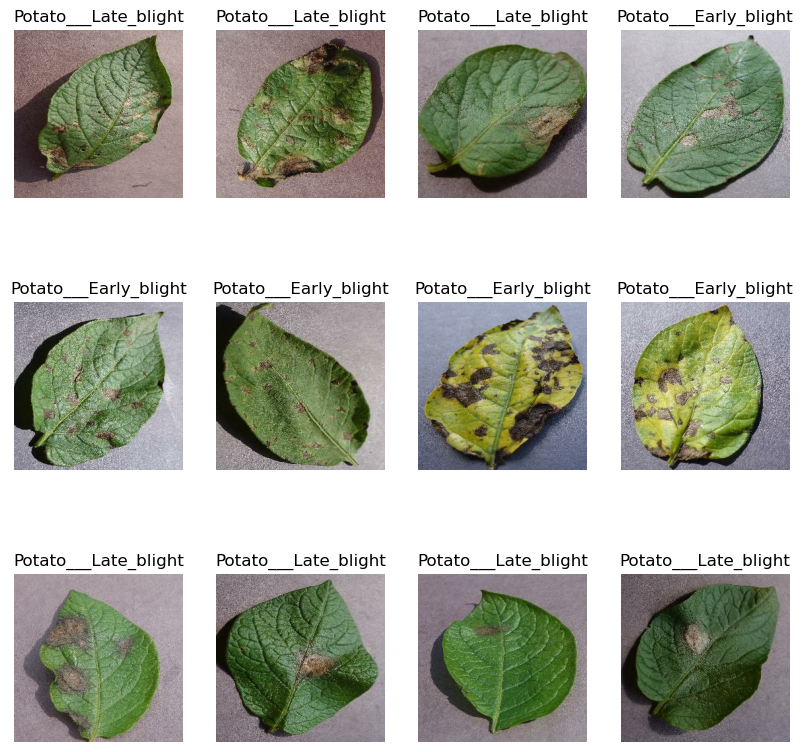

In [5]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range (12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis('off')
    # print(image_batch.shape)
    # print(label_batch.numpy())

In [6]:
len(dataset)

68

In [7]:
# 80% = training dataset
# 20% = 10%testing dataaset, 10% validation
train_size = 0.8
len(dataset)*train_size


54.400000000000006

In [8]:
train_ds = dataset.take(64)
len(train_ds)

64

In [9]:
test_ds = dataset.skip(64)
len(test_ds)

4

In [10]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [11]:
val_ds = dataset.take(8)
len(val_ds)

8

In [12]:
test_ds = test_ds.skip(64)
len(test_ds)

0

In [13]:
def get_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)

    train_size = int(train_split *ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds,test_ds,val_ds

In [14]:
train_ds, val_ds, test_ds = get_partition_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(test_ds)

6

In [17]:
len(val_ds)

8

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D( 32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  (3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  (3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax')
])
model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


2025-01-08 16:48:35.197147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-08 16:48:35.339165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:35.351078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/54 [..............................] - ETA: 1:38 - loss: 1.0831 - accuracy: 0.4375

2025-01-08 16:48:36.662839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:36.663471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 13s - loss: 1.0432 - accuracy: 0.4531 

2025-01-08 16:48:36.884922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:36.885587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 11s - loss: 0.9889 - accuracy: 0.4688

2025-01-08 16:48:37.096390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:37.096709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:37.295650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:37.295937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 10s - loss: 0.9291 - accuracy: 0.4844

2025-01-08 16:48:37.486670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:37.486960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:37.678801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:37.678992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.9439 - accuracy: 0.4732 

2025-01-08 16:48:37.883376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:37.883530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 9s - loss: 0.9345 - accuracy: 0.4648

2025-01-08 16:48:38.093388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:38.093850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.9303 - accuracy: 0.4618

2025-01-08 16:48:38.306202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:38.306196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 9s - loss: 0.9256 - accuracy: 0.4625

2025-01-08 16:48:38.536525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:38.536778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 9s - loss: 0.9300 - accuracy: 0.4517

2025-01-08 16:48:38.823354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:38.824490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 9s - loss: 0.9265 - accuracy: 0.4427

2025-01-08 16:48:39.114620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:39.115040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.9339 - accuracy: 0.4308

2025-01-08 16:48:39.346602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:39.346769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:39.539552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:39.539842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 8s - loss: 0.9314 - accuracy: 0.4297

2025-01-08 16:48:39.735103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:39.735382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:39.934540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:39.934848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.9350 - accuracy: 0.4340

2025-01-08 16:48:40.131306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:40.131557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:40.328829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:40.329184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.9380 - accuracy: 0.4457

2025-01-08 16:48:40.526440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:40.526733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 7s - loss: 0.9409 - accuracy: 0.4484

2025-01-08 16:48:40.739027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:40.739052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 7s - loss: 0.9432 - accuracy: 0.4509

2025-01-08 16:48:40.961234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:40.961284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.9430 - accuracy: 0.4517

2025-01-08 16:48:41.180008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:41.180191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.9394 - accuracy: 0.4596

2025-01-08 16:48:41.392707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:41.393522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 6s - loss: 0.9391 - accuracy: 0.4600

2025-01-08 16:48:41.593287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:41.593734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:41.788796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:41.789132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.9426 - accuracy: 0.4595

2025-01-08 16:48:41.979601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:41.979753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:42.178291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:42.178708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.9362 - accuracy: 0.4623

2025-01-08 16:48:42.376521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:42.376852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:42.570041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:42.570377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.9329 - accuracy: 0.4536

2025-01-08 16:48:42.767024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:42.767374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:42.971251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:42.971652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.9283 - accuracy: 0.4640

2025-01-08 16:48:43.202907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:43.203420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:43.396987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:43.397221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.9260 - accuracy: 0.4679

2025-01-08 16:48:43.588599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:43.589053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:43.781787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:43.781934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.9258 - accuracy: 0.4696

2025-01-08 16:48:43.978864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:43.979143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.9250 - accuracy: 0.4712

2025-01-08 16:48:44.189072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:44.189168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:44.380076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:44.380423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.9227 - accuracy: 0.4719

2025-01-08 16:48:44.580086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:44.580101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:44.772031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:44.772417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.9201 - accuracy: 0.4710

2025-01-08 16:48:44.965512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:44.965667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:45.156993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:45.157309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.9219 - accuracy: 0.4716

2025-01-08 16:48:45.350528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:45.350664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:45.546551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:45.546827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.9211 - accuracy: 0.4701

2025-01-08 16:48:45.737703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:45.738007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:45.935097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:45.935482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.9207 - accuracy: 0.4694

2025-01-08 16:48:46.132527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:46.132999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:46.327794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:46.328163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.9206 - accuracy: 0.4700

2025-01-08 16:48:46.520975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:46.521475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:46.711187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:46.711505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.9198 - accuracy: 0.4663

2025-01-08 16:48:46.901883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:46.902132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:47.092684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:47.093013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.9163 - accuracy: 0.4705

2025-01-08 16:48:47.285260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:47.285511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:47.696354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 14s 237ms/step - loss: 0.9163 - accuracy: 0.4705 - val_loss: 0.8790 - val_accuracy: 0.4648
Epoch 2/50


2025-01-08 16:48:49.219448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:49.220028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/54 [..............................] - ETA: 23s - loss: 0.9140 - accuracy: 0.4375

2025-01-08 16:48:49.675152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:49.678360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 14s - loss: 0.8614 - accuracy: 0.4219

2025-01-08 16:48:49.952549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:49.952729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 12s - loss: 0.8383 - accuracy: 0.4688

2025-01-08 16:48:50.167843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:50.169174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 11s - loss: 0.8252 - accuracy: 0.4922

2025-01-08 16:48:50.384397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:50.384505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 11s - loss: 0.8606 - accuracy: 0.5125

2025-01-08 16:48:50.607427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:50.607454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 11s - loss: 0.8507 - accuracy: 0.5156

2025-01-08 16:48:50.877751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:50.878124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 10s - loss: 0.8698 - accuracy: 0.5195

2025-01-08 16:48:51.091522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:51.091929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:51.296144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:51.297318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 10s - loss: 0.8825 - accuracy: 0.5243

2025-01-08 16:48:51.525724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:51.526101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 10s - loss: 0.8815 - accuracy: 0.5219

2025-01-08 16:48:51.846894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:51.847253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 10s - loss: 0.8770 - accuracy: 0.5398

2025-01-08 16:48:52.085054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:52.086457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 10s - loss: 0.8720 - accuracy: 0.5312

2025-01-08 16:48:52.323545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:52.323724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 9s - loss: 0.8665 - accuracy: 0.5288 

2025-01-08 16:48:52.569882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:52.571018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 9s - loss: 0.8672 - accuracy: 0.5179

2025-01-08 16:48:52.817264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:52.817892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 9s - loss: 0.8669 - accuracy: 0.5208

2025-01-08 16:48:53.054716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:53.055819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 9s - loss: 0.8667 - accuracy: 0.5215

2025-01-08 16:48:53.273227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:53.273628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 8s - loss: 0.8664 - accuracy: 0.5276

2025-01-08 16:48:53.541668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:53.542146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 8s - loss: 0.8620 - accuracy: 0.5399

2025-01-08 16:48:53.784249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:53.784374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 8s - loss: 0.8535 - accuracy: 0.5477

2025-01-08 16:48:54.183291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:54.183827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 8s - loss: 0.8549 - accuracy: 0.5453

2025-01-08 16:48:54.436617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:54.436869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 7s - loss: 0.8586 - accuracy: 0.5497

2025-01-08 16:48:54.640074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:54.640196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 7s - loss: 0.8564 - accuracy: 0.5448

2025-01-08 16:48:54.841212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:54.841267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:55.039963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:55.040207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 7s - loss: 0.8525 - accuracy: 0.5537

2025-01-08 16:48:55.285791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:55.286051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:55.482379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:55.482620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 6s - loss: 0.8550 - accuracy: 0.5577

2025-01-08 16:48:55.678556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:55.678966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 6s - loss: 0.8591 - accuracy: 0.5567

2025-01-08 16:48:55.925303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:55.925654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 6s - loss: 0.8609 - accuracy: 0.5502

2025-01-08 16:48:56.168301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:56.168469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 6s - loss: 0.8607 - accuracy: 0.5496

2025-01-08 16:48:56.410999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:56.411307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 5s - loss: 0.8669 - accuracy: 0.5494

2025-01-08 16:48:56.654481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:56.654728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:56.845868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:56.846064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.8649 - accuracy: 0.5578

2025-01-08 16:48:57.038679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:57.039057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:57.238825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:57.239176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 4s - loss: 0.8600 - accuracy: 0.5616

2025-01-08 16:48:57.435526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:57.435834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:57.630433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:57.630685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.8583 - accuracy: 0.5633

2025-01-08 16:48:57.827552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:57.827942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:58.025954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:58.026240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.8560 - accuracy: 0.5641

2025-01-08 16:48:58.237414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:58.237921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:58.429097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:58.429339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 3s - loss: 0.8552 - accuracy: 0.5664

2025-01-08 16:48:58.628421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:58.628689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.8500 - accuracy: 0.5685

2025-01-08 16:48:58.873014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:58.873245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:59.068004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:59.068198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.8493 - accuracy: 0.5618

2025-01-08 16:48:59.271566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:59.271973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:59.462408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:59.462871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 2s - loss: 0.8435 - accuracy: 0.5653

2025-01-08 16:48:59.677357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:59.678351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.8406 - accuracy: 0.5679

2025-01-08 16:48:59.894744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:48:59.895088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.8417 - accuracy: 0.5691

2025-01-08 16:49:00.100383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:00.101579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.8381 - accuracy: 0.5723

2025-01-08 16:49:00.340818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:00.341135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.8308 - accuracy: 0.5765

2025-01-08 16:49:00.555943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:00.556429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.8254 - accuracy: 0.5819

2025-01-08 16:49:00.846327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:00.846742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.8212 - accuracy: 0.5858

2025-01-08 16:49:01.105478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:01.106078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.8187 - accuracy: 0.5871

2025-01-08 16:49:01.355234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:01.355624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.8139 - accuracy: 0.5884

2025-01-08 16:49:01.622839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:01.623243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 13s 238ms/step - loss: 0.8123 - accuracy: 0.5909 - val_loss: 0.5939 - val_accuracy: 0.7500
Epoch 3/50
 1/54 [..............................] - ETA: 10s - loss: 0.7026 - accuracy: 0.6562

2025-01-08 16:49:02.265887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:02.266031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:02.456692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:02.456931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 10s - loss: 0.6307 - accuracy: 0.7344

2025-01-08 16:49:02.650473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:02.650694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.6609 - accuracy: 0.7031

2025-01-08 16:49:02.854544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:02.855031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.6470 - accuracy: 0.6875 

2025-01-08 16:49:03.057068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:03.057490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:03.250845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:03.251135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.6754 - accuracy: 0.6562

2025-01-08 16:49:03.442852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:03.443187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:03.639184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:03.639453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 8s - loss: 0.6719 - accuracy: 0.6701

2025-01-08 16:49:03.834967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:03.835519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:04.036775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:04.037060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.6840 - accuracy: 0.6619

2025-01-08 16:49:04.240483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:04.240882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:04.439471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:04.439863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.6826 - accuracy: 0.6667

2025-01-08 16:49:04.640531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:04.640827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 7s - loss: 0.6995 - accuracy: 0.6496

2025-01-08 16:49:04.844590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:04.844728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:05.044928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.6814 - accuracy: 0.6583

2025-01-08 16:49:05.045246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:05.238665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:05.238936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.6894 - accuracy: 0.6673

2025-01-08 16:49:05.432922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:05.433281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:05.623817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:05.624105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 6s - loss: 0.7039 - accuracy: 0.6727

2025-01-08 16:49:05.819327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:05.819481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:06.024826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:06.024852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.6895 - accuracy: 0.6801

2025-01-08 16:49:06.248051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:06.248548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:06.445006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:06.445205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.6856 - accuracy: 0.6834

2025-01-08 16:49:06.640714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:06.640910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:06.834463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:06.834727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.6902 - accuracy: 0.6762

2025-01-08 16:49:07.031304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:07.031491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:07.225299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:07.225656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.6921 - accuracy: 0.6731

2025-01-08 16:49:07.421283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:07.421448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.6800 - accuracy: 0.6797

2025-01-08 16:49:07.657705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:07.658138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:07.860030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:07.860332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.6751 - accuracy: 0.6821

2025-01-08 16:49:08.093579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:08.093620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.6652 - accuracy: 0.6885

2025-01-08 16:49:08.333966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:08.334172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:08.536033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:08.536165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.6625 - accuracy: 0.6913

2025-01-08 16:49:08.748309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:08.749397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.6602 - accuracy: 0.6939

2025-01-08 16:49:08.951918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:08.952299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:09.145388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:09.145643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.6604 - accuracy: 0.6936

2025-01-08 16:49:09.335951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:09.336225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:09.528644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:09.528885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.6644 - accuracy: 0.6934

2025-01-08 16:49:09.735554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:09.735932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.6502 - accuracy: 0.6987

2025-01-08 16:49:09.939693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:09.940123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:10.135054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:10.135348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.6413 - accuracy: 0.7027

2025-01-08 16:49:10.330696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:10.331256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:10.528673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:10.528928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.6356 - accuracy: 0.7049

2025-01-08 16:49:10.727373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:10.727849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:10.927307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:10.927561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.6298 - accuracy: 0.7090

2025-01-08 16:49:11.133928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:11.134701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.6230 - accuracy: 0.7126

2025-01-08 16:49:11.334723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:11.334994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:11.526427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:11.526722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.6246 - accuracy: 0.7109

2025-01-08 16:49:11.718596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:11.719069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:11.913050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:11.913374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.6151 - accuracy: 0.7156

2025-01-08 16:49:12.109705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:12.110073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:12.307880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:12.308286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.6081 - accuracy: 0.7188

2025-01-08 16:49:12.502259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:12.502316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:12.696391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:12.696840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.6020 - accuracy: 0.7216

2025-01-08 16:49:12.888900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:12.889329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 208ms/step - loss: 0.6020 - accuracy: 0.7216 - val_loss: 0.4666 - val_accuracy: 0.7852
Epoch 4/50


2025-01-08 16:49:13.501511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:13.501963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/54 [..............................] - ETA: 14s - loss: 0.4997 - accuracy: 0.7500

2025-01-08 16:49:13.767171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:13.767446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 11s - loss: 0.4230 - accuracy: 0.8281

2025-01-08 16:49:13.982769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:13.982882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.4797 - accuracy: 0.8125

2025-01-08 16:49:14.190426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:14.190615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:14.385236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:14.385583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 9s - loss: 0.4838 - accuracy: 0.8021 

2025-01-08 16:49:14.589795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:14.589981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:14.782272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:14.782696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 9s - loss: 0.4716 - accuracy: 0.7930

2025-01-08 16:49:14.977657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:14.978082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:15.169213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:15.169467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 8s - loss: 0.4362 - accuracy: 0.8156

2025-01-08 16:49:15.360934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:15.361220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:15.553979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:15.554148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.4308 - accuracy: 0.8229

2025-01-08 16:49:15.752935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:15.753453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:15.949369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:15.949552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 7s - loss: 0.4294 - accuracy: 0.8214

2025-01-08 16:49:16.144793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:16.145164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.4337 - accuracy: 0.8167

2025-01-08 16:49:16.346945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:16.347344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:16.537358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:16.537735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.4197 - accuracy: 0.8217

2025-01-08 16:49:16.731044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:16.731410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:16.925130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:16.925220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 6s - loss: 0.4136 - accuracy: 0.8306

2025-01-08 16:49:17.127571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:17.127844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:17.321923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:17.322020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.4105 - accuracy: 0.8318

2025-01-08 16:49:17.523899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:17.524247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:17.717811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:17.718176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.4084 - accuracy: 0.8288

2025-01-08 16:49:17.917942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:17.918029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:18.117663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:18.117915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.4067 - accuracy: 0.8275

2025-01-08 16:49:18.313288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:18.313421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:18.509773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:18.509965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.3952 - accuracy: 0.8322

2025-01-08 16:49:18.703082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:18.703343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:18.899200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:18.899354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 4s - loss: 0.3873 - accuracy: 0.8341

2025-01-08 16:49:19.091828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:19.092047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:19.284680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:19.285040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.3839 - accuracy: 0.8367

2025-01-08 16:49:19.477002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:19.477381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:19.670776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:19.671149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.3920 - accuracy: 0.8381

2025-01-08 16:49:19.866919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:19.867313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:20.056763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:20.056990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.3855 - accuracy: 0.8438

2025-01-08 16:49:20.255417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:20.255785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:20.443795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:20.444247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.3867 - accuracy: 0.8412

2025-01-08 16:49:20.636294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:20.636299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:20.834884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:20.835178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 2s - loss: 0.3809 - accuracy: 0.8446

2025-01-08 16:49:21.027251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:21.027459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:21.223840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:21.223987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.3867 - accuracy: 0.8430

2025-01-08 16:49:21.418800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:21.419250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:21.618570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:21.619601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.3891 - accuracy: 0.8423

2025-01-08 16:49:21.811543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:21.811697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:22.002165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:22.002490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.3966 - accuracy: 0.8389

2025-01-08 16:49:22.193588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:22.193888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:22.389156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:22.389341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.4016 - accuracy: 0.8371

2025-01-08 16:49:22.582730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:22.582988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:22.774309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:22.774584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.3993 - accuracy: 0.8379

2025-01-08 16:49:22.967405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:22.967768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 0s - loss: 0.3997 - accuracy: 0.8367

2025-01-08 16:49:23.188040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:23.188490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.3989 - accuracy: 0.8375

2025-01-08 16:49:23.401137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:23.401667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.4009 - accuracy: 0.8371

2025-01-08 16:49:23.612911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:23.613220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:23.811452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:23.811878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.4052 - accuracy: 0.8345

2025-01-08 16:49:24.019136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:24.019266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 204ms/step - loss: 0.4052 - accuracy: 0.8345 - val_loss: 0.4354 - val_accuracy: 0.8359
Epoch 5/50


2025-01-08 16:49:24.594631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:24.594942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 10s - loss: 0.3326 - accuracy: 0.8906

2025-01-08 16:49:24.800954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:24.801186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:24.996303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:24.996621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 9s - loss: 0.3994 - accuracy: 0.8438

2025-01-08 16:49:25.192260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:25.192528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:25.383981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:25.384150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 9s - loss: 0.3684 - accuracy: 0.8542

2025-01-08 16:49:25.578433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:25.578618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:25.771010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:25.771368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 8s - loss: 0.3577 - accuracy: 0.8594

2025-01-08 16:49:25.971303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:25.971517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:26.164960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:26.165242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 8s - loss: 0.3970 - accuracy: 0.8406

2025-01-08 16:49:26.358674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:26.359035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:26.557825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:26.557987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.4163 - accuracy: 0.8333

2025-01-08 16:49:26.749316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:26.749656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:26.944926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:26.945380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 7s - loss: 0.4251 - accuracy: 0.8237

2025-01-08 16:49:27.139346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:27.139596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:27.333563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:27.333956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 7s - loss: 0.4067 - accuracy: 0.8320

2025-01-08 16:49:27.539317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:27.539584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:27.738399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:27.738757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.4067 - accuracy: 0.8229

2025-01-08 16:49:27.936638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:27.937295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:28.130796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:28.131317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 6s - loss: 0.4054 - accuracy: 0.8191

2025-01-08 16:49:28.346207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:28.348592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 6s - loss: 0.4019 - accuracy: 0.8203

2025-01-08 16:49:28.596598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:28.597209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.4025 - accuracy: 0.8239

2025-01-08 16:49:28.802527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:28.802636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.4181 - accuracy: 0.8179

2025-01-08 16:49:29.004910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:29.005149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:29.200897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:29.201009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.4201 - accuracy: 0.8163

2025-01-08 16:49:29.408398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:29.408567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:29.598609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:29.598688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.4179 - accuracy: 0.8218

2025-01-08 16:49:29.800243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:29.800680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:29.999718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:29.999959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 4s - loss: 0.4073 - accuracy: 0.8276

2025-01-08 16:49:30.193328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:30.193732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:30.385322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:30.385542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.4100 - accuracy: 0.8246

2025-01-08 16:49:30.583039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:30.583484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:30.774856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:30.775071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.4186 - accuracy: 0.8267

2025-01-08 16:49:30.967993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:30.968194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:31.159859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:31.160062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.4029 - accuracy: 0.8339

2025-01-08 16:49:31.355769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:31.356188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:31.550632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:31.550902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.4002 - accuracy: 0.8353

2025-01-08 16:49:31.746425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:31.746702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:31.938698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:31.938847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 2s - loss: 0.3911 - accuracy: 0.8389

2025-01-08 16:49:32.135430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:32.135673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:32.327731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:32.327933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.3869 - accuracy: 0.8392

2025-01-08 16:49:32.519609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:32.520036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:32.715063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:32.715379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.3901 - accuracy: 0.8387

2025-01-08 16:49:32.905956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:32.906328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:33.098530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:33.098843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.3828 - accuracy: 0.8410

2025-01-08 16:49:33.292499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:33.292656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:33.485708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:33.486008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.3787 - accuracy: 0.8431

2025-01-08 16:49:33.680389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:33.680678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:33.883292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:33.883622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.3735 - accuracy: 0.8457

2025-01-08 16:49:34.108890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:34.109345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.3721 - accuracy: 0.8431

2025-01-08 16:49:34.315708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:34.316132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:34.508020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:34.508357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.3696 - accuracy: 0.8450

2025-01-08 16:49:34.700038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:34.700245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:34.900637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:34.900820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.3656 - accuracy: 0.8472

2025-01-08 16:49:35.094636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:35.094950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 205ms/step - loss: 0.3656 - accuracy: 0.8472 - val_loss: 0.3444 - val_accuracy: 0.8672
Epoch 6/50
 1/54 [..............................] - ETA: 10s - loss: 0.5148 - accuracy: 0.9062

2025-01-08 16:49:35.663406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:35.663638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:35.854161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:35.854464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 9s - loss: 0.3000 - accuracy: 0.9271

2025-01-08 16:49:36.045411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:36.045768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:36.238414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:36.238816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.2759 - accuracy: 0.9375

2025-01-08 16:49:36.430371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:36.430687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:36.622593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:36.623011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.2541 - accuracy: 0.9375

2025-01-08 16:49:36.814767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:36.815022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:37.005479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:37.005885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 8s - loss: 0.3077 - accuracy: 0.9132

2025-01-08 16:49:37.196876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:37.197110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:37.387552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:37.387917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.3192 - accuracy: 0.9006

2025-01-08 16:49:37.578809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:37.579132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:37.770623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:37.770886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 7s - loss: 0.3195 - accuracy: 0.8918

2025-01-08 16:49:37.965180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:37.965440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:38.157465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:38.157863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.3436 - accuracy: 0.8792

2025-01-08 16:49:38.347267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:38.347654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:38.538526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:38.538818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.3493 - accuracy: 0.8787

2025-01-08 16:49:38.729562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:38.729855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:38.922125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:38.922330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 6s - loss: 0.3729 - accuracy: 0.8668

2025-01-08 16:49:39.114601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:39.114865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:39.306118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:39.306289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.4001 - accuracy: 0.8512

2025-01-08 16:49:39.500613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:39.501043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:39.692167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:39.692370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 5s - loss: 0.4237 - accuracy: 0.8438

2025-01-08 16:49:39.884797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:39.884887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:40.076825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:40.077014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.4377 - accuracy: 0.8350

2025-01-08 16:49:40.269326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:40.269457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:40.464527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:40.464605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.4506 - accuracy: 0.8299

2025-01-08 16:49:40.656511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:40.656739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:40.847862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:40.848001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 4s - loss: 0.4537 - accuracy: 0.8254

2025-01-08 16:49:41.039813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:41.039969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:41.230660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:41.230802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.4487 - accuracy: 0.8246

2025-01-08 16:49:41.421330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:41.421732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:41.614221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:41.614514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.4440 - accuracy: 0.8295

2025-01-08 16:49:41.814363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:41.814552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:42.006245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:42.006670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.4402 - accuracy: 0.8295

2025-01-08 16:49:42.198500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:42.198828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:42.397262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:42.397431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.4414 - accuracy: 0.8277

2025-01-08 16:49:42.594517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:42.594879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:42.788655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:42.788834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 2s - loss: 0.4366 - accuracy: 0.8325

2025-01-08 16:49:43.003267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:43.003651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:43.193064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:43.193310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.4374 - accuracy: 0.8300

2025-01-08 16:49:43.389330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:43.389566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:43.583571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:43.583764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.4410 - accuracy: 0.8274

2025-01-08 16:49:43.776661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:43.776903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.4416 - accuracy: 0.8278

2025-01-08 16:49:43.994375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:43.994732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 1s - loss: 0.4489 - accuracy: 0.8267

2025-01-08 16:49:44.258641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:44.258883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.4528 - accuracy: 0.8288

2025-01-08 16:49:44.481869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:44.482257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:44.677959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:44.677979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.4519 - accuracy: 0.8281

2025-01-08 16:49:44.881306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:44.881537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:45.079121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:45.079401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.4558 - accuracy: 0.8256

2025-01-08 16:49:45.272329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:45.272588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:45.467766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:45.468090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.4523 - accuracy: 0.8269

2025-01-08 16:49:45.663904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:45.664224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:45.856251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:45.856398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.8299

2025-01-08 16:49:46.056535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:46.056870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 203ms/step - loss: 0.4480 - accuracy: 0.8299 - val_loss: 0.3716 - val_accuracy: 0.8828
Epoch 7/50
 1/54 [..............................] - ETA: 9s - loss: 0.3180 - accuracy: 0.9062

2025-01-08 16:49:46.608841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:46.609004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:46.797752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:46.797990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 9s - loss: 0.3851 - accuracy: 0.8438

2025-01-08 16:49:46.989499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:46.989734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:47.182303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:47.182630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.3898 - accuracy: 0.8375

2025-01-08 16:49:47.377139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:47.378142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:47.563578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:47.563843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.3834 - accuracy: 0.8393

2025-01-08 16:49:47.756963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:47.757148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:47.947184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:47.947373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 8s - loss: 0.3766 - accuracy: 0.8438

2025-01-08 16:49:48.147987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:48.148439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:48.342034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:48.342552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.3858 - accuracy: 0.8295

2025-01-08 16:49:48.529019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:48.529411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:48.720992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:48.721119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 7s - loss: 0.3877 - accuracy: 0.8341

2025-01-08 16:49:48.915295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:48.915596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:49.110129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:49.110345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.3863 - accuracy: 0.8313

2025-01-08 16:49:49.309397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:49.309670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:49.502561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:49.503092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.3786 - accuracy: 0.8364

2025-01-08 16:49:49.697195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:49.697522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:49.891422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:49.891752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 6s - loss: 0.3786 - accuracy: 0.8368

2025-01-08 16:49:50.094227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:50.094440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 6s - loss: 0.3769 - accuracy: 0.8355

2025-01-08 16:49:50.298917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:50.299021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.3671 - accuracy: 0.8423

2025-01-08 16:49:50.532019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:50.532285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:50.732633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.3605 - accuracy: 0.8466

2025-01-08 16:49:50.732977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:50.933433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:50.933973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 5s - loss: 0.3563 - accuracy: 0.8490

2025-01-08 16:49:51.138131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:51.138441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:51.331676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:51.332112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.3458 - accuracy: 0.8570

2025-01-08 16:49:51.524436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:51.524771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:51.715208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:51.715393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.3380 - accuracy: 0.8616

2025-01-08 16:49:51.907232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:51.907623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:52.101822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:52.101936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.3366 - accuracy: 0.8625

2025-01-08 16:49:52.298105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:52.298304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:52.493675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:52.493936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.3318 - accuracy: 0.8613

2025-01-08 16:49:52.685709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:52.685913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:52.884926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:52.885237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 3s - loss: 0.3277 - accuracy: 0.8640

2025-01-08 16:49:53.082284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:53.082682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:53.272810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:53.273069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.3223 - accuracy: 0.8663

2025-01-08 16:49:53.465038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:53.465367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:53.657536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:53.657696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.3224 - accuracy: 0.8651

2025-01-08 16:49:53.850917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:53.851242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:54.045547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:54.046176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.3188 - accuracy: 0.8648

2025-01-08 16:49:54.240226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:54.240455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:54.435002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:54.435232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.3237 - accuracy: 0.8646

2025-01-08 16:49:54.626262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:54.626627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:54.821346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:54.821666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 1s - loss: 0.3215 - accuracy: 0.8665

2025-01-08 16:49:55.022260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:55.022388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:55.212955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:55.213262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.3194 - accuracy: 0.8682

2025-01-08 16:49:55.406912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:55.407266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:55.597180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:55.597367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.3171 - accuracy: 0.8685

2025-01-08 16:49:55.797709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:55.798369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 0s - loss: 0.3160 - accuracy: 0.8680

2025-01-08 16:49:55.999908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:56.000012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.3127 - accuracy: 0.8700

2025-01-08 16:49:56.203460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:56.203667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:56.405290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:56.405637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.3085 - accuracy: 0.8708

2025-01-08 16:49:56.609452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:56.609713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:56.803055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:56.803643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.3170 - accuracy: 0.8669

2025-01-08 16:49:56.996211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:56.996519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 203ms/step - loss: 0.3170 - accuracy: 0.8669 - val_loss: 0.2783 - val_accuracy: 0.9023
Epoch 8/50
 1/54 [..............................] - ETA: 9s - loss: 0.2395 - accuracy: 0.9375

2025-01-08 16:49:57.557294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:57.557519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:57.744566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:57.745022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 9s - loss: 0.2629 - accuracy: 0.9062 

2025-01-08 16:49:57.942027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:57.942469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:58.136198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:58.136746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.2947 - accuracy: 0.8938

2025-01-08 16:49:58.326215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:58.326897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:58.524188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:58.524391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.3085 - accuracy: 0.8839

2025-01-08 16:49:58.715215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:58.715558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:58.910907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:58.911168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 8s - loss: 0.2976 - accuracy: 0.8819

2025-01-08 16:49:59.137259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:59.137407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:59.335591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:59.335713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.2748 - accuracy: 0.8807

2025-01-08 16:49:59.527629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:59.527783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:59.714240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:59.714366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.2700 - accuracy: 0.8870

2025-01-08 16:49:59.902119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:49:59.902280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 7s - loss: 0.2834 - accuracy: 0.8862

2025-01-08 16:50:00.104709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:00.104912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:00.304949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:00.305602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.2981 - accuracy: 0.8854

2025-01-08 16:50:00.509632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:00.509738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 7s - loss: 0.3029 - accuracy: 0.8848

2025-01-08 16:50:00.713038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:00.713122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.3087 - accuracy: 0.8805

2025-01-08 16:50:00.938810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:00.939040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 6s - loss: 0.2983 - accuracy: 0.8832

2025-01-08 16:50:01.144735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:01.145052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:01.343967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:01.344154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.2879 - accuracy: 0.8854

2025-01-08 16:50:01.539233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:01.539541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:01.734876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:01.734994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.2869 - accuracy: 0.8864

2025-01-08 16:50:01.931906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:01.932078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.2881 - accuracy: 0.8859

2025-01-08 16:50:02.136586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:02.136764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.2820 - accuracy: 0.8875

2025-01-08 16:50:02.372457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:02.372718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:02.573304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:02.573410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.2775 - accuracy: 0.8906

2025-01-08 16:50:02.787702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:02.788694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.2739 - accuracy: 0.8924

2025-01-08 16:50:03.029382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:03.029908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.2739 - accuracy: 0.8884

2025-01-08 16:50:03.240053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:03.240377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.2748 - accuracy: 0.8858

2025-01-08 16:50:03.446089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:03.446549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.2699 - accuracy: 0.8885

2025-01-08 16:50:03.689768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:03.689812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.2720 - accuracy: 0.8881

2025-01-08 16:50:03.973362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:03.974663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.2711 - accuracy: 0.8887

2025-01-08 16:50:04.250572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:04.251728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.2683 - accuracy: 0.8902

2025-01-08 16:50:04.492788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:04.493388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.2667 - accuracy: 0.8902

2025-01-08 16:50:04.700741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:04.700929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.2707 - accuracy: 0.8872

2025-01-08 16:50:04.901436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:04.901769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:05.099706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:05.100084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.2724 - accuracy: 0.8877

2025-01-08 16:50:05.299334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:05.299792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.2717 - accuracy: 0.8890

2025-01-08 16:50:05.515390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:05.515911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.2726 - accuracy: 0.8894

2025-01-08 16:50:05.736770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:05.737294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.2767 - accuracy: 0.8883

2025-01-08 16:50:05.946980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:05.947425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.2758 - accuracy: 0.8899

2025-01-08 16:50:06.158779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:06.158836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:06.360415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:06.362379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.2701 - accuracy: 0.8899

2025-01-08 16:50:06.568873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:06.569308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:06.766420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:06.766812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.2695 - accuracy: 0.8896

2025-01-08 16:50:06.970898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:06.971024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.2688 - accuracy: 0.8906

2025-01-08 16:50:07.187257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:07.187803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.2743 - accuracy: 0.8896

2025-01-08 16:50:07.399169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:07.399431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.2793 - accuracy: 0.8893

2025-01-08 16:50:07.637784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:07.637998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.2777 - accuracy: 0.8903

2025-01-08 16:50:07.843827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:07.843925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.2792 - accuracy: 0.8894

2025-01-08 16:50:08.130701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:08.130982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.2784 - accuracy: 0.8909

2025-01-08 16:50:08.386424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:08.388482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.2784 - accuracy: 0.8906

2025-01-08 16:50:08.630896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:08.631738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.2807 - accuracy: 0.8897

2025-01-08 16:50:08.869122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:08.870252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 13s 248ms/step - loss: 0.2797 - accuracy: 0.8906 - val_loss: 0.4188 - val_accuracy: 0.7969
Epoch 9/50


2025-01-08 16:50:10.900619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:10.903080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/54 [..............................] - ETA: 26s - loss: 0.2465 - accuracy: 0.8750

2025-01-08 16:50:11.414672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:11.416159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 14s - loss: 0.4318 - accuracy: 0.8281

2025-01-08 16:50:11.672434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:11.672812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 13s - loss: 0.3525 - accuracy: 0.8854

2025-01-08 16:50:11.916198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:11.916308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 12s - loss: 0.2916 - accuracy: 0.9062

2025-01-08 16:50:12.133741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:12.134226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 11s - loss: 0.3284 - accuracy: 0.9000

2025-01-08 16:50:12.371351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:12.371414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 12s - loss: 0.3837 - accuracy: 0.8802

2025-01-08 16:50:12.648975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:12.649332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 11s - loss: 0.3723 - accuracy: 0.8795

2025-01-08 16:50:12.891623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:12.891996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 11s - loss: 0.3668 - accuracy: 0.8828

2025-01-08 16:50:13.129692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:13.129924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 10s - loss: 0.3383 - accuracy: 0.8889

2025-01-08 16:50:13.346123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:13.346590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 10s - loss: 0.3493 - accuracy: 0.8844

2025-01-08 16:50:13.586021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:13.586971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 10s - loss: 0.3522 - accuracy: 0.8807

2025-01-08 16:50:13.849763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:13.851250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 10s - loss: 0.3631 - accuracy: 0.8802

2025-01-08 16:50:14.266058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:14.266747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 10s - loss: 0.3468 - accuracy: 0.8870

2025-01-08 16:50:14.522261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:14.522569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 10s - loss: 0.3497 - accuracy: 0.8906

2025-01-08 16:50:14.727765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:14.728268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 9s - loss: 0.3553 - accuracy: 0.8887

2025-01-08 16:50:14.937168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:14.937469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:15.133438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:15.133765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 9s - loss: 0.3581 - accuracy: 0.8842

2025-01-08 16:50:15.337217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:15.337525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 8s - loss: 0.3471 - accuracy: 0.8854

2025-01-08 16:50:15.605427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:15.605789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 8s - loss: 0.3384 - accuracy: 0.8914

2025-01-08 16:50:15.809994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:15.810269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 8s - loss: 0.3327 - accuracy: 0.8906

2025-01-08 16:50:16.087878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:16.088125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 7s - loss: 0.3309 - accuracy: 0.8892

2025-01-08 16:50:16.297026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:16.297359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:16.496060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:16.496492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 7s - loss: 0.3403 - accuracy: 0.8828

2025-01-08 16:50:16.710329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:16.710454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 6s - loss: 0.3397 - accuracy: 0.8838

2025-01-08 16:50:16.912070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:16.912320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:17.104184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:17.104388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 6s - loss: 0.3422 - accuracy: 0.8810

2025-01-08 16:50:17.303158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:17.303407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 6s - loss: 0.3412 - accuracy: 0.8796

2025-01-08 16:50:17.507123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:17.507356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 6s - loss: 0.3455 - accuracy: 0.8761

2025-01-08 16:50:17.720519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:17.720656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 5s - loss: 0.3359 - accuracy: 0.8781

2025-01-08 16:50:17.966194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:17.966332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:18.164410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:18.164575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 5s - loss: 0.3299 - accuracy: 0.8821

2025-01-08 16:50:18.386387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:18.386487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 5s - loss: 0.3289 - accuracy: 0.8818

2025-01-08 16:50:18.590568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:18.590869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.3302 - accuracy: 0.8797

2025-01-08 16:50:18.856349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:18.856430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.3230 - accuracy: 0.8824

2025-01-08 16:50:19.062133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:19.062237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 4s - loss: 0.3173 - accuracy: 0.8837

2025-01-08 16:50:19.309189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:19.309290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:19.503408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:19.503572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.3169 - accuracy: 0.8843

2025-01-08 16:50:19.695994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:19.695994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.3108 - accuracy: 0.8862

2025-01-08 16:50:19.904357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:19.904535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:20.100043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:20.100114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 3s - loss: 0.3072 - accuracy: 0.8875

2025-01-08 16:50:20.341713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:20.341881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.3029 - accuracy: 0.8895

2025-01-08 16:50:20.601018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:20.601339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.3051 - accuracy: 0.8876

2025-01-08 16:50:20.860831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:20.861091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.3038 - accuracy: 0.8874

2025-01-08 16:50:21.132105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:21.132390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 2s - loss: 0.3035 - accuracy: 0.8896

2025-01-08 16:50:21.339198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:21.339606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:21.541415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:21.541523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.3017 - accuracy: 0.8893

2025-01-08 16:50:21.779594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:21.780007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.2975 - accuracy: 0.8900

2025-01-08 16:50:21.984457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:21.984659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:22.179293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:22.179393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.2967 - accuracy: 0.8894

2025-01-08 16:50:22.414526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:22.414661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:22.615422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:22.615721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.2950 - accuracy: 0.8903

2025-01-08 16:50:22.835927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:22.836058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.2943 - accuracy: 0.8906

2025-01-08 16:50:23.105956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:23.106127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.2942 - accuracy: 0.8912

2025-01-08 16:50:23.333447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:23.333688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 13s 237ms/step - loss: 0.2942 - accuracy: 0.8912 - val_loss: 0.2676 - val_accuracy: 0.8984
Epoch 10/50


2025-01-08 16:50:23.984198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:23.984543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/54 [..............................] - ETA: 12s - loss: 0.2322 - accuracy: 0.9375

2025-01-08 16:50:24.211564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:24.211797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 10s - loss: 0.2183 - accuracy: 0.9375

2025-01-08 16:50:24.415675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:24.415771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.2001 - accuracy: 0.9479

2025-01-08 16:50:24.630527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:24.630703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.2066 - accuracy: 0.9375

2025-01-08 16:50:24.845520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:24.845667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 10s - loss: 0.2502 - accuracy: 0.9062

2025-01-08 16:50:25.057184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:25.057469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 10s - loss: 0.2318 - accuracy: 0.9167

2025-01-08 16:50:25.307847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:25.311426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 10s - loss: 0.2226 - accuracy: 0.9152

2025-01-08 16:50:25.563066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:25.563178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 10s - loss: 0.2154 - accuracy: 0.9180

2025-01-08 16:50:25.778601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:25.778710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.2366 - accuracy: 0.9062 

2025-01-08 16:50:25.983569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:25.983858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 9s - loss: 0.2620 - accuracy: 0.8977

2025-01-08 16:50:26.189103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:26.189368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 9s - loss: 0.2819 - accuracy: 0.8932

2025-01-08 16:50:26.390106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:26.390218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:26.584721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:26.584933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.2828 - accuracy: 0.8973

2025-01-08 16:50:26.779564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:26.779614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 8s - loss: 0.2884 - accuracy: 0.8979

2025-01-08 16:50:26.982425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:26.982669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:27.175581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:27.175921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.2809 - accuracy: 0.9007

2025-01-08 16:50:27.368775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:27.368982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:27.562072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:27.562350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.2820 - accuracy: 0.9046

2025-01-08 16:50:27.753836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:27.754096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:27.946492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:27.946768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.2735 - accuracy: 0.9062

2025-01-08 16:50:28.136903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:28.137171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:28.332782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:28.333049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.2757 - accuracy: 0.9049

2025-01-08 16:50:28.526663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:28.527014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:28.716831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:28.717081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.2789 - accuracy: 0.9050

2025-01-08 16:50:28.906339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:28.906900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:29.099621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:29.099932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.2794 - accuracy: 0.9039

2025-01-08 16:50:29.297718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:29.298100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:29.491515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:29.491764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.2782 - accuracy: 0.9029

2025-01-08 16:50:29.685456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:29.685899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.2818 - accuracy: 0.9030

2025-01-08 16:50:29.897317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:29.900998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.2788 - accuracy: 0.9022

2025-01-08 16:50:30.165641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:30.165914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:30.367418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:30.368093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.2788 - accuracy: 0.9033

2025-01-08 16:50:30.607627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:30.608152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.2759 - accuracy: 0.9026

2025-01-08 16:50:30.812750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:30.813151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:31.014712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:31.015587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.2711 - accuracy: 0.9036

2025-01-08 16:50:31.224301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:31.224809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:31.419611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:31.419821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.2694 - accuracy: 0.9030

2025-01-08 16:50:31.617944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:31.618281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:31.811038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:31.811419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.2779 - accuracy: 0.8984

2025-01-08 16:50:32.033162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:32.033357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.2798 - accuracy: 0.8971

2025-01-08 16:50:32.233670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:32.233975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:32.428973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:32.429187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.2841 - accuracy: 0.8961

2025-01-08 16:50:32.627646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:32.627989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:32.823516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:32.823895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.2798 - accuracy: 0.8972

2025-01-08 16:50:33.023439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:33.024060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:33.221457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:33.221632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.2824 - accuracy: 0.8956

2025-01-08 16:50:33.420068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:33.420458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:33.612613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:33.612716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.2807 - accuracy: 0.8958

2025-01-08 16:50:33.820450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:33.820789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.2819 - accuracy: 0.8960

2025-01-08 16:50:34.029486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:34.030126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.2847 - accuracy: 0.8913

2025-01-08 16:50:34.239669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:34.240156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.2848 - accuracy: 0.8924

2025-01-08 16:50:34.445009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:34.445314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:34.637073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:34.637468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.8924

2025-01-08 16:50:34.834186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:34.834495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 211ms/step - loss: 0.2841 - accuracy: 0.8924 - val_loss: 0.2882 - val_accuracy: 0.8945
Epoch 11/50
 1/54 [..............................] - ETA: 10s - loss: 0.2646 - accuracy: 0.8438

2025-01-08 16:50:35.404848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:35.405098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:35.598429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:35.598881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 9s - loss: 0.2433 - accuracy: 0.8958 

2025-01-08 16:50:35.791847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:35.792129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:35.985059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:35.985462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.2517 - accuracy: 0.8875

2025-01-08 16:50:36.179234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:36.179548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:36.374538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:36.374811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.2397 - accuracy: 0.9018

2025-01-08 16:50:36.570660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:36.571051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:36.765497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:36.765642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 8s - loss: 0.2479 - accuracy: 0.8993

2025-01-08 16:50:36.959857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:36.960270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:37.152865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:37.153029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.2360 - accuracy: 0.9034

2025-01-08 16:50:37.347697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:37.347944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:37.540053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:37.540380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 7s - loss: 0.2408 - accuracy: 0.9062

2025-01-08 16:50:37.735842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:37.736108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:37.930554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:37.930694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.2345 - accuracy: 0.9083

2025-01-08 16:50:38.129838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:38.130220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:38.327405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:38.327589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.2259 - accuracy: 0.9154

2025-01-08 16:50:38.520836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:38.521513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:38.721116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:38.721610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 6s - loss: 0.2220 - accuracy: 0.9161

2025-01-08 16:50:38.955937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:38.956213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 6s - loss: 0.2131 - accuracy: 0.9203

2025-01-08 16:50:39.157330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:39.157590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:39.351783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:39.352008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.2147 - accuracy: 0.9162

2025-01-08 16:50:39.547661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:39.547962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:39.741393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:39.741529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 5s - loss: 0.2115 - accuracy: 0.9193

2025-01-08 16:50:39.937857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:39.937966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:40.130435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:40.130442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.2107 - accuracy: 0.9207

2025-01-08 16:50:40.332000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:40.332311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:40.527305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:40.527406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.2079 - accuracy: 0.9213

2025-01-08 16:50:40.726988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:40.727182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 4s - loss: 0.2065 - accuracy: 0.9213

2025-01-08 16:50:40.935160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:40.935696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:41.130843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:41.131286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.2065 - accuracy: 0.9204

2025-01-08 16:50:41.330615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:41.330978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:41.525958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:41.526377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.2045 - accuracy: 0.9214

2025-01-08 16:50:41.725406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:41.725866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 3s - loss: 0.2057 - accuracy: 0.9210

2025-01-08 16:50:41.926955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:41.927498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:42.123593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:42.123850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.1999 - accuracy: 0.9227

2025-01-08 16:50:42.316512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:42.316885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:42.512159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:42.512344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.2002 - accuracy: 0.9215

2025-01-08 16:50:42.711747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:42.712229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 2s - loss: 0.2028 - accuracy: 0.9199

2025-01-08 16:50:42.915845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:42.916136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:43.108417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:43.108696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.2080 - accuracy: 0.9192

2025-01-08 16:50:43.309092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:43.309393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.2104 - accuracy: 0.9174

2025-01-08 16:50:43.511675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:43.511994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:43.704474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:43.704642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.2107 - accuracy: 0.9172

2025-01-08 16:50:43.915842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:43.916736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.2164 - accuracy: 0.9167

2025-01-08 16:50:44.157753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:44.158360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:44.361772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:44.362170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.2212 - accuracy: 0.9137

2025-01-08 16:50:44.566736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:44.567052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.2196 - accuracy: 0.9136

2025-01-08 16:50:44.792283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:44.793129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.2192 - accuracy: 0.9134

2025-01-08 16:50:44.998329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:44.998334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.2244 - accuracy: 0.9120

2025-01-08 16:50:45.213655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:45.213823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.2225 - accuracy: 0.9136

2025-01-08 16:50:45.427063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:45.427223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:45.629401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:45.629533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.2233 - accuracy: 0.9123

2025-01-08 16:50:45.835342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:45.835452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.2237 - accuracy: 0.9121

2025-01-08 16:50:46.048003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:46.048157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 209ms/step - loss: 0.2211 - accuracy: 0.9132 - val_loss: 0.2527 - val_accuracy: 0.9102
Epoch 12/50


2025-01-08 16:50:46.665296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:46.665403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/54 [..............................] - ETA: 11s - loss: 0.0938 - accuracy: 0.9375

2025-01-08 16:50:46.876062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:46.876376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.1941 - accuracy: 0.9167

2025-01-08 16:50:47.089246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:47.089584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:47.287149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:47.287449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.2086 - accuracy: 0.9125 

2025-01-08 16:50:47.488244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:47.488673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:47.686611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:47.686859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.2081 - accuracy: 0.9196

2025-01-08 16:50:47.887270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:47.887344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 9s - loss: 0.2149 - accuracy: 0.9180

2025-01-08 16:50:48.089579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:48.090065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.2123 - accuracy: 0.9271

2025-01-08 16:50:48.290447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:48.290861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:48.489836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:48.489960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 8s - loss: 0.2172 - accuracy: 0.9250

2025-01-08 16:50:48.689344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:48.689545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.2213 - accuracy: 0.9167

2025-01-08 16:50:48.901764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:48.902000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:49.100381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:49.100639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.2351 - accuracy: 0.9062

2025-01-08 16:50:49.296301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:49.296637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.2352 - accuracy: 0.9062

2025-01-08 16:50:49.518686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:49.519374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.2345 - accuracy: 0.9062

2025-01-08 16:50:49.731250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:49.731551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 7s - loss: 0.2228 - accuracy: 0.9121

2025-01-08 16:50:49.938605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:49.938735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.2164 - accuracy: 0.9154

2025-01-08 16:50:50.160125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:50.160656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.2182 - accuracy: 0.9132

2025-01-08 16:50:50.376171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:50.376375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.2166 - accuracy: 0.9128

2025-01-08 16:50:50.581108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:50.583219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 7s - loss: 0.2132 - accuracy: 0.9141

2025-01-08 16:50:50.827014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:50.827611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.2119 - accuracy: 0.9137

2025-01-08 16:50:51.042288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:51.042504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.2121 - accuracy: 0.9148

2025-01-08 16:50:51.265482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:51.265609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.2122 - accuracy: 0.9130

2025-01-08 16:50:51.473727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:51.474259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 6s - loss: 0.2080 - accuracy: 0.9112

2025-01-08 16:50:51.677871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:51.678155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:51.877164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:51.878070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.2154 - accuracy: 0.9109

2025-01-08 16:50:52.074262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:52.074543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:52.267823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:52.267987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.2145 - accuracy: 0.9138

2025-01-08 16:50:52.460359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:52.460666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:52.652826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:52.653123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.2142 - accuracy: 0.9153

2025-01-08 16:50:52.852660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:52.853115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:53.047679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:53.047938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.2080 - accuracy: 0.9195

2025-01-08 16:50:53.239012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:53.239617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:53.437133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:53.437380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.2059 - accuracy: 0.9205

2025-01-08 16:50:53.635306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:53.635530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.2090 - accuracy: 0.9184

2025-01-08 16:50:53.836452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:53.836802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:54.029000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:54.030140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.2047 - accuracy: 0.9186

2025-01-08 16:50:54.232317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:54.232617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:54.426682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:54.426997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.2020 - accuracy: 0.9195

2025-01-08 16:50:54.627231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:54.627501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.2005 - accuracy: 0.9200

2025-01-08 16:50:54.829983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:54.830344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:55.023686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:55.023997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.2024 - accuracy: 0.9201

2025-01-08 16:50:55.218612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:55.218792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:55.412597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:55.412837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.2036 - accuracy: 0.9201

2025-01-08 16:50:55.604712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:55.605007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:55.799363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:55.799575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.1993 - accuracy: 0.9222

2025-01-08 16:50:55.990513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:55.990849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:56.185578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:56.185807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.1955 - accuracy: 0.9241

2025-01-08 16:50:56.379967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:56.380306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:56.575976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:56.576264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.1927 - accuracy: 0.9252

2025-01-08 16:50:56.780540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:56.780731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:56.973897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:56.974079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.1937 - accuracy: 0.9261

2025-01-08 16:50:57.172350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:57.172467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.9277

2025-01-08 16:50:57.376814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:57.377195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 209ms/step - loss: 0.1913 - accuracy: 0.9277 - val_loss: 0.1766 - val_accuracy: 0.9414
Epoch 13/50
 1/54 [..............................] - ETA: 10s - loss: 0.0918 - accuracy: 0.9688

2025-01-08 16:50:57.936688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:57.936941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:58.128601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:58.128715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 9s - loss: 0.1139 - accuracy: 0.9688 

2025-01-08 16:50:58.325147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:58.325338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:58.515231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:58.515719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.1222 - accuracy: 0.9688

2025-01-08 16:50:58.709659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:58.710045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:58.900399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:58.900656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.1317 - accuracy: 0.9554

2025-01-08 16:50:59.092810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:59.093030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:59.283720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:59.283949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 8s - loss: 0.1418 - accuracy: 0.9514

2025-01-08 16:50:59.476717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:59.477034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:59.670603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:59.670624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.1267 - accuracy: 0.9545

2025-01-08 16:50:59.861370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:50:59.861647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:00.054488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:00.054747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 7s - loss: 0.1239 - accuracy: 0.9591

2025-01-08 16:51:00.247749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:00.248222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:00.438591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:00.438889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.1389 - accuracy: 0.9479

2025-01-08 16:51:00.634120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:00.634476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:00.829356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:00.829576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.1553 - accuracy: 0.9449

2025-01-08 16:51:01.023905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:01.024125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 6s - loss: 0.1713 - accuracy: 0.9427

2025-01-08 16:51:01.226495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:01.227185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:01.423537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:01.423887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 6s - loss: 0.1751 - accuracy: 0.9424

2025-01-08 16:51:01.634783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:01.635138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.1724 - accuracy: 0.9420

2025-01-08 16:51:01.853335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:01.853622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:02.052892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:02.053166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.1790 - accuracy: 0.9389

2025-01-08 16:51:02.246235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:02.246562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:02.436545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:02.436804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.1797 - accuracy: 0.9400

2025-01-08 16:51:02.640921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:02.641270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:02.837994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:02.838406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.1874 - accuracy: 0.9363

2025-01-08 16:51:03.035306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:03.035640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:03.226201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:03.226481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 4s - loss: 0.1916 - accuracy: 0.9321

2025-01-08 16:51:03.419226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:03.419554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.2054 - accuracy: 0.9292

2025-01-08 16:51:03.621827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:03.622127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:03.820695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:03.820965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.1963 - accuracy: 0.9336

2025-01-08 16:51:04.018782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:04.019156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:04.210903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:04.211232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 3s - loss: 0.1949 - accuracy: 0.9338

2025-01-08 16:51:04.404702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:04.405078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:04.600495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:04.600876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.1949 - accuracy: 0.9349

2025-01-08 16:51:04.796320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:04.796618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.1976 - accuracy: 0.9350

2025-01-08 16:51:04.997158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:04.997275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:05.189742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:05.189936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 2s - loss: 0.2001 - accuracy: 0.9343

2025-01-08 16:51:05.390781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:05.391171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:05.587975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:05.588175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.1987 - accuracy: 0.9360

2025-01-08 16:51:05.781594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:05.781951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:05.972879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:05.973233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.2178 - accuracy: 0.9302

2025-01-08 16:51:06.165515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:06.165851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:06.359628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:06.360097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.2195 - accuracy: 0.9292

2025-01-08 16:51:06.551313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:06.551636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:06.747352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:06.747658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.2221 - accuracy: 0.9282

2025-01-08 16:51:06.942732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:06.943040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:07.135862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:07.136159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 0s - loss: 0.2290 - accuracy: 0.9241

2025-01-08 16:51:07.331668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:07.332137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:07.531516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:07.531922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.2270 - accuracy: 0.9246

2025-01-08 16:51:07.730260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:07.730688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:07.926290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:07.926541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.2267 - accuracy: 0.9251

2025-01-08 16:51:08.122814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:08.123076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:08.316309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:08.316476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 203ms/step - loss: 0.2275 - accuracy: 0.9242 - val_loss: 0.2841 - val_accuracy: 0.8984
Epoch 14/50


2025-01-08 16:51:08.884498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:08.884801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/54 [..............................] - ETA: 13s - loss: 0.2259 - accuracy: 0.9688

2025-01-08 16:51:09.147386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:09.148048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 12s - loss: 0.1938 - accuracy: 0.9583

2025-01-08 16:51:09.422179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:09.423026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:09.621822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:09.622224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 10s - loss: 0.1580 - accuracy: 0.9625

2025-01-08 16:51:09.823909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:09.824514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 10s - loss: 0.1627 - accuracy: 0.9583

2025-01-08 16:51:10.025294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:10.025924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:10.223960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:10.224473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 9s - loss: 0.1778 - accuracy: 0.9375 

2025-01-08 16:51:10.419250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:10.419404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:10.613749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:10.614045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.1737 - accuracy: 0.9375

2025-01-08 16:51:10.812754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:10.813102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.1775 - accuracy: 0.9290

2025-01-08 16:51:11.016782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:11.017045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:11.216479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:11.216852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.1700 - accuracy: 0.9327

2025-01-08 16:51:11.417625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:11.417825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:11.616225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:11.616442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 8s - loss: 0.1693 - accuracy: 0.9333

2025-01-08 16:51:11.819724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:11.819913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:12.022688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:12.023461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.1615 - accuracy: 0.9357

2025-01-08 16:51:12.233207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:12.233515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:12.428586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:12.428774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.1520 - accuracy: 0.9375

2025-01-08 16:51:12.624880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:12.625194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:12.822859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:12.823087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.1528 - accuracy: 0.9375

2025-01-08 16:51:13.018183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:13.018481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:13.220900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:13.221175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.1418 - accuracy: 0.9429

2025-01-08 16:51:13.428633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:13.428902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:13.623125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:13.623317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.1467 - accuracy: 0.9425

2025-01-08 16:51:13.816674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:13.817085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:14.008377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:14.008611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.1503 - accuracy: 0.9410

2025-01-08 16:51:14.209355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:14.209552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:14.406425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:14.406865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.1511 - accuracy: 0.9397

2025-01-08 16:51:14.608677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:14.609106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.1533 - accuracy: 0.9385

2025-01-08 16:51:14.810056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:14.810425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:15.005973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:15.006301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.1544 - accuracy: 0.9385

2025-01-08 16:51:15.204076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:15.204368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:15.403409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:15.403775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.1613 - accuracy: 0.9375

2025-01-08 16:51:15.597241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:15.597623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:15.792063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:15.792330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.1612 - accuracy: 0.9366

2025-01-08 16:51:15.994119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:15.994269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:16.186482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:16.186766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.1598 - accuracy: 0.9367

2025-01-08 16:51:16.382414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:16.382739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:16.576474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:16.576720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.1587 - accuracy: 0.9375

2025-01-08 16:51:16.770973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:16.771372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:16.966548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:16.966805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.1582 - accuracy: 0.9375

2025-01-08 16:51:17.158041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:17.158233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:17.348006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:17.348316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 1s - loss: 0.1537 - accuracy: 0.9396

2025-01-08 16:51:17.541351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:17.541593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:17.733761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:17.734032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.1563 - accuracy: 0.9375

2025-01-08 16:51:17.924771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:17.925035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:18.116987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:18.117255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.1549 - accuracy: 0.9375

2025-01-08 16:51:18.308514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:18.308797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:18.510175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:18.510267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.1522 - accuracy: 0.9381

2025-01-08 16:51:18.720221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:18.720860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:18.913482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:18.913682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.1533 - accuracy: 0.9375

2025-01-08 16:51:19.108012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:19.108345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:19.305715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:19.306066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.9381

2025-01-08 16:51:19.497234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:19.497558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 206ms/step - loss: 0.1525 - accuracy: 0.9381 - val_loss: 0.1354 - val_accuracy: 0.9492
Epoch 15/50
 1/54 [..............................] - ETA: 9s - loss: 0.2956 - accuracy: 0.9062

2025-01-08 16:51:20.049485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:20.049738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:20.237922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:20.238332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 9s - loss: 0.1683 - accuracy: 0.9375

2025-01-08 16:51:20.431217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:20.431330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:20.622735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:20.623134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 9s - loss: 0.1504 - accuracy: 0.9453

2025-01-08 16:51:20.822080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:20.822598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 9s - loss: 0.1274 - accuracy: 0.9531

2025-01-08 16:51:21.028385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:21.028582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:21.228420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:21.228661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 9s - loss: 0.1374 - accuracy: 0.9492

2025-01-08 16:51:21.425803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:21.426195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:21.625918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 8s - loss: 0.1322 - accuracy: 0.9479

2025-01-08 16:51:21.626665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:21.825599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:21.825985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.1329 - accuracy: 0.9489

2025-01-08 16:51:22.020112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:22.020489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:22.214073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:22.214312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.1437 - accuracy: 0.9471

2025-01-08 16:51:22.405463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:22.405673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:22.596907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:22.597229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.1336 - accuracy: 0.9500

2025-01-08 16:51:22.787373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:22.787548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:22.975126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:22.975393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.1271 - accuracy: 0.9522

2025-01-08 16:51:23.174853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:23.175040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:23.365757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:23.366087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 6s - loss: 0.1336 - accuracy: 0.9474

2025-01-08 16:51:23.560923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:23.561182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:23.752046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:23.752482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.1380 - accuracy: 0.9464

2025-01-08 16:51:23.944268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:23.944587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:24.137173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:24.137319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.1297 - accuracy: 0.9497

2025-01-08 16:51:24.329263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:24.329445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:24.522358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:24.522698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.1312 - accuracy: 0.9488

2025-01-08 16:51:24.712485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:24.712976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:24.903769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:24.904006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.1293 - accuracy: 0.9495

2025-01-08 16:51:25.097059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:25.097231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.1277 - accuracy: 0.9487

2025-01-08 16:51:25.303016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:25.303150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:25.499565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:25.499724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.1273 - accuracy: 0.9479

2025-01-08 16:51:25.692254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:25.692718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:25.887094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:25.887284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.1219 - accuracy: 0.9512

2025-01-08 16:51:26.079415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:26.079690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:26.271971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:26.272250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 3s - loss: 0.1181 - accuracy: 0.9531

2025-01-08 16:51:26.465739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:26.465930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:26.656912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:26.657313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.1227 - accuracy: 0.9497

2025-01-08 16:51:26.846002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:26.846329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:27.038155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:27.038553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.1189 - accuracy: 0.9507

2025-01-08 16:51:27.229676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:27.230152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:27.421638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:27.421920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.1220 - accuracy: 0.9484

2025-01-08 16:51:27.614039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:27.614341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:27.806104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:27.806337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.1207 - accuracy: 0.9494

2025-01-08 16:51:27.996426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:27.996835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:28.192853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:28.193059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 1s - loss: 0.1219 - accuracy: 0.9496

2025-01-08 16:51:28.384066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:28.384254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:28.576622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:28.576911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.1192 - accuracy: 0.9504

2025-01-08 16:51:28.768433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:28.768717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:28.959313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:28.959624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.1179 - accuracy: 0.9508

2025-01-08 16:51:29.155213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:29.155636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.1202 - accuracy: 0.9499

2025-01-08 16:51:29.386999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:29.387305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.1262 - accuracy: 0.9469

2025-01-08 16:51:29.592439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:29.592740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:29.786236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:29.786657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.1278 - accuracy: 0.9459

2025-01-08 16:51:29.980614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:29.981092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:30.173657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:30.173826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.9473

2025-01-08 16:51:30.369913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:30.370233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 202ms/step - loss: 0.1256 - accuracy: 0.9473 - val_loss: 0.0624 - val_accuracy: 0.9766
Epoch 16/50
 1/54 [..............................] - ETA: 10s - loss: 0.1872 - accuracy: 0.9375

2025-01-08 16:51:30.938606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:30.938751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:31.128884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:31.129176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 9s - loss: 0.1239 - accuracy: 0.9688 

2025-01-08 16:51:31.321550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:31.321816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:31.514880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:31.515055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 9s - loss: 0.1679 - accuracy: 0.9375

2025-01-08 16:51:31.709233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:31.709474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 9s - loss: 0.1706 - accuracy: 0.9427

2025-01-08 16:51:31.916153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:31.916214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.1504 - accuracy: 0.9509

2025-01-08 16:51:32.120077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:32.120516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:32.314247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:32.314541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 8s - loss: 0.1625 - accuracy: 0.9410

2025-01-08 16:51:32.508440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:32.508763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:32.700721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:32.700868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.1468 - accuracy: 0.9460

2025-01-08 16:51:32.912698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:32.913476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:33.106356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:33.106688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.1615 - accuracy: 0.9375

2025-01-08 16:51:33.304049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:33.304242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:33.494463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:33.494985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 7s - loss: 0.1620 - accuracy: 0.9375

2025-01-08 16:51:33.691019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:33.691225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.1552 - accuracy: 0.9417

2025-01-08 16:51:33.899780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:33.901289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.1461 - accuracy: 0.9449

2025-01-08 16:51:34.119451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:34.120027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:34.320657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:34.320790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.1431 - accuracy: 0.9462

2025-01-08 16:51:34.524830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:34.525169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.1422 - accuracy: 0.9457

2025-01-08 16:51:34.744889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:34.745193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.1382 - accuracy: 0.9449

2025-01-08 16:51:34.977098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:34.977351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:35.172321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:35.172620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.1393 - accuracy: 0.9443

2025-01-08 16:51:35.373193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:35.373608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.1362 - accuracy: 0.9453

2025-01-08 16:51:35.576240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:35.576550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:35.778035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:35.778360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.1319 - accuracy: 0.9483

2025-01-08 16:51:35.993692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:35.994122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:36.190531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:36.190856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.1330 - accuracy: 0.9475

2025-01-08 16:51:36.388277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:36.388621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.1292 - accuracy: 0.9494

2025-01-08 16:51:36.590852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:36.591150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:36.788993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:36.790124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.1290 - accuracy: 0.9496

2025-01-08 16:51:36.997534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:36.997881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.1297 - accuracy: 0.9492

2025-01-08 16:51:37.199292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:37.199595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:37.399039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:37.399232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.1334 - accuracy: 0.9476

2025-01-08 16:51:37.600643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:37.601374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.1308 - accuracy: 0.9491

2025-01-08 16:51:37.803278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:37.803406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:37.999757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:37.999891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.1304 - accuracy: 0.9502

2025-01-08 16:51:38.195189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:38.195282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:38.385534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:38.385876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.1267 - accuracy: 0.9519

2025-01-08 16:51:38.577137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:38.577560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:38.775205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:38.775440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.1245 - accuracy: 0.9531

2025-01-08 16:51:38.975898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:38.976327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.1264 - accuracy: 0.9531

2025-01-08 16:51:39.200298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:39.200547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:39.400176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:39.400425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.1292 - accuracy: 0.9510

2025-01-08 16:51:39.595855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:39.596263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:39.793620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:39.793897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.1272 - accuracy: 0.9518

2025-01-08 16:51:39.997293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:39.997511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:40.188627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:40.188891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.1281 - accuracy: 0.9515

2025-01-08 16:51:40.412357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:40.412708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.1277 - accuracy: 0.9518

2025-01-08 16:51:40.629795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:40.629977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.1260 - accuracy: 0.9522

2025-01-08 16:51:40.835887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:40.836062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.1244 - accuracy: 0.9525

2025-01-08 16:51:41.125033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:41.125353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.1249 - accuracy: 0.9522

2025-01-08 16:51:41.334000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:41.334248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.1255 - accuracy: 0.9519

2025-01-08 16:51:41.542330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:41.542619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.1274 - accuracy: 0.9511

2025-01-08 16:51:41.772854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:41.772954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 212ms/step - loss: 0.1280 - accuracy: 0.9514 - val_loss: 0.2035 - val_accuracy: 0.9375
Epoch 17/50
 1/54 [..............................] - ETA: 10s - loss: 0.2150 - accuracy: 0.9062

2025-01-08 16:51:42.360647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:42.361265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 10s - loss: 0.1413 - accuracy: 0.9375

2025-01-08 16:51:42.563596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:42.564075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.1044 - accuracy: 0.9583

2025-01-08 16:51:42.765875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:42.766093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.1470 - accuracy: 0.9531

2025-01-08 16:51:42.967595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:42.967952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:43.165238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:43.165637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.1459 - accuracy: 0.9500 

2025-01-08 16:51:43.358481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:43.358962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.1253 - accuracy: 0.9509

2025-01-08 16:51:43.565788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:43.566217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:43.762819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:43.762978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.1205 - accuracy: 0.9444

2025-01-08 16:51:43.966001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:43.966327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:44.165057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:44.165372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.1167 - accuracy: 0.9460

2025-01-08 16:51:44.376346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:44.376437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:44.576655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:44.577794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.1161 - accuracy: 0.9479

2025-01-08 16:51:44.791386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:44.791573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.1283 - accuracy: 0.9420

2025-01-08 16:51:45.003412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:45.003438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.1211 - accuracy: 0.9458

2025-01-08 16:51:45.204520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:45.204709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:45.402695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:45.402890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.1143 - accuracy: 0.9485

2025-01-08 16:51:45.599799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:45.600182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:45.794579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:45.794812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.1184 - accuracy: 0.9441

2025-01-08 16:51:45.996483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:45.996877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:46.194843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:46.195129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.1134 - accuracy: 0.9479

2025-01-08 16:51:46.390301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:46.390688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:46.583539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:46.583776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.1107 - accuracy: 0.9497

2025-01-08 16:51:46.781907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:46.782289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:46.977500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:46.977886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.1268 - accuracy: 0.9453

2025-01-08 16:51:47.172090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:47.172414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.1220 - accuracy: 0.9483

2025-01-08 16:51:47.384867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:47.385114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:47.574574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:47.574805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.1171 - accuracy: 0.9509

2025-01-08 16:51:47.779945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:47.780182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:47.977780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:47.977950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.1206 - accuracy: 0.9521

2025-01-08 16:51:48.173503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:48.173734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:48.373010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:48.373488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.1238 - accuracy: 0.9506

2025-01-08 16:51:48.576450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:48.577088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.1204 - accuracy: 0.9521

2025-01-08 16:51:48.784786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:48.785068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.1235 - accuracy: 0.9508

2025-01-08 16:51:49.002197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:49.002576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.1224 - accuracy: 0.9500

2025-01-08 16:51:49.400430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:49.400935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:49.595166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:49.595481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.1219 - accuracy: 0.9510

2025-01-08 16:51:49.792812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:49.793127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:49.991472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:49.991788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.1169 - accuracy: 0.9535

2025-01-08 16:51:50.205818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:50.206212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:50.399186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:50.399442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.1189 - accuracy: 0.9543

2025-01-08 16:51:50.590335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:50.590962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:50.787777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:50.788068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.1174 - accuracy: 0.9546

2025-01-08 16:51:50.996770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:50.996898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.1166 - accuracy: 0.9549

2025-01-08 16:51:51.225676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:51.225918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.1164 - accuracy: 0.9553

2025-01-08 16:51:51.430449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:51.430621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.1159 - accuracy: 0.9545

2025-01-08 16:51:51.635522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:51.635644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.1195 - accuracy: 0.9535

2025-01-08 16:51:51.836487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:51.836746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:52.035647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:52.035806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.1211 - accuracy: 0.9528

2025-01-08 16:51:52.236239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:52.236522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:52.430699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:52.430949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.1239 - accuracy: 0.9534

2025-01-08 16:51:52.647037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:52.647407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:52.843743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:52.843915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.1218 - accuracy: 0.9543

2025-01-08 16:51:53.064018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:53.064055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.1217 - accuracy: 0.9540

2025-01-08 16:51:53.270383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:53.270636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 12s 214ms/step - loss: 0.1206 - accuracy: 0.9543 - val_loss: 0.1143 - val_accuracy: 0.9531
Epoch 18/50
 1/54 [..............................] - ETA: 10s - loss: 0.0322 - accuracy: 1.0000

2025-01-08 16:51:53.920560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:53.920805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:54.114198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:54.114694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 10s - loss: 0.0581 - accuracy: 0.9844

2025-01-08 16:51:54.311976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:54.312471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.0621 - accuracy: 0.9844

2025-01-08 16:51:54.522792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:54.522838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.0562 - accuracy: 0.9875 

2025-01-08 16:51:54.723935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:54.724070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:54.923043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:54.923231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0795 - accuracy: 0.9777

2025-01-08 16:51:55.139105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:55.139635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:55.333459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:55.333710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 9s - loss: 0.0953 - accuracy: 0.9688

2025-01-08 16:51:55.562863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:55.563794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.1052 - accuracy: 0.9583

2025-01-08 16:51:55.846291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:55.846701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 9s - loss: 0.1051 - accuracy: 0.9594

2025-01-08 16:51:56.085459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:56.087728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 9s - loss: 0.1155 - accuracy: 0.9505

2025-01-08 16:51:56.349298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:56.349571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:56.549578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:56.549878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.1293 - accuracy: 0.9464

2025-01-08 16:51:56.754896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:56.755350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:56.954769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:56.955035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 8s - loss: 0.1218 - accuracy: 0.9512

2025-01-08 16:51:57.155887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:57.156147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:57.351748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:57.352075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.1275 - accuracy: 0.9514

2025-01-08 16:51:57.557074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:57.557603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:57.754547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:57.754784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.1268 - accuracy: 0.9523

2025-01-08 16:51:57.952316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:57.952817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.1235 - accuracy: 0.9539

2025-01-08 16:51:58.158019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:58.158446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:58.355753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:58.356000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.1175 - accuracy: 0.9565

2025-01-08 16:51:58.554617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:58.555126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:58.751280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:58.751665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 6s - loss: 0.1119 - accuracy: 0.9588

2025-01-08 16:51:58.947071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:58.947371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:59.144931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:59.145135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.1108 - accuracy: 0.9579

2025-01-08 16:51:59.354844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:59.355158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.1074 - accuracy: 0.9595

2025-01-08 16:51:59.585851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:59.586108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.1044 - accuracy: 0.9609

2025-01-08 16:51:59.795988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:51:59.796290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.1034 - accuracy: 0.9601

2025-01-08 16:52:00.001942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:00.002412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.1002 - accuracy: 0.9607

2025-01-08 16:52:00.213406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:00.213986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:00.409271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:00.409476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.1024 - accuracy: 0.9602

2025-01-08 16:52:00.604918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:00.605233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:00.808209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:00.808434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.1081 - accuracy: 0.9580

2025-01-08 16:52:01.014552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:01.014732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:01.210986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:01.211360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.1118 - accuracy: 0.9569

2025-01-08 16:52:01.406472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:01.406684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.1095 - accuracy: 0.9581

2025-01-08 16:52:01.607020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:01.607300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:01.803399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:01.812021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.1054 - accuracy: 0.9594

2025-01-08 16:52:02.018797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:02.019269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:02.212866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:02.213124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.1067 - accuracy: 0.9591

2025-01-08 16:52:02.407849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:02.408082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.1066 - accuracy: 0.9586

2025-01-08 16:52:02.608710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:02.609099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.1119 - accuracy: 0.9581

2025-01-08 16:52:02.810635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:02.810949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:03.006747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:03.006920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.1154 - accuracy: 0.9569

2025-01-08 16:52:03.201320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:03.201749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.1138 - accuracy: 0.9572

2025-01-08 16:52:03.419198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:03.419346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.1141 - accuracy: 0.9574

2025-01-08 16:52:03.630972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:03.631170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.1156 - accuracy: 0.9570

2025-01-08 16:52:03.837333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:03.837667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.1124 - accuracy: 0.9588

2025-01-08 16:52:04.113974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:04.114162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:04.312993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:04.313479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.1108 - accuracy: 0.9596

2025-01-08 16:52:04.508776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:04.509465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.1117 - accuracy: 0.9591

2025-01-08 16:52:04.724089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:04.724309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.9578

2025-01-08 16:52:04.935900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:04.936221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 12s 215ms/step - loss: 0.1150 - accuracy: 0.9578 - val_loss: 0.1232 - val_accuracy: 0.9531
Epoch 19/50
 1/54 [..............................] - ETA: 10s - loss: 0.1723 - accuracy: 0.9375

2025-01-08 16:52:05.508982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:05.509102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:05.702765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:05.702865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.1373 - accuracy: 0.9479

2025-01-08 16:52:05.903521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:05.903997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:06.102169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:06.102465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 9s - loss: 0.1524 - accuracy: 0.9375 

2025-01-08 16:52:06.302902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:06.303098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 9s - loss: 0.1339 - accuracy: 0.9479

2025-01-08 16:52:06.507451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:06.507591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:06.705052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:06.705271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.1487 - accuracy: 0.9420

2025-01-08 16:52:06.901857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:06.902320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.1467 - accuracy: 0.9479

2025-01-08 16:52:07.113081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:07.113506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:07.311656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:07.311918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 8s - loss: 0.1336 - accuracy: 0.9531

2025-01-08 16:52:07.510925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:07.511156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.1252 - accuracy: 0.9574

2025-01-08 16:52:07.730458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:07.730701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.1180 - accuracy: 0.9609

2025-01-08 16:52:08.011038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:08.011255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.1141 - accuracy: 0.9639

2025-01-08 16:52:08.229240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:08.229506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.1123 - accuracy: 0.9643

2025-01-08 16:52:08.539249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:08.540119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 8s - loss: 0.1084 - accuracy: 0.9646

2025-01-08 16:52:08.750149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:08.750663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.1062 - accuracy: 0.9614

2025-01-08 16:52:08.961116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:08.961265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:09.156363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:09.156530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.1044 - accuracy: 0.9622

2025-01-08 16:52:09.349056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:09.349213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:09.547747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:09.547993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 7s - loss: 0.0978 - accuracy: 0.9643

2025-01-08 16:52:09.748121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:09.748312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0969 - accuracy: 0.9645

2025-01-08 16:52:09.951907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:09.952194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:10.150125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:10.150306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.0912 - accuracy: 0.9674

2025-01-08 16:52:10.351424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:10.351795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:10.546211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:10.546414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0863 - accuracy: 0.9700

2025-01-08 16:52:10.737210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:10.737492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:10.939478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:10.939659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.0849 - accuracy: 0.9699

2025-01-08 16:52:11.145993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:11.146248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:11.345564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:11.345610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 5s - loss: 0.0908 - accuracy: 0.9677

2025-01-08 16:52:11.548603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:11.548839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:11.748786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:11.749026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0924 - accuracy: 0.9657

2025-01-08 16:52:12.003289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:12.003514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0971 - accuracy: 0.9648

2025-01-08 16:52:12.206980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:12.207080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0932 - accuracy: 0.9660

2025-01-08 16:52:12.412015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:12.412268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:12.604020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:12.604319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.0926 - accuracy: 0.9652

2025-01-08 16:52:12.797985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:12.798398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0932 - accuracy: 0.9644

2025-01-08 16:52:13.003212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:13.003394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0952 - accuracy: 0.9637

2025-01-08 16:52:13.212327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:13.212628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0947 - accuracy: 0.9631

2025-01-08 16:52:13.415884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:13.415987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:13.614645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:13.615121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.0993 - accuracy: 0.9625

2025-01-08 16:52:13.825720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:13.826606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.1039 - accuracy: 0.9619

2025-01-08 16:52:14.033352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:14.033525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.1042 - accuracy: 0.9615

2025-01-08 16:52:14.245066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:14.245499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:14.445974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:14.446273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.1012 - accuracy: 0.9625

2025-01-08 16:52:14.652294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:14.652472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:14.852252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:14.852716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.1021 - accuracy: 0.9620

2025-01-08 16:52:15.052584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:15.052754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.1065 - accuracy: 0.9609

2025-01-08 16:52:15.266143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:15.266450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:15.461869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:15.462050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.1051 - accuracy: 0.9617

2025-01-08 16:52:15.656834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:15.657234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.1051 - accuracy: 0.9619

2025-01-08 16:52:15.906323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:15.906600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.1042 - accuracy: 0.9626

2025-01-08 16:52:16.114998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:16.115151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.1043 - accuracy: 0.9627

2025-01-08 16:52:16.348302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:16.350982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.1086 - accuracy: 0.9617

2025-01-08 16:52:16.569417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:16.570025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 12s 216ms/step - loss: 0.1105 - accuracy: 0.9612 - val_loss: 0.3489 - val_accuracy: 0.8789
Epoch 20/50
 1/54 [..............................] - ETA: 10s - loss: 0.1322 - accuracy: 0.9688

2025-01-08 16:52:17.157191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:17.157461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 10s - loss: 0.1420 - accuracy: 0.9688

2025-01-08 16:52:17.360226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:17.360701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:17.555703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:17.555942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 9s - loss: 0.2082 - accuracy: 0.9297 

2025-01-08 16:52:17.753323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:17.753579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:17.952567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:17.952868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 9s - loss: 0.1628 - accuracy: 0.9427

2025-01-08 16:52:18.162018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:18.162555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:18.356944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:18.357248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 9s - loss: 0.1449 - accuracy: 0.9453

2025-01-08 16:52:18.553411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:18.553639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:18.750873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:18.751397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 8s - loss: 0.1428 - accuracy: 0.9500

2025-01-08 16:52:18.953563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:18.954030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:19.148224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:19.148690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.1272 - accuracy: 0.9557

2025-01-08 16:52:19.350788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:19.350993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.1197 - accuracy: 0.9591

2025-01-08 16:52:19.553416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:19.553854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:19.752202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:19.752506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.1236 - accuracy: 0.9583

2025-01-08 16:52:19.957260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:19.957559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:20.155133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:20.155377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 7s - loss: 0.1324 - accuracy: 0.9551

2025-01-08 16:52:20.351587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:20.352241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.1235 - accuracy: 0.9583

2025-01-08 16:52:20.556141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:20.556303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:20.748723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:20.749026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 6s - loss: 0.1167 - accuracy: 0.9609

2025-01-08 16:52:20.945626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:20.946074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:21.144057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:21.144431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.1138 - accuracy: 0.9613

2025-01-08 16:52:21.380829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:21.381114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.1203 - accuracy: 0.9574

2025-01-08 16:52:21.585703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:21.586005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.1159 - accuracy: 0.9596

2025-01-08 16:52:21.850420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:21.851348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:22.050238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:22.050698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.1164 - accuracy: 0.9591

2025-01-08 16:52:22.267829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:22.268139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.1294 - accuracy: 0.9560

2025-01-08 16:52:22.469175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:22.469533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:22.668016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:22.668254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.1299 - accuracy: 0.9542

2025-01-08 16:52:22.873370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:22.873615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.1264 - accuracy: 0.9542

2025-01-08 16:52:23.083110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:23.083515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:23.282763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:23.283008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.1294 - accuracy: 0.9541

2025-01-08 16:52:23.485591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:23.486792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:23.684682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:23.684907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.1317 - accuracy: 0.9531

2025-01-08 16:52:23.875990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:23.876304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.1318 - accuracy: 0.9518

2025-01-08 16:52:24.077619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:24.077891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:24.271458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:24.271898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.1312 - accuracy: 0.9510

2025-01-08 16:52:24.464435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:24.464874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:24.663228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:24.663324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.1330 - accuracy: 0.9498

2025-01-08 16:52:24.860160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:24.860391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.1351 - accuracy: 0.9479

2025-01-08 16:52:25.067745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:25.068184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.1395 - accuracy: 0.9469

2025-01-08 16:52:25.277391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:25.277476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.1391 - accuracy: 0.9466

2025-01-08 16:52:25.485093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:25.485203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.1368 - accuracy: 0.9479

2025-01-08 16:52:25.701728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:25.702024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.1335 - accuracy: 0.9496

2025-01-08 16:52:25.909831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:25.910084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.1325 - accuracy: 0.9500

2025-01-08 16:52:26.110729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:26.111031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:26.304968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:26.305027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.1327 - accuracy: 0.9495

2025-01-08 16:52:26.499826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:26.500149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:26.693070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:26.693291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.1301 - accuracy: 0.9503

2025-01-08 16:52:26.885072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:26.885313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:27.082262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:27.082490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.1291 - accuracy: 0.9504

2025-01-08 16:52:27.283159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:27.283246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:27.482830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:27.483038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.1263 - accuracy: 0.9511

2025-01-08 16:52:27.680144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:27.680323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:27.877786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:27.878037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 209ms/step - loss: 0.1242 - accuracy: 0.9520 - val_loss: 0.1222 - val_accuracy: 0.9531
Epoch 21/50
 1/54 [..............................] - ETA: 9s - loss: 0.0229 - accuracy: 1.0000

2025-01-08 16:52:28.446566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:28.446782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:28.636028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:28.636163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 9s - loss: 0.0315 - accuracy: 0.9896 

2025-01-08 16:52:28.828375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:28.828634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:29.027216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:29.027529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.0491 - accuracy: 0.9766

2025-01-08 16:52:29.262572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:29.263055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 10s - loss: 0.0615 - accuracy: 0.9625

2025-01-08 16:52:29.466535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:29.467066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 10s - loss: 0.0536 - accuracy: 0.9688

2025-01-08 16:52:29.707110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:29.707552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0491 - accuracy: 0.9732 

2025-01-08 16:52:29.912362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:29.912733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.0485 - accuracy: 0.9757

2025-01-08 16:52:30.123298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:30.123533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:30.317525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:30.317796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 9s - loss: 0.0522 - accuracy: 0.9750

2025-01-08 16:52:30.513939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:30.514540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.0624 - accuracy: 0.9714

2025-01-08 16:52:30.720218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:30.720655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:30.913503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:30.913795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.0594 - accuracy: 0.9732

2025-01-08 16:52:31.109146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:31.109305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:31.305872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:31.306157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.0651 - accuracy: 0.9708

2025-01-08 16:52:31.505868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:31.506056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 7s - loss: 0.0630 - accuracy: 0.9727

2025-01-08 16:52:31.720345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:31.720681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.0589 - accuracy: 0.9740

2025-01-08 16:52:31.924854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:31.924912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:32.124177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:32.124493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 6s - loss: 0.0656 - accuracy: 0.9719

2025-01-08 16:52:32.315189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:32.316464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:32.508079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:32.508213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0628 - accuracy: 0.9730

2025-01-08 16:52:32.710395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:32.710609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:32.902988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:32.903353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.0656 - accuracy: 0.9727

2025-01-08 16:52:33.098614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:33.098819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:33.292670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:33.292815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0673 - accuracy: 0.9736

2025-01-08 16:52:33.490777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:33.490848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:33.688925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:33.689147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.0656 - accuracy: 0.9745

2025-01-08 16:52:33.892897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:33.893339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0672 - accuracy: 0.9752

2025-01-08 16:52:34.102425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:34.102622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:34.301255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:34.301718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0685 - accuracy: 0.9748

2025-01-08 16:52:34.500529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:34.500816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:34.696166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:34.696439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.0678 - accuracy: 0.9754

2025-01-08 16:52:34.891912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:34.892176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:35.085525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:35.085644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0671 - accuracy: 0.9761

2025-01-08 16:52:35.282487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:35.282744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0732 - accuracy: 0.9731

2025-01-08 16:52:35.487212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:35.487564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0783 - accuracy: 0.9721

2025-01-08 16:52:35.690659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:35.690659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:35.899135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:35.899155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.0780 - accuracy: 0.9712

2025-01-08 16:52:36.130826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:36.131142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0765 - accuracy: 0.9720

2025-01-08 16:52:36.335824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:36.336358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.0794 - accuracy: 0.9719

2025-01-08 16:52:36.558163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:36.558376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0816 - accuracy: 0.9718

2025-01-08 16:52:36.807461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:36.807686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.0837 - accuracy: 0.9717

2025-01-08 16:52:37.041519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:37.041887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0874 - accuracy: 0.9709

2025-01-08 16:52:37.286749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:37.287923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.0872 - accuracy: 0.9709

2025-01-08 16:52:37.543575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:37.543767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.0874 - accuracy: 0.9708

2025-01-08 16:52:37.788773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:37.790430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.0906 - accuracy: 0.9708

2025-01-08 16:52:38.005446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:38.005813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0905 - accuracy: 0.9701

2025-01-08 16:52:38.228252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:38.228416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0921 - accuracy: 0.9688

2025-01-08 16:52:38.454093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:38.455536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.0910 - accuracy: 0.9694

2025-01-08 16:52:38.726251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:38.727373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.0901 - accuracy: 0.9700

2025-01-08 16:52:38.949082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:38.949491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0915 - accuracy: 0.9694

2025-01-08 16:52:39.171297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:39.171686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0960 - accuracy: 0.9688

2025-01-08 16:52:39.375778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:39.375956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:39.578107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:39.578396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 12s 218ms/step - loss: 0.0960 - accuracy: 0.9682 - val_loss: 0.0848 - val_accuracy: 0.9648
Epoch 22/50


2025-01-08 16:52:40.207587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:40.207692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/54 [..............................] - ETA: 12s - loss: 0.0098 - accuracy: 1.0000

2025-01-08 16:52:40.436383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:40.436796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 10s - loss: 0.0601 - accuracy: 0.9844

2025-01-08 16:52:40.646779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:40.647154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.0814 - accuracy: 0.9688

2025-01-08 16:52:40.855418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:40.855890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.0923 - accuracy: 0.9688

2025-01-08 16:52:41.063242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:41.063361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 10s - loss: 0.1041 - accuracy: 0.9625

2025-01-08 16:52:41.277740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:41.277899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 10s - loss: 0.0945 - accuracy: 0.9688

2025-01-08 16:52:41.551095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:41.551339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 10s - loss: 0.1126 - accuracy: 0.9598

2025-01-08 16:52:41.791368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:41.791722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 10s - loss: 0.1008 - accuracy: 0.9648

2025-01-08 16:52:41.996723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:41.997112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.0957 - accuracy: 0.9653 

2025-01-08 16:52:42.207098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:42.207399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 9s - loss: 0.1041 - accuracy: 0.9594

2025-01-08 16:52:42.411714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:42.411906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 9s - loss: 0.0993 - accuracy: 0.9609

2025-01-08 16:52:42.616777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:42.616908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:42.814182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:42.814328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0947 - accuracy: 0.9639

2025-01-08 16:52:43.023074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:43.023340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 8s - loss: 0.0899 - accuracy: 0.9667

2025-01-08 16:52:43.227040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:43.227171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:43.423944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:43.424136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.0878 - accuracy: 0.9688

2025-01-08 16:52:43.621150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:43.621752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:43.819996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:43.820406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.0925 - accuracy: 0.9653

2025-01-08 16:52:44.018939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:44.019401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 7s - loss: 0.0850 - accuracy: 0.9688

2025-01-08 16:52:44.235753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:44.236278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.0966 - accuracy: 0.9643

2025-01-08 16:52:44.436998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:44.437194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:44.634517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:44.634992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.0932 - accuracy: 0.9647

2025-01-08 16:52:44.837570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:44.837857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.0949 - accuracy: 0.9648

2025-01-08 16:52:45.039707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:45.040259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:45.239733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:45.239979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0990 - accuracy: 0.9651

2025-01-08 16:52:45.438111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:45.438379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:45.636122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:45.636650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.1064 - accuracy: 0.9643

2025-01-08 16:52:45.834852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:45.835171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:46.030542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:46.030805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.1117 - accuracy: 0.9625

2025-01-08 16:52:46.226851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:46.227110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:46.423140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:46.423337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.1160 - accuracy: 0.9609

2025-01-08 16:52:46.622992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:46.623356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:46.818062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:46.818308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.1126 - accuracy: 0.9614

2025-01-08 16:52:47.014547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:47.015048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:47.208426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:47.208674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.1202 - accuracy: 0.9601

2025-01-08 16:52:47.408914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:47.409067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:47.603291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:47.603565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.1185 - accuracy: 0.9613

2025-01-08 16:52:47.799717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:47.800077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:47.992625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:47.992822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.1295 - accuracy: 0.9570

2025-01-08 16:52:48.184066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:48.184437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.1269 - accuracy: 0.9581

2025-01-08 16:52:48.385151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:48.385530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:48.581538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:48.581844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.1230 - accuracy: 0.9593

2025-01-08 16:52:48.777537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:48.777722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.1210 - accuracy: 0.9602

2025-01-08 16:52:48.979436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:48.979874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:49.175210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:49.175534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.1201 - accuracy: 0.9590

2025-01-08 16:52:49.372984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:49.373483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.1166 - accuracy: 0.9601

2025-01-08 16:52:49.576812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:49.577095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:49.771040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:49.771303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.1150 - accuracy: 0.9611

2025-01-08 16:52:49.964421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:49.964731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:50.158944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:50.159354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.1163 - accuracy: 0.9602

2025-01-08 16:52:50.355751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:50.356109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.1192 - accuracy: 0.9591

2025-01-08 16:52:50.557411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:50.557746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.1199 - accuracy: 0.9587

2025-01-08 16:52:50.759797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:50.760336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:50.959335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:50.959533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 209ms/step - loss: 0.1185 - accuracy: 0.9589 - val_loss: 0.1847 - val_accuracy: 0.9219
Epoch 23/50
 1/54 [..............................] - ETA: 10s - loss: 0.0428 - accuracy: 1.0000

2025-01-08 16:52:51.534382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:51.534592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 10s - loss: 0.0516 - accuracy: 1.0000

2025-01-08 16:52:51.737423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:51.737813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.0391 - accuracy: 1.0000

2025-01-08 16:52:51.938053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:51.938465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:52.130771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:52.131077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.0695 - accuracy: 0.9812

2025-01-08 16:52:52.321414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:52.321735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:52.518946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:52.519089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0792 - accuracy: 0.9688

2025-01-08 16:52:52.715785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:52.715865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:52.914096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:52.914476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.0788 - accuracy: 0.9722

2025-01-08 16:52:53.154340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:53.154522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:53.345524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:53.346010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.0895 - accuracy: 0.9716

2025-01-08 16:52:53.539639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:53.540061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.0970 - accuracy: 0.9635

2025-01-08 16:52:53.742060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:53.742387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:53.940458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:53.940726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0943 - accuracy: 0.9639

2025-01-08 16:52:54.141740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:54.141873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.0910 - accuracy: 0.9646

2025-01-08 16:52:54.350904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:54.351083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:54.546877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:54.547071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 7s - loss: 0.0917 - accuracy: 0.9648

2025-01-08 16:52:54.747348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:54.747669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.0974 - accuracy: 0.9618

2025-01-08 16:52:54.951439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:54.951478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:55.146435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:55.146737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.1048 - accuracy: 0.9589

2025-01-08 16:52:55.351685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:55.351825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.1045 - accuracy: 0.9568

2025-01-08 16:52:55.555377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:55.555676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:55.755620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.1005 - accuracy: 0.9588

2025-01-08 16:52:55.756005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:55.957410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:55.957785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.1122 - accuracy: 0.9557

2025-01-08 16:52:56.163277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:56.163593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:56.366496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:56.366985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.1111 - accuracy: 0.9550

2025-01-08 16:52:56.574727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:56.575105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.1078 - accuracy: 0.9567

2025-01-08 16:52:56.778656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:56.779016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.1088 - accuracy: 0.9572

2025-01-08 16:52:56.992597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:56.992798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.1077 - accuracy: 0.9576

2025-01-08 16:52:57.204306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:57.204519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.1067 - accuracy: 0.9569

2025-01-08 16:52:57.412950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:57.413052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.1053 - accuracy: 0.9573

2025-01-08 16:52:57.617857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:57.617999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.1073 - accuracy: 0.9570

2025-01-08 16:52:57.823517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:57.823672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.1050 - accuracy: 0.9574

2025-01-08 16:52:58.026832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:58.027351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:58.223999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:58.224392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.1022 - accuracy: 0.9586

2025-01-08 16:52:58.419487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:58.419817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.1006 - accuracy: 0.9598

2025-01-08 16:52:58.624125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:58.624557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0964 - accuracy: 0.9611

2025-01-08 16:52:58.830622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:58.830926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:59.035430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:59.035570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0962 - accuracy: 0.9615

2025-01-08 16:52:59.248991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:59.249226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:59.441112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:59.441371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0963 - accuracy: 0.9611

2025-01-08 16:52:59.634596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:59.634709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:59.837302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:52:59.837541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0973 - accuracy: 0.9600

2025-01-08 16:53:00.051101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:00.051340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:00.251858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:00.251892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.0941 - accuracy: 0.9618

2025-01-08 16:53:00.461148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:00.461455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.0938 - accuracy: 0.9620

2025-01-08 16:53:00.665344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:00.665564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0939 - accuracy: 0.9621

2025-01-08 16:53:00.867105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:00.867324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0926 - accuracy: 0.9629

2025-01-08 16:53:01.067709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:01.068045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:01.266306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:01.266580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.0950 - accuracy: 0.9631

2025-01-08 16:53:01.459407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:01.459773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:01.656617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:01.656838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.0925 - accuracy: 0.9645

2025-01-08 16:53:01.868935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:01.869096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0927 - accuracy: 0.9646

2025-01-08 16:53:02.070395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:02.070524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:02.266565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:02.266845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 209ms/step - loss: 0.0941 - accuracy: 0.9647 - val_loss: 0.0558 - val_accuracy: 0.9766
Epoch 24/50
 1/54 [..............................] - ETA: 10s - loss: 0.0802 - accuracy: 0.9688

2025-01-08 16:53:02.835821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:02.836101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:03.032918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:03.033277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.0780 - accuracy: 0.9688

2025-01-08 16:53:03.231665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:03.231918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:03.427508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:03.427977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.0658 - accuracy: 0.9625

2025-01-08 16:53:03.625622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:03.625844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:03.823890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:03.824058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.1044 - accuracy: 0.9554

2025-01-08 16:53:04.026217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:04.026466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:04.222052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:04.222259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 8s - loss: 0.1063 - accuracy: 0.9514

2025-01-08 16:53:04.417114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:04.417435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:04.613074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:04.613300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 8s - loss: 0.0969 - accuracy: 0.9563

2025-01-08 16:53:04.816184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:04.816459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.0976 - accuracy: 0.9583

2025-01-08 16:53:05.027200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:05.027359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:05.223797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:05.224054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.1200 - accuracy: 0.9543

2025-01-08 16:53:05.470918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:05.471118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.1198 - accuracy: 0.9531

2025-01-08 16:53:05.727871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:05.728162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 8s - loss: 0.1180 - accuracy: 0.9542

2025-01-08 16:53:05.932469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:05.932832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 8s - loss: 0.1130 - accuracy: 0.9570

2025-01-08 16:53:06.198768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:06.199058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.1115 - accuracy: 0.9549

2025-01-08 16:53:06.424939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:06.425134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:06.622445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:06.622618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 7s - loss: 0.1099 - accuracy: 0.9531

2025-01-08 16:53:06.829340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:06.829559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:07.025485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:07.025634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.1048 - accuracy: 0.9560

2025-01-08 16:53:07.227601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:07.227977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:07.421089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:07.421419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.1068 - accuracy: 0.9552

2025-01-08 16:53:07.616749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:07.617023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 6s - loss: 0.1069 - accuracy: 0.9575

2025-01-08 16:53:07.824858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:07.825127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:08.020123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:08.020289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.1030 - accuracy: 0.9572

2025-01-08 16:53:08.210053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:08.210348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:08.407054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:08.407289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0977 - accuracy: 0.9601

2025-01-08 16:53:08.615148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:08.615437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:08.809602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:08.809732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0969 - accuracy: 0.9617

2025-01-08 16:53:09.004071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:09.004237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:09.198114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:09.198435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.0970 - accuracy: 0.9631

2025-01-08 16:53:09.400748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:09.401278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:09.593976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:09.594226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.1011 - accuracy: 0.9616

2025-01-08 16:53:09.792039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:09.792481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:09.988020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:09.988215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0962 - accuracy: 0.9637

2025-01-08 16:53:10.185665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:10.185933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:10.378830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:10.379213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0981 - accuracy: 0.9631

2025-01-08 16:53:10.573858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:10.574173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:10.766337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:10.766772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0960 - accuracy: 0.9634

2025-01-08 16:53:10.965572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:10.965965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:11.164701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:11.165112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0954 - accuracy: 0.9629

2025-01-08 16:53:11.354709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:11.355002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:11.551051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:11.551313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.0934 - accuracy: 0.9632

2025-01-08 16:53:11.748074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:11.748491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:11.947613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:11.947905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.0916 - accuracy: 0.9640

2025-01-08 16:53:12.143979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:12.144216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0943 - accuracy: 0.9616

2025-01-08 16:53:12.352328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:12.352791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:12.547253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:12.547483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.0915 - accuracy: 0.9631

2025-01-08 16:53:12.740135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:12.740406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:12.938045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:12.938213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0898 - accuracy: 0.9638

2025-01-08 16:53:13.135887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:13.136119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.0883 - accuracy: 0.9645

2025-01-08 16:53:13.339122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:13.339216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0874 - accuracy: 0.9652

2025-01-08 16:53:13.564380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:13.564742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 210ms/step - loss: 0.0861 - accuracy: 0.9659 - val_loss: 0.1246 - val_accuracy: 0.9570
Epoch 25/50


2025-01-08 16:53:14.163086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:14.163234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/54 [..............................] - ETA: 10s - loss: 0.0110 - accuracy: 1.0000

2025-01-08 16:53:14.370812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:14.371180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 10s - loss: 0.0356 - accuracy: 0.9688

2025-01-08 16:53:14.575222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:14.575469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.0297 - accuracy: 0.9766

2025-01-08 16:53:14.782817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:14.783060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.0622 - accuracy: 0.9625 

2025-01-08 16:53:14.984488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:14.984727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:15.184902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 9s - loss: 0.0643 - accuracy: 0.9635

2025-01-08 16:53:15.185407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:15.383375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:15.383608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0574 - accuracy: 0.9688

2025-01-08 16:53:15.608484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:15.608549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.0676 - accuracy: 0.9653

2025-01-08 16:53:15.812778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:15.812930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:16.015768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:16.016174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 9s - loss: 0.0799 - accuracy: 0.9631

2025-01-08 16:53:16.289607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:16.289763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:16.486533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:16.487082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0863 - accuracy: 0.9591

2025-01-08 16:53:16.686386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:16.686637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:16.881352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:16.881725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 8s - loss: 0.0785 - accuracy: 0.9646

2025-01-08 16:53:17.077088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:17.077344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:17.271420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:17.271714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.0748 - accuracy: 0.9669

2025-01-08 16:53:17.462491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:17.462693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:17.656554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:17.657101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.0677 - accuracy: 0.9704

2025-01-08 16:53:17.854325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:17.854618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:18.052810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:18.053072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.0662 - accuracy: 0.9717

2025-01-08 16:53:18.251844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:18.252146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:18.444105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:18.444493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0655 - accuracy: 0.9716

2025-01-08 16:53:18.637991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:18.641018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.0638 - accuracy: 0.9728

2025-01-08 16:53:18.863508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:18.863622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.0615 - accuracy: 0.9740

2025-01-08 16:53:19.101379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:19.101572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.0630 - accuracy: 0.9737

2025-01-08 16:53:19.337823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:19.338541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.0660 - accuracy: 0.9734

2025-01-08 16:53:19.556132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:19.556369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:19.753310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:19.753752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0635 - accuracy: 0.9741

2025-01-08 16:53:19.963398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:19.963880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:20.158653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:20.158979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0599 - accuracy: 0.9758

2025-01-08 16:53:20.359103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:20.359518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:20.551043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:20.551328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.0581 - accuracy: 0.9763

2025-01-08 16:53:20.745643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:20.745900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0577 - accuracy: 0.9761

2025-01-08 16:53:20.948056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:20.948177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:21.146396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:21.146709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0568 - accuracy: 0.9766

2025-01-08 16:53:21.344609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:21.344782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:21.537539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:21.537782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.0600 - accuracy: 0.9770

2025-01-08 16:53:21.734412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:21.734617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0585 - accuracy: 0.9776

2025-01-08 16:53:21.935098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:21.935650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:22.131658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:22.131933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0608 - accuracy: 0.9756

2025-01-08 16:53:22.330371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:22.330706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.0595 - accuracy: 0.9762

2025-01-08 16:53:22.532631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:22.533015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:22.732323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:22.732555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0618 - accuracy: 0.9760

2025-01-08 16:53:22.927540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:22.927866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.0597 - accuracy: 0.9771

2025-01-08 16:53:23.137081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:23.137388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:23.331061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:23.331412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0575 - accuracy: 0.9781

2025-01-08 16:53:23.529705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:23.530059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:23.725095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:23.725290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0572 - accuracy: 0.9785

2025-01-08 16:53:23.937374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:23.938425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.0570 - accuracy: 0.9775

2025-01-08 16:53:24.181032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:24.181215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:24.378066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:24.378266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0579 - accuracy: 0.9773

2025-01-08 16:53:24.576841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:24.577238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.0568 - accuracy: 0.9778

2025-01-08 16:53:24.784403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:24.784732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.0639 - accuracy: 0.9774

2025-01-08 16:53:24.999036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:24.999169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 211ms/step - loss: 0.0639 - accuracy: 0.9774 - val_loss: 0.1486 - val_accuracy: 0.9453
Epoch 26/50


2025-01-08 16:53:25.578864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:25.579144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/54 [..............................] - ETA: 13s - loss: 0.1314 - accuracy: 0.9688

2025-01-08 16:53:25.830180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:25.830639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 12s - loss: 0.0913 - accuracy: 0.9688

2025-01-08 16:53:26.069165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:26.072883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 12s - loss: 0.0816 - accuracy: 0.9688

2025-01-08 16:53:26.319681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:26.324482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 12s - loss: 0.0664 - accuracy: 0.9766

2025-01-08 16:53:26.584624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:26.585793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 12s - loss: 0.0602 - accuracy: 0.9812

2025-01-08 16:53:26.814477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:26.814693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 11s - loss: 0.0531 - accuracy: 0.9844

2025-01-08 16:53:27.043410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:27.043713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 11s - loss: 0.0477 - accuracy: 0.9866

2025-01-08 16:53:27.279356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:27.279546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 11s - loss: 0.0437 - accuracy: 0.9883

2025-01-08 16:53:27.505713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:27.506008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 10s - loss: 0.0462 - accuracy: 0.9861

2025-01-08 16:53:27.763078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:27.763933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 10s - loss: 0.0427 - accuracy: 0.9875

2025-01-08 16:53:28.022228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:28.022444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 10s - loss: 0.0400 - accuracy: 0.9886

2025-01-08 16:53:28.257819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:28.257834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 10s - loss: 0.0438 - accuracy: 0.9870

2025-01-08 16:53:28.481536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:28.481733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 9s - loss: 0.0413 - accuracy: 0.9880 

2025-01-08 16:53:28.698600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:28.699016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 9s - loss: 0.0403 - accuracy: 0.9888

2025-01-08 16:53:28.917947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:28.918280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 9s - loss: 0.0419 - accuracy: 0.9875

2025-01-08 16:53:29.157737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:29.158009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 9s - loss: 0.0433 - accuracy: 0.9863

2025-01-08 16:53:29.389571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:29.389748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 8s - loss: 0.0526 - accuracy: 0.9853

2025-01-08 16:53:29.642234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:29.643027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 8s - loss: 0.0515 - accuracy: 0.9844

2025-01-08 16:53:29.870690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:29.871042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 8s - loss: 0.0512 - accuracy: 0.9836

2025-01-08 16:53:30.178469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:30.178615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 8s - loss: 0.0493 - accuracy: 0.9844

2025-01-08 16:53:30.387966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:30.388148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 7s - loss: 0.0482 - accuracy: 0.9851

2025-01-08 16:53:30.674376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:30.674717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 7s - loss: 0.0463 - accuracy: 0.9858

2025-01-08 16:53:30.886063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:30.886111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 7s - loss: 0.0499 - accuracy: 0.9857

2025-01-08 16:53:31.104472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:31.104783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:31.305303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:31.305520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 6s - loss: 0.0524 - accuracy: 0.9850

2025-01-08 16:53:31.511330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:31.511759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 6s - loss: 0.0521 - accuracy: 0.9856

2025-01-08 16:53:31.721433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:31.721492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 6s - loss: 0.0508 - accuracy: 0.9861

2025-01-08 16:53:31.930591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:31.930930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 6s - loss: 0.0506 - accuracy: 0.9855

2025-01-08 16:53:32.134818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:32.134847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0500 - accuracy: 0.9860

2025-01-08 16:53:32.339268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:32.339440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 5s - loss: 0.0487 - accuracy: 0.9869

2025-01-08 16:53:32.551621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:32.551834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:32.746853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:32.746938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 5s - loss: 0.0477 - accuracy: 0.9873

2025-01-08 16:53:32.950430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:32.950656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0458 - accuracy: 0.9881

2025-01-08 16:53:33.163841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:33.163981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 4s - loss: 0.0448 - accuracy: 0.9884

2025-01-08 16:53:33.366620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:33.366885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:33.559176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:33.559779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 4s - loss: 0.0479 - accuracy: 0.9870

2025-01-08 16:53:33.778268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:33.778304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0493 - accuracy: 0.9856

2025-01-08 16:53:33.994816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:33.995118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.0514 - accuracy: 0.9852

2025-01-08 16:53:34.216634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:34.217031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0502 - accuracy: 0.9856

2025-01-08 16:53:34.448610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:34.449425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0492 - accuracy: 0.9848

2025-01-08 16:53:34.664400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:34.664892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.0484 - accuracy: 0.9851

2025-01-08 16:53:34.866165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:34.866800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:35.063909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:35.064061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.0567 - accuracy: 0.9822

2025-01-08 16:53:35.258038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:35.258408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:35.454764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:35.455020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.0584 - accuracy: 0.9810

2025-01-08 16:53:35.649698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:35.650098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:35.847026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:35.847509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0642 - accuracy: 0.9785

2025-01-08 16:53:36.072705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:36.073887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:36.269510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:36.269742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.0638 - accuracy: 0.9787

2025-01-08 16:53:36.477635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:36.477726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:36.680672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:36.680794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0627 - accuracy: 0.9792

2025-01-08 16:53:36.899939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:36.900427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.0724 - accuracy: 0.9760

2025-01-08 16:53:37.119434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:37.119772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0760 - accuracy: 0.9752

2025-01-08 16:53:37.331646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:37.331985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 12s 229ms/step - loss: 0.0748 - accuracy: 0.9757 - val_loss: 0.0621 - val_accuracy: 0.9805
Epoch 27/50


2025-01-08 16:53:37.961544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:37.962010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/54 [..............................] - ETA: 11s - loss: 0.1073 - accuracy: 0.9375

2025-01-08 16:53:38.185533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:38.185908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 15s - loss: 0.1214 - accuracy: 0.9375

2025-01-08 16:53:38.477145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:38.477277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 13s - loss: 0.1086 - accuracy: 0.9479

2025-01-08 16:53:38.701731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:38.701919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 12s - loss: 0.1011 - accuracy: 0.9453

2025-01-08 16:53:38.924262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:38.925335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 11s - loss: 0.0901 - accuracy: 0.9563

2025-01-08 16:53:39.152546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:39.152680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 11s - loss: 0.0796 - accuracy: 0.9635

2025-01-08 16:53:39.369013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:39.369231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 11s - loss: 0.0752 - accuracy: 0.9643

2025-01-08 16:53:39.596145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:39.596936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 10s - loss: 0.1076 - accuracy: 0.9570

2025-01-08 16:53:39.812521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:39.812624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 10s - loss: 0.1216 - accuracy: 0.9514

2025-01-08 16:53:40.027141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:40.027384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 10s - loss: 0.1120 - accuracy: 0.9563

2025-01-08 16:53:40.243475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:40.243716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 9s - loss: 0.1148 - accuracy: 0.9517 

2025-01-08 16:53:40.460346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:40.460555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 9s - loss: 0.1125 - accuracy: 0.9531

2025-01-08 16:53:40.675780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:40.675888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 9s - loss: 0.1174 - accuracy: 0.9495

2025-01-08 16:53:40.882128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:40.882384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.1274 - accuracy: 0.9487

2025-01-08 16:53:41.094908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:41.095267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 8s - loss: 0.1273 - accuracy: 0.9473

2025-01-08 16:53:41.305963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:41.306214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 8s - loss: 0.1282 - accuracy: 0.9467

2025-01-08 16:53:41.509494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:41.509718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:41.711941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:41.712400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.1244 - accuracy: 0.9479

2025-01-08 16:53:41.941913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:41.942327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.1199 - accuracy: 0.9490

2025-01-08 16:53:42.154501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:42.154904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 7s - loss: 0.1153 - accuracy: 0.9516

2025-01-08 16:53:42.362358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:42.362766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 7s - loss: 0.1106 - accuracy: 0.9539

2025-01-08 16:53:42.578545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:42.578880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 7s - loss: 0.1110 - accuracy: 0.9517

2025-01-08 16:53:42.790315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:42.791774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.1191 - accuracy: 0.9457

2025-01-08 16:53:43.001067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:43.001196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.1263 - accuracy: 0.9453

2025-01-08 16:53:43.207612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:43.207847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 6s - loss: 0.1271 - accuracy: 0.9450

2025-01-08 16:53:43.415584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:43.415740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 6s - loss: 0.1234 - accuracy: 0.9471

2025-01-08 16:53:43.644638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:43.645031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.1264 - accuracy: 0.9456

2025-01-08 16:53:43.858058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:43.858545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.1248 - accuracy: 0.9475

2025-01-08 16:53:44.111606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:44.112790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.1255 - accuracy: 0.9483

2025-01-08 16:53:44.343641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:44.344028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 5s - loss: 0.1286 - accuracy: 0.9469

2025-01-08 16:53:44.558483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:44.558604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 5s - loss: 0.1260 - accuracy: 0.9476

2025-01-08 16:53:44.776389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:44.777938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.1243 - accuracy: 0.9482

2025-01-08 16:53:44.990677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:44.990835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.1212 - accuracy: 0.9498

2025-01-08 16:53:45.199456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:45.199545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.1224 - accuracy: 0.9494

2025-01-08 16:53:45.405631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:45.405814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 4s - loss: 0.1229 - accuracy: 0.9491

2025-01-08 16:53:45.618256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:45.618500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.1237 - accuracy: 0.9488

2025-01-08 16:53:45.825099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:45.825231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.1210 - accuracy: 0.9502

2025-01-08 16:53:46.029575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:46.029984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.1188 - accuracy: 0.9515

2025-01-08 16:53:46.289612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:46.289913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.1184 - accuracy: 0.9519

2025-01-08 16:53:46.503765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:46.503954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.1197 - accuracy: 0.9520

2025-01-08 16:53:46.715731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:46.716040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:46.916217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.1190 - accuracy: 0.9524

2025-01-08 16:53:46.916577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:47.118837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:47.119290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.1168 - accuracy: 0.9535

2025-01-08 16:53:47.325798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:47.325855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.1149 - accuracy: 0.9549

2025-01-08 16:53:47.533757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:47.533939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:47.736208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:47.736490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.1129 - accuracy: 0.9555

2025-01-08 16:53:47.995237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:47.995449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:48.198209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:48.198676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.1118 - accuracy: 0.9557

2025-01-08 16:53:48.415161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:48.415629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.1098 - accuracy: 0.9569

2025-01-08 16:53:48.620924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:48.621280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:48.824138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:48.824375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.1083 - accuracy: 0.9577

2025-01-08 16:53:49.036646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:49.036849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.1101 - accuracy: 0.9573

2025-01-08 16:53:49.250270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:49.250733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.1080 - accuracy: 0.9581

2025-01-08 16:53:49.461474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:49.461723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 12s 227ms/step - loss: 0.1067 - accuracy: 0.9589 - val_loss: 0.2700 - val_accuracy: 0.8945
Epoch 28/50


2025-01-08 16:53:50.199797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:50.200520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/54 [..............................] - ETA: 14s - loss: 0.0110 - accuracy: 1.0000

2025-01-08 16:53:50.470644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:50.471147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 16s - loss: 0.0209 - accuracy: 1.0000

2025-01-08 16:53:50.785129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:50.785730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 13s - loss: 0.0610 - accuracy: 0.9792

2025-01-08 16:53:51.005266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:51.005481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 12s - loss: 0.0565 - accuracy: 0.9844

2025-01-08 16:53:51.249802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:51.277413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 13s - loss: 0.0465 - accuracy: 0.9875

2025-01-08 16:53:51.539990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:51.540165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 12s - loss: 0.0400 - accuracy: 0.9896

2025-01-08 16:53:51.779545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:51.779709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 12s - loss: 0.0503 - accuracy: 0.9821

2025-01-08 16:53:52.037386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:52.037560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 11s - loss: 0.0451 - accuracy: 0.9844

2025-01-08 16:53:52.266354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:52.266910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 11s - loss: 0.0427 - accuracy: 0.9861

2025-01-08 16:53:52.486027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:52.486252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 10s - loss: 0.0437 - accuracy: 0.9844

2025-01-08 16:53:52.716076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:52.716498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 10s - loss: 0.0448 - accuracy: 0.9830

2025-01-08 16:53:52.943642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:52.944677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 10s - loss: 0.0414 - accuracy: 0.9844

2025-01-08 16:53:53.160016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:53.160259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 9s - loss: 0.0390 - accuracy: 0.9856 

2025-01-08 16:53:53.368105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:53.368139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 9s - loss: 0.0367 - accuracy: 0.9866

2025-01-08 16:53:53.578623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:53.579070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 9s - loss: 0.0431 - accuracy: 0.9833

2025-01-08 16:53:53.796548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:53.796560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 8s - loss: 0.0408 - accuracy: 0.9844

2025-01-08 16:53:54.009962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:54.010586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 8s - loss: 0.0397 - accuracy: 0.9853

2025-01-08 16:53:54.232486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:54.233871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 8s - loss: 0.0384 - accuracy: 0.9861

2025-01-08 16:53:54.463992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:54.464558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 8s - loss: 0.0367 - accuracy: 0.9868

2025-01-08 16:53:54.672659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:54.672763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 7s - loss: 0.0352 - accuracy: 0.9875

2025-01-08 16:53:54.878991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:54.879386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 7s - loss: 0.0341 - accuracy: 0.9881

2025-01-08 16:53:55.095185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:55.095790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 7s - loss: 0.0352 - accuracy: 0.9872

2025-01-08 16:53:55.307799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:55.307904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 7s - loss: 0.0407 - accuracy: 0.9864

2025-01-08 16:53:55.517470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:55.517843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.0393 - accuracy: 0.9870

2025-01-08 16:53:55.750356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:55.750617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 6s - loss: 0.0385 - accuracy: 0.9875

2025-01-08 16:53:55.966557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:55.966707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 6s - loss: 0.0380 - accuracy: 0.9880

2025-01-08 16:53:56.183963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:56.184779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 6s - loss: 0.0441 - accuracy: 0.9850

2025-01-08 16:53:56.438790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:56.439021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.0433 - accuracy: 0.9855

2025-01-08 16:53:56.647388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:56.647621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0436 - accuracy: 0.9849

2025-01-08 16:53:56.860814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:56.861012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 5s - loss: 0.0426 - accuracy: 0.9849

2025-01-08 16:53:57.064973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:57.065393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:57.265190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:57.265515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.0419 - accuracy: 0.9839

2025-01-08 16:53:57.470950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:57.471196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0415 - accuracy: 0.9844

2025-01-08 16:53:57.674476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:57.674701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 4s - loss: 0.0415 - accuracy: 0.9839

2025-01-08 16:53:57.878130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:57.878793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:58.076707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:58.076775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0401 - accuracy: 0.9848

2025-01-08 16:53:58.272620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:58.272887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:58.468468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:58.468474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.0396 - accuracy: 0.9852

2025-01-08 16:53:58.661794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:58.662134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 3s - loss: 0.0506 - accuracy: 0.9836

2025-01-08 16:53:58.870203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:58.870578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:59.066186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:59.066479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.0560 - accuracy: 0.9829

2025-01-08 16:53:59.267976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:59.268244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:59.465137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:59.465537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.0542 - accuracy: 0.9837

2025-01-08 16:53:59.661475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:59.661861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:59.856214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:53:59.856475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.0538 - accuracy: 0.9837

2025-01-08 16:54:00.051359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:00.051634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:00.246895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:00.247015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0633 - accuracy: 0.9798

2025-01-08 16:54:00.443322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:00.443482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:00.637492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:00.637744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.0656 - accuracy: 0.9781

2025-01-08 16:54:00.837451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:00.837643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0669 - accuracy: 0.9773

2025-01-08 16:54:01.038342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:01.038423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:01.234123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:01.234550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0798 - accuracy: 0.9741

2025-01-08 16:54:01.436362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:01.436505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.9745

2025-01-08 16:54:01.637389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:01.637724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 12s 222ms/step - loss: 0.0790 - accuracy: 0.9745 - val_loss: 0.3409 - val_accuracy: 0.8984
Epoch 29/50
 1/54 [..............................] - ETA: 10s - loss: 0.1089 - accuracy: 0.9688

2025-01-08 16:54:02.217043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:02.217092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:02.405024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:02.405244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 9s - loss: 0.2880 - accuracy: 0.9167 

2025-01-08 16:54:02.598519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:02.598621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:02.790645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:02.790949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.1967 - accuracy: 0.9375

2025-01-08 16:54:02.984660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:02.984815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:03.177597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:03.177833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.1649 - accuracy: 0.9464

2025-01-08 16:54:03.376059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:03.376226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:03.569625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:03.569813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 8s - loss: 0.1515 - accuracy: 0.9514

2025-01-08 16:54:03.763738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:03.764063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:03.957129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:03.957346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.1286 - accuracy: 0.9602

2025-01-08 16:54:04.165293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:04.165780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:04.365750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:04.365960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.1267 - accuracy: 0.9591

2025-01-08 16:54:04.557127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:04.557315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:04.746989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:04.747213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.1364 - accuracy: 0.9542

2025-01-08 16:54:04.939242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:04.939557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:05.135120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:05.136291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 7s - loss: 0.1327 - accuracy: 0.9531

2025-01-08 16:54:05.336187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:05.336500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.1324 - accuracy: 0.9549

2025-01-08 16:54:05.541887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:05.542042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:05.737781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:05.737944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 6s - loss: 0.1275 - accuracy: 0.9547

2025-01-08 16:54:05.932149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:05.932345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:06.125699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:06.125906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.1202 - accuracy: 0.9560

2025-01-08 16:54:06.320585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:06.321043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:06.520171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:06.520377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 5s - loss: 0.1172 - accuracy: 0.9583

2025-01-08 16:54:06.711719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:06.711972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:06.911264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:06.911485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.1134 - accuracy: 0.9591

2025-01-08 16:54:07.102024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:07.102157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:07.294137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:07.294486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.1081 - accuracy: 0.9609

2025-01-08 16:54:07.492666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:07.492900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:07.685022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:07.685259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.1029 - accuracy: 0.9625

2025-01-08 16:54:07.883244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:07.883541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:08.080864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:08.081215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0994 - accuracy: 0.9639

2025-01-08 16:54:08.274167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:08.274382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:08.467118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:08.467319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 3s - loss: 0.0967 - accuracy: 0.9642

2025-01-08 16:54:08.658680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:08.658893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:08.857765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:08.858018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0953 - accuracy: 0.9653

2025-01-08 16:54:09.050586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:09.050614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:09.247632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:09.247876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0947 - accuracy: 0.9654

2025-01-08 16:54:09.442154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:09.442556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 2s - loss: 0.0922 - accuracy: 0.9663

2025-01-08 16:54:09.645841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:09.646079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:09.839854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:09.840251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0939 - accuracy: 0.9665

2025-01-08 16:54:10.035327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:10.035504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:10.228192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:10.228364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0923 - accuracy: 0.9673

2025-01-08 16:54:10.419203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:10.419452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:10.616497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:10.616732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.0980 - accuracy: 0.9646

2025-01-08 16:54:10.811231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:10.811525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:11.003567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:11.003616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0960 - accuracy: 0.9648

2025-01-08 16:54:11.195329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:11.195555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:11.391704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:11.391920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 0s - loss: 0.0924 - accuracy: 0.9662

2025-01-08 16:54:11.584030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:11.584226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:11.778108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:11.778332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0923 - accuracy: 0.9663

2025-01-08 16:54:11.973720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:11.974002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:12.167236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:12.167478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0900 - accuracy: 0.9670

2025-01-08 16:54:12.360479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:12.360798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:12.554068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:12.554213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 202ms/step - loss: 0.0888 - accuracy: 0.9676 - val_loss: 0.1246 - val_accuracy: 0.9453
Epoch 30/50
 1/54 [..............................] - ETA: 10s - loss: 0.0138 - accuracy: 1.0000

2025-01-08 16:54:13.106668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:13.106752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:13.298741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:13.298873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 9s - loss: 0.0336 - accuracy: 0.9896

2025-01-08 16:54:13.490260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:13.490430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:13.682553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:13.682827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 9s - loss: 0.0616 - accuracy: 0.9766

2025-01-08 16:54:13.876936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:13.877276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 9s - loss: 0.0615 - accuracy: 0.9792

2025-01-08 16:54:14.092784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:14.092897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:14.289093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:14.289368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0857 - accuracy: 0.9732

2025-01-08 16:54:14.481753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:14.481933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 8s - loss: 0.0774 - accuracy: 0.9757

2025-01-08 16:54:14.699647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:14.699955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:14.890462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:14.890706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.0769 - accuracy: 0.9744

2025-01-08 16:54:15.082034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:15.082250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:15.278858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:15.279109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0681 - accuracy: 0.9784

2025-01-08 16:54:15.471126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:15.471447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:15.661081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:15.661453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.0657 - accuracy: 0.9771

2025-01-08 16:54:15.852455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:15.852758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:16.043900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:16.044045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.0611 - accuracy: 0.9779

2025-01-08 16:54:16.236599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:16.236936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:16.428266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:16.428285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 6s - loss: 0.0617 - accuracy: 0.9770

2025-01-08 16:54:16.620459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:16.620726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:16.814864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:16.815065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 6s - loss: 0.0607 - accuracy: 0.9766

2025-01-08 16:54:17.014681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:17.014864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.0589 - accuracy: 0.9777

2025-01-08 16:54:17.220889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:17.221204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0571 - accuracy: 0.9787

2025-01-08 16:54:17.446475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:17.446687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.0574 - accuracy: 0.9783

2025-01-08 16:54:17.688423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:17.688493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.0547 - accuracy: 0.9787

2025-01-08 16:54:17.952422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:17.952745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:18.149758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:18.149921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.0549 - accuracy: 0.9792

2025-01-08 16:54:18.346594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:18.347052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.0531 - accuracy: 0.9799

2025-01-08 16:54:18.548671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:18.549142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:18.747388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:18.747566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.0596 - accuracy: 0.9781

2025-01-08 16:54:18.941845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:18.942050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:19.138238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:19.138396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0636 - accuracy: 0.9756

2025-01-08 16:54:19.335828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:19.336080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:19.529741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:19.529967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0617 - accuracy: 0.9770

2025-01-08 16:54:19.723317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:19.723619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:19.916642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:19.917003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0588 - accuracy: 0.9783

2025-01-08 16:54:20.110553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:20.111049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:20.304797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:20.304908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0586 - accuracy: 0.9789

2025-01-08 16:54:20.500638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:20.501480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0618 - accuracy: 0.9784

2025-01-08 16:54:20.709170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:20.709348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:20.902148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:20.902335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.0607 - accuracy: 0.9789

2025-01-08 16:54:21.096334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:21.096628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0611 - accuracy: 0.9787

2025-01-08 16:54:21.314355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:21.314894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0615 - accuracy: 0.9782

2025-01-08 16:54:21.520427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:21.520664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:21.715554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:21.715792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.0601 - accuracy: 0.9792

2025-01-08 16:54:21.909596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:21.909933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:22.104726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:22.105021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0603 - accuracy: 0.9787

2025-01-08 16:54:22.300848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:22.300968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:22.492301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:22.492476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0594 - accuracy: 0.9792

2025-01-08 16:54:22.687604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:22.687715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.0604 - accuracy: 0.9794

2025-01-08 16:54:22.901967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:22.902230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:23.099078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:23.099319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.0604 - accuracy: 0.9796

2025-01-08 16:54:23.294519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:23.294758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:23.494311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:23.494708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.0588 - accuracy: 0.9803

2025-01-08 16:54:23.688472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:23.688589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 207ms/step - loss: 0.0588 - accuracy: 0.9803 - val_loss: 0.0274 - val_accuracy: 0.9922
Epoch 31/50
 1/54 [..............................] - ETA: 9s - loss: 0.0736 - accuracy: 0.9688

2025-01-08 16:54:24.262877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:24.263016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:24.450067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:24.450336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 9s - loss: 0.0346 - accuracy: 0.9896 

2025-01-08 16:54:24.643034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:24.643370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:24.838912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:24.839073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.0389 - accuracy: 0.9812

2025-01-08 16:54:25.037602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:25.037599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:25.230407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:25.230738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0341 - accuracy: 0.9866

2025-01-08 16:54:25.422571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:25.423005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:25.608854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:25.609109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 8s - loss: 0.0319 - accuracy: 0.9883

2025-01-08 16:54:25.807116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:25.807455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 8s - loss: 0.0347 - accuracy: 0.9861

2025-01-08 16:54:26.013646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:26.013993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.0494 - accuracy: 0.9830

2025-01-08 16:54:26.221535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:26.221740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:26.418021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:26.418262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0473 - accuracy: 0.9832

2025-01-08 16:54:26.615671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:26.615941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:26.808957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:26.809157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.0461 - accuracy: 0.9833

2025-01-08 16:54:27.005486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:27.005779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:27.195813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:27.196050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.0471 - accuracy: 0.9835

2025-01-08 16:54:27.388574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:27.388787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:27.583561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:27.583729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 6s - loss: 0.0501 - accuracy: 0.9819

2025-01-08 16:54:27.775569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:27.775767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 6s - loss: 0.0563 - accuracy: 0.9812

2025-01-08 16:54:27.977166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:27.977560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:28.170344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:28.170618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0599 - accuracy: 0.9787

2025-01-08 16:54:28.362692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:28.363107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:28.554784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:28.555251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 5s - loss: 0.0585 - accuracy: 0.9792

2025-01-08 16:54:28.746733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:28.747012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:28.943414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:28.943620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0600 - accuracy: 0.9772

2025-01-08 16:54:29.136091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:29.136255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:29.326084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:29.326358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.0628 - accuracy: 0.9777

2025-01-08 16:54:29.519149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:29.519386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:29.712669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:29.712847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.0619 - accuracy: 0.9781

2025-01-08 16:54:29.907038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:29.907236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:30.100425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:30.100678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0611 - accuracy: 0.9785

2025-01-08 16:54:30.295814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:30.296040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:30.491213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:30.491446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 3s - loss: 0.0608 - accuracy: 0.9789

2025-01-08 16:54:30.686488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:30.686864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:30.881167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:30.881320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0649 - accuracy: 0.9766

2025-01-08 16:54:31.071836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:31.072165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:31.267037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:31.267317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.0673 - accuracy: 0.9753

2025-01-08 16:54:31.465942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:31.466159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:31.656771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:31.657113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.0649 - accuracy: 0.9758

2025-01-08 16:54:31.846249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:31.846408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:32.038581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:32.038845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.0638 - accuracy: 0.9762

2025-01-08 16:54:32.229634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:32.229850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:32.419429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:32.419635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 1s - loss: 0.0628 - accuracy: 0.9766

2025-01-08 16:54:32.611654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:32.611804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:32.803740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:32.803873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.0653 - accuracy: 0.9755

2025-01-08 16:54:33.004302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:33.004323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:33.204456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:33.204573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0644 - accuracy: 0.9761

2025-01-08 16:54:33.422026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:33.422141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 0s - loss: 0.0643 - accuracy: 0.9764

2025-01-08 16:54:33.636500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:33.636610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.0644 - accuracy: 0.9762

2025-01-08 16:54:33.838514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:33.838626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:34.034068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:34.034266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.0635 - accuracy: 0.9766

2025-01-08 16:54:34.229868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:34.229990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:34.429201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:34.429539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9763

2025-01-08 16:54:34.631754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:34.632008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 203ms/step - loss: 0.0643 - accuracy: 0.9763 - val_loss: 0.0737 - val_accuracy: 0.9688
Epoch 32/50


2025-01-08 16:54:35.213092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:35.213306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 10s - loss: 0.0792 - accuracy: 0.9688

2025-01-08 16:54:35.447322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:35.447572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:35.645663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:35.645880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 9s - loss: 0.0716 - accuracy: 0.9766 

2025-01-08 16:54:35.846163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:35.846531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:36.039016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:36.039221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.0608 - accuracy: 0.9812

2025-01-08 16:54:36.231390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:36.231672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0637 - accuracy: 0.9732

2025-01-08 16:54:36.446378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:36.446777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:36.640760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:36.640974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 8s - loss: 0.0740 - accuracy: 0.9722

2025-01-08 16:54:36.833905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:36.834159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:37.032375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:37.032597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 8s - loss: 0.0814 - accuracy: 0.9688

2025-01-08 16:54:37.240295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:37.240772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.0709 - accuracy: 0.9740

2025-01-08 16:54:37.494721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:37.495007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:37.691984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:37.692351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0688 - accuracy: 0.9760

2025-01-08 16:54:37.886279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:37.886470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.0663 - accuracy: 0.9771

2025-01-08 16:54:38.092526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:38.093037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:38.286039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:38.286444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.0698 - accuracy: 0.9761

2025-01-08 16:54:38.487783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:38.488035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:38.687418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:38.687538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.0630 - accuracy: 0.9786

2025-01-08 16:54:38.881289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:38.881622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:39.075080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:39.075259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 6s - loss: 0.0604 - accuracy: 0.9797

2025-01-08 16:54:39.291056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:39.317806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.0588 - accuracy: 0.9807

2025-01-08 16:54:39.581694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:39.582569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0607 - accuracy: 0.9801

2025-01-08 16:54:39.791128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:39.791641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.0608 - accuracy: 0.9796

2025-01-08 16:54:40.000720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:40.000882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.0585 - accuracy: 0.9805

2025-01-08 16:54:40.216354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:40.216419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 6s - loss: 0.0576 - accuracy: 0.9800

2025-01-08 16:54:40.422888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:40.423266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0558 - accuracy: 0.9808

2025-01-08 16:54:40.637450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:40.637685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.0549 - accuracy: 0.9803

2025-01-08 16:54:40.855424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:40.857275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.0535 - accuracy: 0.9810

2025-01-08 16:54:41.060628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:41.060932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0545 - accuracy: 0.9806

2025-01-08 16:54:41.264160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:41.264395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.0532 - accuracy: 0.9812

2025-01-08 16:54:41.468371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:41.468690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0529 - accuracy: 0.9808

2025-01-08 16:54:41.676410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:41.676513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0527 - accuracy: 0.9805

2025-01-08 16:54:41.886928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:41.886976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.0514 - accuracy: 0.9811

2025-01-08 16:54:42.099649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:42.099878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0503 - accuracy: 0.9816

2025-01-08 16:54:42.314114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:42.314149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0505 - accuracy: 0.9818

2025-01-08 16:54:42.548089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:42.548385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:42.751108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:42.751453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0570 - accuracy: 0.9814

2025-01-08 16:54:42.955440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:42.955678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.0603 - accuracy: 0.9794

2025-01-08 16:54:43.193724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:43.194898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.0578 - accuracy: 0.9805

2025-01-08 16:54:43.412527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:43.412680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:43.614116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:43.614639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0574 - accuracy: 0.9802

2025-01-08 16:54:43.820019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:43.820292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.0565 - accuracy: 0.9807

2025-01-08 16:54:44.028805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:44.029032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.0598 - accuracy: 0.9787

2025-01-08 16:54:44.237019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:44.237687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:44.437968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:44.438213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.0585 - accuracy: 0.9792

2025-01-08 16:54:44.648943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:44.649658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0568 - accuracy: 0.9801

2025-01-08 16:54:44.857069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:44.857376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:45.055817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:45.056632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0578 - accuracy: 0.9792

2025-01-08 16:54:45.258117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:45.258536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.0558 - accuracy: 0.9800

2025-01-08 16:54:45.470425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:45.470729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0596 - accuracy: 0.9786

2025-01-08 16:54:45.670922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:45.671137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.0594 - accuracy: 0.9778

2025-01-08 16:54:45.873943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:45.874352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0583 - accuracy: 0.9782

2025-01-08 16:54:46.074885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:46.075321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:46.277108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:46.277623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 12s 215ms/step - loss: 0.0603 - accuracy: 0.9774 - val_loss: 0.7484 - val_accuracy: 0.8047
Epoch 33/50


2025-01-08 16:54:46.852565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:46.852699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 10s - loss: 0.1569 - accuracy: 0.9531

2025-01-08 16:54:47.059907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:47.059907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:47.251365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:47.251523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 9s - loss: 0.1199 - accuracy: 0.9609

2025-01-08 16:54:47.449215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:47.449590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:47.647659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:47.647779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.1051 - accuracy: 0.9625

2025-01-08 16:54:47.866467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:47.866662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0993 - accuracy: 0.9643

2025-01-08 16:54:48.076851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:48.077151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:48.272195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:48.272559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.0884 - accuracy: 0.9688

2025-01-08 16:54:48.476378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:48.476767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:48.679369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:48.679647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 8s - loss: 0.0803 - accuracy: 0.9719

2025-01-08 16:54:48.897519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:48.897682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.0744 - accuracy: 0.9744

2025-01-08 16:54:49.109106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:49.109154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.0746 - accuracy: 0.9740

2025-01-08 16:54:49.317797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:49.318123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0718 - accuracy: 0.9760

2025-01-08 16:54:49.531837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:49.532432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.0684 - accuracy: 0.9777

2025-01-08 16:54:49.746412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:49.746599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 7s - loss: 0.0613 - accuracy: 0.9805

2025-01-08 16:54:49.956838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:49.957277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.0615 - accuracy: 0.9798

2025-01-08 16:54:50.157630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:50.157896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:50.355766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:50.356009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.0608 - accuracy: 0.9786

2025-01-08 16:54:50.557953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:50.558139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:50.758268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:50.758478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 6s - loss: 0.0594 - accuracy: 0.9797

2025-01-08 16:54:50.957923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:50.958185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0608 - accuracy: 0.9801

2025-01-08 16:54:51.163778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:51.164089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:51.362918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:51.363313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.0566 - accuracy: 0.9818

2025-01-08 16:54:51.562410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:51.562652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:51.762180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:51.762305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.0546 - accuracy: 0.9825

2025-01-08 16:54:51.958112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:51.958310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0562 - accuracy: 0.9808

2025-01-08 16:54:52.166311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:52.166619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.0545 - accuracy: 0.9815

2025-01-08 16:54:52.379085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:52.379301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.0528 - accuracy: 0.9821

2025-01-08 16:54:52.594468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:52.594627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0580 - accuracy: 0.9795

2025-01-08 16:54:52.803710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:52.804042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.0582 - accuracy: 0.9792

2025-01-08 16:54:53.015461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:53.015664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0600 - accuracy: 0.9788

2025-01-08 16:54:53.225396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:53.225507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0582 - accuracy: 0.9795

2025-01-08 16:54:53.430191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:53.430360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.0570 - accuracy: 0.9801

2025-01-08 16:54:53.634885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:53.635320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0560 - accuracy: 0.9807

2025-01-08 16:54:53.871657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:53.871914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.0547 - accuracy: 0.9812

2025-01-08 16:54:54.080726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:54.080972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0610 - accuracy: 0.9809

2025-01-08 16:54:54.292820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:54.293081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0598 - accuracy: 0.9814

2025-01-08 16:54:54.514459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:54.514739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.0593 - accuracy: 0.9811

2025-01-08 16:54:54.733208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:54.733833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0593 - accuracy: 0.9808

2025-01-08 16:54:54.962054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:54.962935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.0606 - accuracy: 0.9797

2025-01-08 16:54:55.176629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:55.177015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.0624 - accuracy: 0.9777

2025-01-08 16:54:55.393904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:55.394421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:55.596755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:55.596948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0625 - accuracy: 0.9775

2025-01-08 16:54:55.807386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:55.807779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.0613 - accuracy: 0.9780

2025-01-08 16:54:56.020582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:56.020732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.0597 - accuracy: 0.9783

2025-01-08 16:54:56.225733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:56.226065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:56.425244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:56.426000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0587 - accuracy: 0.9785

2025-01-08 16:54:56.631970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:56.632273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.0580 - accuracy: 0.9790

2025-01-08 16:54:56.835129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:56.835436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:57.038190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:57.038728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0570 - accuracy: 0.9792

2025-01-08 16:54:57.245620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:57.245892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:57.446734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:57.447162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.0568 - accuracy: 0.9790

2025-01-08 16:54:57.651870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:57.652225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0561 - accuracy: 0.9794

2025-01-08 16:54:57.856387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:57.856675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 12s 215ms/step - loss: 0.0553 - accuracy: 0.9797 - val_loss: 0.0652 - val_accuracy: 0.9844
Epoch 34/50


2025-01-08 16:54:58.456053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:58.457205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/54 [..............................] - ETA: 15s - loss: 0.0344 - accuracy: 1.0000

2025-01-08 16:54:58.755607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:58.755646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 11s - loss: 0.0659 - accuracy: 0.9844

2025-01-08 16:54:58.964553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:58.965231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.0526 - accuracy: 0.9844

2025-01-08 16:54:59.176309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:59.177023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:59.375366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:59.375673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 10s - loss: 0.0540 - accuracy: 0.9812

2025-01-08 16:54:59.583481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:59.583873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 9s - loss: 0.0549 - accuracy: 0.9792 

2025-01-08 16:54:59.787557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:59.787967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0527 - accuracy: 0.9777

2025-01-08 16:54:59.998266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:54:59.999033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 9s - loss: 0.0482 - accuracy: 0.9805

2025-01-08 16:55:00.206194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:00.206531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.0475 - accuracy: 0.9826

2025-01-08 16:55:00.414693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:00.415349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 9s - loss: 0.0440 - accuracy: 0.9844

2025-01-08 16:55:00.624471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:00.624928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.0465 - accuracy: 0.9818

2025-01-08 16:55:00.854915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:00.855127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:01.057872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:01.058136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0430 - accuracy: 0.9832

2025-01-08 16:55:01.267645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:01.267766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.0409 - accuracy: 0.9844

2025-01-08 16:55:01.486933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:01.487061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 8s - loss: 0.0383 - accuracy: 0.9854

2025-01-08 16:55:01.696084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:01.696368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 8s - loss: 0.0359 - accuracy: 0.9863

2025-01-08 16:55:01.914532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:01.915129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.0340 - accuracy: 0.9871

2025-01-08 16:55:02.121074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:02.121378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.0329 - accuracy: 0.9878

2025-01-08 16:55:02.325564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:02.325887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.0314 - accuracy: 0.9885

2025-01-08 16:55:02.537175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:02.537532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 7s - loss: 0.0337 - accuracy: 0.9875

2025-01-08 16:55:02.746324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:02.746769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.0331 - accuracy: 0.9881

2025-01-08 16:55:02.954163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:02.954395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0318 - accuracy: 0.9886

2025-01-08 16:55:03.159116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:03.159324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.0309 - accuracy: 0.9891

2025-01-08 16:55:03.374083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:03.374609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.0299 - accuracy: 0.9896

2025-01-08 16:55:03.582083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:03.582467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 6s - loss: 0.0302 - accuracy: 0.9887

2025-01-08 16:55:03.806348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:03.807088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0303 - accuracy: 0.9892

2025-01-08 16:55:04.032266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:04.032443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.0295 - accuracy: 0.9896

2025-01-08 16:55:04.258326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:04.258641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0317 - accuracy: 0.9892

2025-01-08 16:55:04.470514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:04.470690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:04.673660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:04.673905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 5s - loss: 0.0309 - accuracy: 0.9896

2025-01-08 16:55:04.898156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:04.898437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0300 - accuracy: 0.9899

2025-01-08 16:55:05.111934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:05.111986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0302 - accuracy: 0.9902

2025-01-08 16:55:05.325554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:05.325670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.0326 - accuracy: 0.9896

2025-01-08 16:55:05.535127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:05.535195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0370 - accuracy: 0.9881

2025-01-08 16:55:05.747856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:05.748033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 4s - loss: 0.0368 - accuracy: 0.9884

2025-01-08 16:55:05.958918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:05.959298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0366 - accuracy: 0.9882

2025-01-08 16:55:06.162552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:06.162950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:06.359356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:06.359513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0397 - accuracy: 0.9864

2025-01-08 16:55:06.558263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:06.558791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:06.756653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:06.756924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0423 - accuracy: 0.9863

2025-01-08 16:55:06.963106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:06.963310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:07.163023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:07.163266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0421 - accuracy: 0.9855

2025-01-08 16:55:07.364293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:07.364488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.0418 - accuracy: 0.9858

2025-01-08 16:55:07.565716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:07.565792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:07.765549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:07.765784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.0415 - accuracy: 0.9857

2025-01-08 16:55:07.974669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:07.974917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:08.175505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:08.175947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0410 - accuracy: 0.9860

2025-01-08 16:55:08.383977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:08.384288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.0402 - accuracy: 0.9860

2025-01-08 16:55:08.588456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:08.588916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:08.791035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:08.791369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.0430 - accuracy: 0.9844

2025-01-08 16:55:09.008353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:09.008707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0428 - accuracy: 0.9847

2025-01-08 16:55:09.216888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:09.217135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0439 - accuracy: 0.9847

2025-01-08 16:55:09.421864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:09.422608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:09.624939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:09.625310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 12s 216ms/step - loss: 0.0432 - accuracy: 0.9850 - val_loss: 0.2711 - val_accuracy: 0.9102
Epoch 35/50
 1/54 [..............................] - ETA: 10s - loss: 0.0845 - accuracy: 0.9375

2025-01-08 16:55:10.217374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:10.217475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:10.417763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:10.417805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.0542 - accuracy: 0.9688

2025-01-08 16:55:10.614482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:10.614753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 9s - loss: 0.0448 - accuracy: 0.9766 

2025-01-08 16:55:10.816746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:10.817077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:11.016088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:11.016561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 10s - loss: 0.0369 - accuracy: 0.9812

2025-01-08 16:55:11.237849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:11.238098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 10s - loss: 0.0368 - accuracy: 0.9844

2025-01-08 16:55:11.495948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:11.496331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 10s - loss: 0.0321 - accuracy: 0.9866

2025-01-08 16:55:11.721884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:11.722268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 10s - loss: 0.0308 - accuracy: 0.9883

2025-01-08 16:55:12.003301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:12.003732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 10s - loss: 0.0289 - accuracy: 0.9896

2025-01-08 16:55:12.220991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:12.221398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 9s - loss: 0.0322 - accuracy: 0.9844 

2025-01-08 16:55:12.428012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:12.428471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 9s - loss: 0.0301 - accuracy: 0.9858

2025-01-08 16:55:12.637854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:12.638312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 9s - loss: 0.0341 - accuracy: 0.9844

2025-01-08 16:55:12.855877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:12.856657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 9s - loss: 0.0355 - accuracy: 0.9832

2025-01-08 16:55:13.061648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:13.062006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 8s - loss: 0.0393 - accuracy: 0.9812

2025-01-08 16:55:13.265507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:13.265736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 8s - loss: 0.0388 - accuracy: 0.9824

2025-01-08 16:55:13.467575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:13.467935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:13.671227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:13.671545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.0501 - accuracy: 0.9792

2025-01-08 16:55:13.875042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:13.875508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:14.073692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:14.073920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 7s - loss: 0.0484 - accuracy: 0.9797

2025-01-08 16:55:14.271139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:14.271173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:14.468565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:14.468841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0479 - accuracy: 0.9801

2025-01-08 16:55:14.666818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:14.667092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:14.863623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:14.863837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.0467 - accuracy: 0.9810

2025-01-08 16:55:15.089633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:15.089789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.0457 - accuracy: 0.9818

2025-01-08 16:55:15.302905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:15.303320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 6s - loss: 0.0473 - accuracy: 0.9800

2025-01-08 16:55:15.517027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:15.517367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0475 - accuracy: 0.9796

2025-01-08 16:55:15.723912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:15.724729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.0474 - accuracy: 0.9792

2025-01-08 16:55:15.951907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:15.952341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.0464 - accuracy: 0.9799

2025-01-08 16:55:16.166658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:16.166727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0463 - accuracy: 0.9806

2025-01-08 16:55:16.577678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:16.577951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 5s - loss: 0.0460 - accuracy: 0.9802

2025-01-08 16:55:16.824137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:16.824332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 5s - loss: 0.0446 - accuracy: 0.9808

2025-01-08 16:55:17.068817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:17.104094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0456 - accuracy: 0.9805

2025-01-08 16:55:17.365997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:17.366361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.0450 - accuracy: 0.9811

2025-01-08 16:55:17.593454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:17.593842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0505 - accuracy: 0.9798

2025-01-08 16:55:17.808974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:17.809305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 4s - loss: 0.0495 - accuracy: 0.9804

2025-01-08 16:55:18.016524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:18.016910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 4s - loss: 0.0491 - accuracy: 0.9800

2025-01-08 16:55:18.227878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:18.228034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0478 - accuracy: 0.9806

2025-01-08 16:55:18.441287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:18.442093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.0468 - accuracy: 0.9811

2025-01-08 16:55:18.648587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:18.648775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0494 - accuracy: 0.9808

2025-01-08 16:55:18.863285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:18.863498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 3s - loss: 0.0487 - accuracy: 0.9812

2025-01-08 16:55:19.076172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:19.076573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.0470 - accuracy: 0.9821

2025-01-08 16:55:19.281561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:19.281932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:19.485485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:19.485637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0460 - accuracy: 0.9826

2025-01-08 16:55:19.693374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:19.693697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.0452 - accuracy: 0.9826

2025-01-08 16:55:19.904430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:19.904742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.0450 - accuracy: 0.9823

2025-01-08 16:55:20.104917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:20.105248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:20.309409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:20.310022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0433 - accuracy: 0.9831

2025-01-08 16:55:20.513541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:20.513975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:20.715041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:20.715256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.0425 - accuracy: 0.9834

2025-01-08 16:55:20.931047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:20.931186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.0418 - accuracy: 0.9837

2025-01-08 16:55:21.137500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:21.137660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0419 - accuracy: 0.9835

2025-01-08 16:55:21.351061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:21.351257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.0411 - accuracy: 0.9838

2025-01-08 16:55:21.565695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:21.566073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9844

2025-01-08 16:55:21.780598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:21.780879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 12s 225ms/step - loss: 0.0400 - accuracy: 0.9844 - val_loss: 0.3798 - val_accuracy: 0.9023
Epoch 36/50
 1/54 [..............................] - ETA: 10s - loss: 0.0034 - accuracy: 1.0000

2025-01-08 16:55:22.350629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:22.350879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:22.547107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:22.547108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.0225 - accuracy: 0.9896

2025-01-08 16:55:22.753217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:22.753439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.0463 - accuracy: 0.9844

2025-01-08 16:55:22.955325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:22.955690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.0380 - accuracy: 0.9875 

2025-01-08 16:55:23.156726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:23.157184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:23.358042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:23.358253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 9s - loss: 0.0318 - accuracy: 0.9896

2025-01-08 16:55:23.564610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:23.565111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0275 - accuracy: 0.9911

2025-01-08 16:55:23.775174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:23.775591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 9s - loss: 0.0244 - accuracy: 0.9922

2025-01-08 16:55:23.987400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:23.987516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 9s - loss: 0.0257 - accuracy: 0.9906

2025-01-08 16:55:24.192700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:24.193073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:24.390049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:24.390161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.0267 - accuracy: 0.9886

2025-01-08 16:55:24.588839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:24.589345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.0246 - accuracy: 0.9896

2025-01-08 16:55:24.819089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:24.819456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0228 - accuracy: 0.9904

2025-01-08 16:55:25.045356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:25.045656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.0215 - accuracy: 0.9911

2025-01-08 16:55:25.260541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:25.260808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 8s - loss: 0.0297 - accuracy: 0.9896

2025-01-08 16:55:25.474863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:25.475245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 7s - loss: 0.0293 - accuracy: 0.9902

2025-01-08 16:55:25.683309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:25.683581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.0280 - accuracy: 0.9908

2025-01-08 16:55:25.905351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:25.907026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.0287 - accuracy: 0.9913

2025-01-08 16:55:26.150304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:26.150734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.0287 - accuracy: 0.9918

2025-01-08 16:55:26.369684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:26.370124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 7s - loss: 0.0331 - accuracy: 0.9906

2025-01-08 16:55:26.586283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:26.586580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 7s - loss: 0.0321 - accuracy: 0.9911

2025-01-08 16:55:26.795011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:26.795386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0314 - accuracy: 0.9915

2025-01-08 16:55:27.006493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:27.006733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.0320 - accuracy: 0.9905

2025-01-08 16:55:27.215686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:27.215861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 6s - loss: 0.0305 - accuracy: 0.9912

2025-01-08 16:55:27.421676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:27.423275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:27.625751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:27.625971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0342 - accuracy: 0.9892

2025-01-08 16:55:27.840339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:27.840610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.0343 - accuracy: 0.9896

2025-01-08 16:55:28.068118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:28.075299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.0338 - accuracy: 0.9900

2025-01-08 16:55:28.279858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:28.280237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0327 - accuracy: 0.9903

2025-01-08 16:55:28.504466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:28.504987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 5s - loss: 0.0317 - accuracy: 0.9906

2025-01-08 16:55:28.709339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:28.709657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0303 - accuracy: 0.9912

2025-01-08 16:55:28.920893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:28.921015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.0363 - accuracy: 0.9896

2025-01-08 16:55:29.124553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:29.124893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:29.322849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:29.323046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0471 - accuracy: 0.9862

2025-01-08 16:55:29.527609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:29.528069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 4s - loss: 0.0616 - accuracy: 0.9839

2025-01-08 16:55:29.735034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:29.736154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0601 - accuracy: 0.9844

2025-01-08 16:55:29.946763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:29.946933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0809 - accuracy: 0.9814

2025-01-08 16:55:30.155599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:30.156010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.0812 - accuracy: 0.9811

2025-01-08 16:55:30.362860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:30.363097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0835 - accuracy: 0.9800

2025-01-08 16:55:30.569147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:30.569440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0886 - accuracy: 0.9794

2025-01-08 16:55:30.773400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:30.773640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.0969 - accuracy: 0.9784

2025-01-08 16:55:30.975879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:30.976131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:31.176316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.1044 - accuracy: 0.9767

2025-01-08 16:55:31.176617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.1035 - accuracy: 0.9766

2025-01-08 16:55:31.378128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:31.378290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:31.580919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:31.581308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.1075 - accuracy: 0.9750

2025-01-08 16:55:31.787249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:31.787444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.1055 - accuracy: 0.9755

2025-01-08 16:55:31.993554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:31.993752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.1093 - accuracy: 0.9734

2025-01-08 16:55:32.260331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:32.261211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.1102 - accuracy: 0.9733

2025-01-08 16:55:32.481482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:32.481730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.1104 - accuracy: 0.9732

2025-01-08 16:55:32.693306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:32.693543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.1122 - accuracy: 0.9719

2025-01-08 16:55:32.906308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:32.906733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.1127 - accuracy: 0.9712

2025-01-08 16:55:33.125397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:33.125656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.1131 - accuracy: 0.9706

2025-01-08 16:55:33.338081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:33.338409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.1146 - accuracy: 0.9699

2025-01-08 16:55:33.545997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:33.546389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 12s 219ms/step - loss: 0.1154 - accuracy: 0.9693 - val_loss: 0.2224 - val_accuracy: 0.9062
Epoch 37/50


2025-01-08 16:55:34.146817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:34.147007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/54 [..............................] - ETA: 12s - loss: 0.0939 - accuracy: 1.0000

2025-01-08 16:55:34.387010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:34.388127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 11s - loss: 0.0834 - accuracy: 0.9844

2025-01-08 16:55:34.600022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:34.600457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.0865 - accuracy: 0.9792

2025-01-08 16:55:34.807404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:34.807787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.0691 - accuracy: 0.9844

2025-01-08 16:55:35.015040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:35.015643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 9s - loss: 0.1017 - accuracy: 0.9688 

2025-01-08 16:55:35.221099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:35.221368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:35.422206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:35.422565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0970 - accuracy: 0.9688

2025-01-08 16:55:35.630186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:35.630411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 9s - loss: 0.0963 - accuracy: 0.9688

2025-01-08 16:55:35.848936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:35.849098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.1003 - accuracy: 0.9653

2025-01-08 16:55:36.052646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:36.052884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 9s - loss: 0.0941 - accuracy: 0.9688

2025-01-08 16:55:36.259600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:36.259967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.1043 - accuracy: 0.9661

2025-01-08 16:55:36.474401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:36.474687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:36.677210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:36.677508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.1019 - accuracy: 0.9663

2025-01-08 16:55:36.884803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:36.884995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.0992 - accuracy: 0.9665

2025-01-08 16:55:37.091109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:37.091305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 8s - loss: 0.0969 - accuracy: 0.9688

2025-01-08 16:55:37.300257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:37.300368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 7s - loss: 0.0912 - accuracy: 0.9707

2025-01-08 16:55:37.509886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:37.510085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.0895 - accuracy: 0.9706

2025-01-08 16:55:37.715834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:37.715875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.0842 - accuracy: 0.9737

2025-01-08 16:55:37.924615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:37.924950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:38.123005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:38.123342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.0863 - accuracy: 0.9717

2025-01-08 16:55:38.323449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:38.323696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0897 - accuracy: 0.9716

2025-01-08 16:55:38.525064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:38.525672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:38.722265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:38.722881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.0885 - accuracy: 0.9714

2025-01-08 16:55:38.928757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:38.928978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:39.124342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:39.124502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0859 - accuracy: 0.9712

2025-01-08 16:55:39.323924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:39.324149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:39.522240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:39.522404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.0814 - accuracy: 0.9721

2025-01-08 16:55:39.717283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:39.717523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:39.915928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:39.916192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.0799 - accuracy: 0.9708

2025-01-08 16:55:40.122155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:40.122419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0774 - accuracy: 0.9718

2025-01-08 16:55:40.323234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:40.323442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:40.523467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0820 - accuracy: 0.9707

2025-01-08 16:55:40.523724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:40.722502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:40.722772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0784 - accuracy: 0.9715

2025-01-08 16:55:40.924909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:40.925253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:41.128321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:41.128505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0775 - accuracy: 0.9714

2025-01-08 16:55:41.337031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:41.337202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:41.537394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0831 - accuracy: 0.9696

2025-01-08 16:55:41.537615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:41.740993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:41.741537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0793 - accuracy: 0.9712

2025-01-08 16:55:41.956784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:41.957094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.0775 - accuracy: 0.9719

2025-01-08 16:55:42.157667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:42.157806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:42.357852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:42.357986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.0795 - accuracy: 0.9717

2025-01-08 16:55:42.556257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:42.556415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:42.756139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:42.756371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.0793 - accuracy: 0.9709

2025-01-08 16:55:42.954535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:42.954862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:43.151377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:43.151751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.0774 - accuracy: 0.9708

2025-01-08 16:55:43.353085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:43.353430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:43.550935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:43.551140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0763 - accuracy: 0.9714

2025-01-08 16:55:43.754240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:43.754607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0757 - accuracy: 0.9720

2025-01-08 16:55:43.960815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:43.961147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.0742 - accuracy: 0.9726

2025-01-08 16:55:44.168210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:44.168594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0740 - accuracy: 0.9730

2025-01-08 16:55:44.373369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:44.373688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:44.572394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:44.572603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0727 - accuracy: 0.9735

2025-01-08 16:55:44.772700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:44.772851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9740

2025-01-08 16:55:44.973263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:44.973991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 211ms/step - loss: 0.0716 - accuracy: 0.9740 - val_loss: 0.1462 - val_accuracy: 0.9531
Epoch 38/50
 1/54 [..............................] - ETA: 10s - loss: 0.0689 - accuracy: 0.9688

2025-01-08 16:55:45.543588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:45.543862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:45.741189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:45.741443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.0598 - accuracy: 0.9688

2025-01-08 16:55:45.941983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:45.942201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.0509 - accuracy: 0.9766

2025-01-08 16:55:46.143564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:46.143944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:46.343179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:46.343740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.0420 - accuracy: 0.9812 

2025-01-08 16:55:46.539595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:46.540013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0431 - accuracy: 0.9821

2025-01-08 16:55:46.748727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:46.748969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:46.949141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 9s - loss: 0.0399 - accuracy: 0.9844

2025-01-08 16:55:46.949375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.0368 - accuracy: 0.9861

2025-01-08 16:55:47.151584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:47.151584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:47.346603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:47.346777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 8s - loss: 0.0375 - accuracy: 0.9844

2025-01-08 16:55:47.546918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:47.547176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.0346 - accuracy: 0.9858

2025-01-08 16:55:47.750834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:47.751105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0534 - accuracy: 0.9856

2025-01-08 16:55:47.955301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:47.955728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.0500 - accuracy: 0.9866

2025-01-08 16:55:48.157879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:48.157919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.0555 - accuracy: 0.9854

2025-01-08 16:55:48.359081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:48.359777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 7s - loss: 0.0566 - accuracy: 0.9844

2025-01-08 16:55:48.560849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:48.561100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.0541 - accuracy: 0.9853

2025-01-08 16:55:48.763066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:48.763353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:48.965245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:48.965563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.0532 - accuracy: 0.9844

2025-01-08 16:55:49.172227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:49.172613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 6s - loss: 0.0684 - accuracy: 0.9812

2025-01-08 16:55:49.376234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:49.376628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.0664 - accuracy: 0.9821

2025-01-08 16:55:49.578000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:49.578148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:49.774365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:49.774711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0714 - accuracy: 0.9815

2025-01-08 16:55:49.973793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:49.974004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.0787 - accuracy: 0.9805

2025-01-08 16:55:50.178162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:50.178295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.0766 - accuracy: 0.9800

2025-01-08 16:55:50.378734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:50.378920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:50.579144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:50.579403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.0723 - accuracy: 0.9815

2025-01-08 16:55:50.784236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:50.784449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:50.985775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:50.985882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.0707 - accuracy: 0.9821

2025-01-08 16:55:51.248093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:51.248471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.0685 - accuracy: 0.9823

2025-01-08 16:55:51.454392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:51.454602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:51.654443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0676 - accuracy: 0.9819

2025-01-08 16:55:51.654782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:51.849675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:51.850076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.0652 - accuracy: 0.9830

2025-01-08 16:55:52.051327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:52.051522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:52.253910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:52.254064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.0624 - accuracy: 0.9839

2025-01-08 16:55:52.458002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:52.458268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:52.656926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:52.657274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0658 - accuracy: 0.9818

2025-01-08 16:55:52.861111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:52.861460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0651 - accuracy: 0.9823

2025-01-08 16:55:53.069952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:53.070116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.0635 - accuracy: 0.9827

2025-01-08 16:55:53.279318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:53.279596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0628 - accuracy: 0.9824

2025-01-08 16:55:53.492984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:53.493242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0639 - accuracy: 0.9802

2025-01-08 16:55:53.705594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:53.705730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:53.907268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:53.907746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0634 - accuracy: 0.9804

2025-01-08 16:55:54.111608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:54.111800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:54.310833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:54.311348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.0631 - accuracy: 0.9799

2025-01-08 16:55:54.511806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:54.512065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:54.710928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:54.711328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0625 - accuracy: 0.9801

2025-01-08 16:55:54.913917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:54.914175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:55.112206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:55.112375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.0604 - accuracy: 0.9809

2025-01-08 16:55:55.312317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:55.312527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:55.511473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:55.511613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0589 - accuracy: 0.9816

2025-01-08 16:55:55.709292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:55.709544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.0584 - accuracy: 0.9820

2025-01-08 16:55:55.909954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:55.910223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:56.110470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9823

2025-01-08 16:55:56.110650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9826

2025-01-08 16:55:56.311512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:56.311918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 210ms/step - loss: 0.0567 - accuracy: 0.9826 - val_loss: 0.1597 - val_accuracy: 0.9609
Epoch 39/50


2025-01-08 16:55:56.885264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:56.885476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/54 [..............................] - ETA: 11s - loss: 0.0227 - accuracy: 1.0000

2025-01-08 16:55:57.102146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:57.102305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.0131 - accuracy: 1.0000

2025-01-08 16:55:57.318270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:57.318437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.0191 - accuracy: 1.0000

2025-01-08 16:55:57.519674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:57.520064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:57.723201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:57.723406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 10s - loss: 0.0175 - accuracy: 1.0000

2025-01-08 16:55:57.931727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:57.933047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 9s - loss: 0.0153 - accuracy: 1.0000 

2025-01-08 16:55:58.138776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:58.138971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0139 - accuracy: 1.0000

2025-01-08 16:55:58.342319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:58.342599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.0130 - accuracy: 1.0000

2025-01-08 16:55:58.547567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:58.547849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:58.745835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:58.746024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 9s - loss: 0.0170 - accuracy: 0.9969

2025-01-08 16:55:58.950221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:58.950405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.0371 - accuracy: 0.9943

2025-01-08 16:55:59.156350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:59.156683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0354 - accuracy: 0.9952

2025-01-08 16:55:59.361597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:59.362254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.0332 - accuracy: 0.9955

2025-01-08 16:55:59.562954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:59.563155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:59.763096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:59.763348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.0318 - accuracy: 0.9958

2025-01-08 16:55:59.969198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:55:59.969613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.0290 - accuracy: 0.9963

2025-01-08 16:56:00.173647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:00.174014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:00.373762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:00.374058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.0281 - accuracy: 0.9965

2025-01-08 16:56:00.583591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:00.583800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.0314 - accuracy: 0.9934

2025-01-08 16:56:00.792739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:00.792980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.0387 - accuracy: 0.9926

2025-01-08 16:56:00.997373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:00.997526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:01.200410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:01.200602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0404 - accuracy: 0.9915

2025-01-08 16:56:01.405180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:01.405299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.0375 - accuracy: 0.9922

2025-01-08 16:56:01.609267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:01.609624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.0361 - accuracy: 0.9925

2025-01-08 16:56:01.810851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:01.811145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:02.010711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0361 - accuracy: 0.9916

2025-01-08 16:56:02.011168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:02.211526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:02.211766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.0352 - accuracy: 0.9919

2025-01-08 16:56:02.418947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:02.419053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0330 - accuracy: 0.9925

2025-01-08 16:56:02.626446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:02.626676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:02.824872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:02.825234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0321 - accuracy: 0.9929

2025-01-08 16:56:03.026486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:03.026625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:03.228313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:03.228476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0327 - accuracy: 0.9922

2025-01-08 16:56:03.433361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:03.433511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.0326 - accuracy: 0.9915

2025-01-08 16:56:03.639470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:03.639766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0318 - accuracy: 0.9917

2025-01-08 16:56:03.845357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:03.845539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0329 - accuracy: 0.9905

2025-01-08 16:56:04.064593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:04.064766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:04.263450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:04.263485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.0357 - accuracy: 0.9893

2025-01-08 16:56:04.473998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:04.474189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:04.677080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:04.677353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0363 - accuracy: 0.9888

2025-01-08 16:56:04.884572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:04.884840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.0359 - accuracy: 0.9891

2025-01-08 16:56:05.104008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:05.105411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0355 - accuracy: 0.9893

2025-01-08 16:56:05.317167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:05.317548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.0347 - accuracy: 0.9896

2025-01-08 16:56:05.527452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:05.527590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0347 - accuracy: 0.9898

2025-01-08 16:56:05.741993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:05.742210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.0339 - accuracy: 0.9901

2025-01-08 16:56:05.968623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:05.969082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.0335 - accuracy: 0.9903

2025-01-08 16:56:06.176061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:06.176323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0326 - accuracy: 0.9907

2025-01-08 16:56:06.382666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:06.383115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:06.585793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:06.586158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0385 - accuracy: 0.9902

2025-01-08 16:56:06.790957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:06.791422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.0380 - accuracy: 0.9900

2025-01-08 16:56:06.995280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:06.995606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:07.195081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:07.195288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.0380 - accuracy: 0.9898

2025-01-08 16:56:07.396204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:07.396443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:07.598995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:07.599264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9902

2025-01-08 16:56:07.802890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:07.803121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 213ms/step - loss: 0.0379 - accuracy: 0.9902 - val_loss: 0.1268 - val_accuracy: 0.9648
Epoch 40/50
 1/54 [..............................] - ETA: 10s - loss: 0.0115 - accuracy: 1.0000

2025-01-08 16:56:08.378947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:08.379172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 10s - loss: 0.0300 - accuracy: 0.9844

2025-01-08 16:56:08.580735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:08.580915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:08.783429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:08.783850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.0502 - accuracy: 0.9766

2025-01-08 16:56:09.008017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:09.008229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:09.211163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:09.211270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 10s - loss: 0.0411 - accuracy: 0.9812

2025-01-08 16:56:09.426917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:09.426958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 10s - loss: 0.0574 - accuracy: 0.9740

2025-01-08 16:56:09.704183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:09.704301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 10s - loss: 0.0480 - accuracy: 0.9805

2025-01-08 16:56:09.924099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:09.924397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.0439 - accuracy: 0.9826 

2025-01-08 16:56:10.127727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:10.128084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:10.330701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:10.330773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 9s - loss: 0.0424 - accuracy: 0.9830

2025-01-08 16:56:10.534725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:10.534831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:10.738635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:10.739244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0367 - accuracy: 0.9856

2025-01-08 16:56:10.948643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:10.948933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.0345 - accuracy: 0.9866

2025-01-08 16:56:11.150421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:11.150710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:11.348169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:11.348296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 8s - loss: 0.0325 - accuracy: 0.9883

2025-01-08 16:56:11.545436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:11.545710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:11.747501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:11.747696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.0474 - accuracy: 0.9861

2025-01-08 16:56:11.951996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:11.952169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:12.155716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:12.155922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 7s - loss: 0.0436 - accuracy: 0.9875

2025-01-08 16:56:12.360951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:12.361197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:12.559993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:12.560135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.0436 - accuracy: 0.9881

2025-01-08 16:56:12.768457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:12.768734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0417 - accuracy: 0.9886

2025-01-08 16:56:12.976314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:12.976526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.0386 - accuracy: 0.9896

2025-01-08 16:56:13.182871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:13.183123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:13.386267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:13.386441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 6s - loss: 0.0398 - accuracy: 0.9887

2025-01-08 16:56:13.591185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:13.591337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.0452 - accuracy: 0.9873

2025-01-08 16:56:13.795245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:13.795592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.0451 - accuracy: 0.9866

2025-01-08 16:56:13.996713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:13.996877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:14.196964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:14.197232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.0436 - accuracy: 0.9865

2025-01-08 16:56:14.404618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:14.404877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:14.604404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:14.604677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0422 - accuracy: 0.9873

2025-01-08 16:56:14.806923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:14.807291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.0415 - accuracy: 0.9877

2025-01-08 16:56:15.009028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:15.009320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:15.207372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:15.207575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.0429 - accuracy: 0.9866

2025-01-08 16:56:15.404091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:15.404463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0417 - accuracy: 0.9870

2025-01-08 16:56:15.605312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:15.605504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0423 - accuracy: 0.9865

2025-01-08 16:56:15.806985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:15.807275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:16.006043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:16.006253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0402 - accuracy: 0.9872

2025-01-08 16:56:16.208400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:16.208811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:16.407252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:16.407412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0385 - accuracy: 0.9878

2025-01-08 16:56:16.605897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:16.606102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:16.805799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:16.806065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0379 - accuracy: 0.9884

2025-01-08 16:56:17.004256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:17.004405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.0385 - accuracy: 0.9879

2025-01-08 16:56:17.206366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:17.206515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:17.405710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:17.406055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.0386 - accuracy: 0.9878

2025-01-08 16:56:17.605179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:17.605409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:17.805415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:17.805690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0376 - accuracy: 0.9883

2025-01-08 16:56:18.007547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:18.007698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.0369 - accuracy: 0.9885

2025-01-08 16:56:18.209581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:18.210003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:18.412755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:18.413037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0364 - accuracy: 0.9884

2025-01-08 16:56:18.617811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:18.618127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:18.816628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:18.816881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0355 - accuracy: 0.9888

2025-01-08 16:56:19.020666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:19.020898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:19.220823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:19.221145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 212ms/step - loss: 0.0352 - accuracy: 0.9890 - val_loss: 0.1589 - val_accuracy: 0.9648
Epoch 41/50
 1/54 [..............................] - ETA: 10s - loss: 0.0052 - accuracy: 1.0000

2025-01-08 16:56:19.796762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:19.797003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:19.989941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:19.990218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.0236 - accuracy: 0.9896

2025-01-08 16:56:20.187906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:20.188336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:20.383348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:20.383356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.0227 - accuracy: 0.9875

2025-01-08 16:56:20.574735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:20.575166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:20.770055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:20.770081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0233 - accuracy: 0.9911

2025-01-08 16:56:20.963357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:20.963659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 8s - loss: 0.0268 - accuracy: 0.9883

2025-01-08 16:56:21.166669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:21.166669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:21.358096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:21.358553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 8s - loss: 0.0243 - accuracy: 0.9896

2025-01-08 16:56:21.555406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:21.555689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 8s - loss: 0.0321 - accuracy: 0.9875

2025-01-08 16:56:21.764472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:21.765155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.0272 - accuracy: 0.9896

2025-01-08 16:56:21.982996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:21.983237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:22.179758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:22.179957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 7s - loss: 0.0237 - accuracy: 0.9911

2025-01-08 16:56:22.385083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:22.385222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:22.585098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:22.585218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 7s - loss: 0.0282 - accuracy: 0.9902

2025-01-08 16:56:22.786718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:22.786960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:22.985586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:22.985813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.0255 - accuracy: 0.9913

2025-01-08 16:56:23.188049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:23.188419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 6s - loss: 0.0247 - accuracy: 0.9918

2025-01-08 16:56:23.391379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:23.391825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:23.590352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:23.590902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 6s - loss: 0.0239 - accuracy: 0.9922

2025-01-08 16:56:23.798791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:23.798989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.0228 - accuracy: 0.9926

2025-01-08 16:56:24.004174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:24.004545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0231 - accuracy: 0.9915

2025-01-08 16:56:24.214156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:24.214392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.0252 - accuracy: 0.9896

2025-01-08 16:56:24.423870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:24.424151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:24.622677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:24.623088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.0279 - accuracy: 0.9887

2025-01-08 16:56:24.824615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:24.825018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0276 - accuracy: 0.9892

2025-01-08 16:56:25.039694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:25.039814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.0269 - accuracy: 0.9896

2025-01-08 16:56:25.251254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:25.251376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.0265 - accuracy: 0.9900

2025-01-08 16:56:25.457100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:25.457230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0258 - accuracy: 0.9903

2025-01-08 16:56:25.673263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:25.673487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0252 - accuracy: 0.9899

2025-01-08 16:56:25.881039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:25.881283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:26.079392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:26.079607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0246 - accuracy: 0.9902

2025-01-08 16:56:26.286321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:26.286761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0233 - accuracy: 0.9908

2025-01-08 16:56:26.491595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:26.491754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:26.690843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:26.691037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.0243 - accuracy: 0.9902

2025-01-08 16:56:26.905599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:26.905646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0245 - accuracy: 0.9896

2025-01-08 16:56:27.114237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:27.114583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.0261 - accuracy: 0.9885

2025-01-08 16:56:27.318295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:27.318537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0255 - accuracy: 0.9888

2025-01-08 16:56:27.519294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:27.519473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:27.722909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:27.723298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.0252 - accuracy: 0.9891

2025-01-08 16:56:27.938486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:27.938886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0282 - accuracy: 0.9870

2025-01-08 16:56:28.146355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:28.146690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0289 - accuracy: 0.9869

2025-01-08 16:56:28.359257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:28.359616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:28.557363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:28.557731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.0305 - accuracy: 0.9858

2025-01-08 16:56:28.769175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:28.769385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.0317 - accuracy: 0.9851

2025-01-08 16:56:28.974456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:28.974588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:29.172736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:29.172995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0350 - accuracy: 0.9844

2025-01-08 16:56:29.373452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:29.374078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.0348 - accuracy: 0.9847

2025-01-08 16:56:29.577380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:29.577660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:29.780860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:29.781296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.0353 - accuracy: 0.9844

2025-01-08 16:56:29.984656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:29.984856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0366 - accuracy: 0.9841

2025-01-08 16:56:30.190197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:30.191004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.0367 - accuracy: 0.9838

2025-01-08 16:56:30.396933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:30.397243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9832

2025-01-08 16:56:30.616483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:30.616765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 212ms/step - loss: 0.0374 - accuracy: 0.9832 - val_loss: 0.1828 - val_accuracy: 0.9531
Epoch 42/50


2025-01-08 16:56:31.248317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:31.249720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/54 [..............................] - ETA: 13s - loss: 0.0091 - accuracy: 1.0000

2025-01-08 16:56:31.495164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:31.495496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.0067 - accuracy: 1.0000

2025-01-08 16:56:31.703977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:31.704472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:31.904017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:31.904299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.0099 - accuracy: 1.0000 

2025-01-08 16:56:32.104685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:32.105006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:32.305266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:32.305810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0355 - accuracy: 0.9955

2025-01-08 16:56:32.517100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:32.517238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:32.719873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:32.720082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 9s - loss: 0.0319 - accuracy: 0.9961

2025-01-08 16:56:32.928149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:32.928528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 9s - loss: 0.0291 - accuracy: 0.9937

2025-01-08 16:56:33.137713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:33.137945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.0267 - accuracy: 0.9943

2025-01-08 16:56:33.340994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:33.341240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:33.539691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:33.539902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.0269 - accuracy: 0.9948

2025-01-08 16:56:33.737227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:33.737472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0379 - accuracy: 0.9928

2025-01-08 16:56:33.956365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:33.956613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.0412 - accuracy: 0.9896

2025-01-08 16:56:34.160455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:34.160728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:34.361599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:34.361765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 7s - loss: 0.0411 - accuracy: 0.9883

2025-01-08 16:56:34.590388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:34.590394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.0396 - accuracy: 0.9890

2025-01-08 16:56:34.797602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:34.797930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.0550 - accuracy: 0.9844

2025-01-08 16:56:35.003280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:35.003534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.0531 - accuracy: 0.9852

2025-01-08 16:56:35.207392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:35.207677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 7s - loss: 0.0513 - accuracy: 0.9859

2025-01-08 16:56:35.417166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:35.417602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.0501 - accuracy: 0.9866

2025-01-08 16:56:35.621207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:35.621459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0479 - accuracy: 0.9872

2025-01-08 16:56:35.825135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:35.825402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.0441 - accuracy: 0.9883

2025-01-08 16:56:36.034710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:36.034943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:36.231972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:36.232205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.0543 - accuracy: 0.9862

2025-01-08 16:56:36.434429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:36.434757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.0556 - accuracy: 0.9826

2025-01-08 16:56:36.638843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:36.639085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.0537 - accuracy: 0.9833

2025-01-08 16:56:36.840159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:36.840574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0525 - accuracy: 0.9838

2025-01-08 16:56:37.041041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:37.041140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:37.243548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:37.243916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0528 - accuracy: 0.9839

2025-01-08 16:56:37.450767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:37.451174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:37.648899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:37.649089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0529 - accuracy: 0.9824

2025-01-08 16:56:37.848699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:37.849011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0506 - accuracy: 0.9835

2025-01-08 16:56:38.054253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:38.054573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.0493 - accuracy: 0.9839

2025-01-08 16:56:38.255800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:38.256198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:38.455390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:38.455623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0483 - accuracy: 0.9848

2025-01-08 16:56:38.654011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:38.654288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.0497 - accuracy: 0.9836

2025-01-08 16:56:38.857302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:38.857456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0494 - accuracy: 0.9840

2025-01-08 16:56:39.060387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:39.060632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:39.258995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:39.259347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.0486 - accuracy: 0.9844

2025-01-08 16:56:39.459274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:39.459559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.0533 - accuracy: 0.9821

2025-01-08 16:56:39.664848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:39.665022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:39.865461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:39.865602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.0549 - accuracy: 0.9808

2025-01-08 16:56:40.072564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:40.072751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.0537 - accuracy: 0.9812

2025-01-08 16:56:40.276128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:40.276460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.0526 - accuracy: 0.9817

2025-01-08 16:56:40.477303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:40.477490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:40.678581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:40.678901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0528 - accuracy: 0.9814

2025-01-08 16:56:40.887286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:40.887472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0528 - accuracy: 0.9811

2025-01-08 16:56:41.093126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:41.093433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.0527 - accuracy: 0.9815

2025-01-08 16:56:41.296540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:41.296703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.0523 - accuracy: 0.9812

2025-01-08 16:56:41.501529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:41.501702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0514 - accuracy: 0.9816

2025-01-08 16:56:41.710119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:41.710414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0536 - accuracy: 0.9805

2025-01-08 16:56:41.915217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:41.915469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:42.114881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:42.115075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 211ms/step - loss: 0.0526 - accuracy: 0.9809 - val_loss: 0.0855 - val_accuracy: 0.9766
Epoch 43/50
 1/54 [..............................] - ETA: 10s - loss: 0.0738 - accuracy: 0.9375

2025-01-08 16:56:42.689947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:42.690305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:42.884960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:42.885070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.0780 - accuracy: 0.9688

2025-01-08 16:56:43.084095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:43.084304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:43.285422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:43.285842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.0604 - accuracy: 0.9766

2025-01-08 16:56:43.493404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:43.493716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 9s - loss: 0.0433 - accuracy: 0.9844 

2025-01-08 16:56:43.702287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:43.702615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:43.901877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:43.902322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0389 - accuracy: 0.9866

2025-01-08 16:56:44.105853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:44.105869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.0549 - accuracy: 0.9826

2025-01-08 16:56:44.319413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:44.319684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:44.522504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:44.522886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 9s - loss: 0.0497 - accuracy: 0.9844

2025-01-08 16:56:44.731835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:44.731984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.0438 - accuracy: 0.9870

2025-01-08 16:56:44.938717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:44.938991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:45.139404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:45.139950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.0403 - accuracy: 0.9888

2025-01-08 16:56:45.344819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:45.345023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:45.545125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.0525 - accuracy: 0.9854

2025-01-08 16:56:45.545387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:45.743409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:45.743571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.0497 - accuracy: 0.9871

2025-01-08 16:56:45.940444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:45.940717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:46.140324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:46.140566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.0505 - accuracy: 0.9868

2025-01-08 16:56:46.344135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:46.344384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:46.547013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:46.547365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.0479 - accuracy: 0.9881

2025-01-08 16:56:46.752517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:46.752854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:46.953880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:46.954110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0505 - accuracy: 0.9858

2025-01-08 16:56:47.164701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:47.164998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.0490 - accuracy: 0.9864

2025-01-08 16:56:47.370780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:47.371155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.0537 - accuracy: 0.9837

2025-01-08 16:56:47.574803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:47.575230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:47.771843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:47.771971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0520 - accuracy: 0.9844

2025-01-08 16:56:47.981081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:47.981226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.0522 - accuracy: 0.9838

2025-01-08 16:56:48.187226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:48.187561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.0539 - accuracy: 0.9821

2025-01-08 16:56:48.392565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:48.392624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.0514 - accuracy: 0.9823

2025-01-08 16:56:48.597919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:48.598233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:48.797437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:48.797623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0500 - accuracy: 0.9829

2025-01-08 16:56:49.003997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:49.004123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.0498 - accuracy: 0.9830

2025-01-08 16:56:49.209840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:49.209954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0490 - accuracy: 0.9825

2025-01-08 16:56:49.413052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:49.413499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.0482 - accuracy: 0.9830

2025-01-08 16:56:49.614443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:49.614763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:49.817663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:49.817900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0470 - accuracy: 0.9831

2025-01-08 16:56:50.022296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:50.022763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:50.222747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:50.223106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0450 - accuracy: 0.9840

2025-01-08 16:56:50.430016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:50.430343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.0468 - accuracy: 0.9836

2025-01-08 16:56:50.630671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:50.630852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:50.832256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:50.832592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0457 - accuracy: 0.9840

2025-01-08 16:56:51.036039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:51.036308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0441 - accuracy: 0.9847

2025-01-08 16:56:51.240601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:51.240853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:51.439840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:51.440258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.0423 - accuracy: 0.9854

2025-01-08 16:56:51.639657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:51.639791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:51.838620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:51.839229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0406 - accuracy: 0.9860

2025-01-08 16:56:52.041627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:52.041862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:52.238871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:52.239115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0398 - accuracy: 0.9863

2025-01-08 16:56:52.438570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:52.438719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.0451 - accuracy: 0.9860

2025-01-08 16:56:52.643537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:52.643785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0451 - accuracy: 0.9853

2025-01-08 16:56:52.848806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:52.848997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:53.052024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:53.052136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0443 - accuracy: 0.9853

2025-01-08 16:56:53.256489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:53.256750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:53.456173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:53.456515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 210ms/step - loss: 0.0435 - accuracy: 0.9855 - val_loss: 0.3879 - val_accuracy: 0.8984
Epoch 44/50
 1/54 [..............................] - ETA: 10s - loss: 0.0047 - accuracy: 1.0000

2025-01-08 16:56:54.029480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:54.029670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:54.222881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:54.223104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 10s - loss: 0.0104 - accuracy: 1.0000

2025-01-08 16:56:54.421758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:54.421884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.0177 - accuracy: 0.9922

2025-01-08 16:56:54.625143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:54.625557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:54.823865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:54.823872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 9s - loss: 0.0152 - accuracy: 0.9948

2025-01-08 16:56:55.017824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:55.017836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:55.217161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:55.217364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 9s - loss: 0.0121 - accuracy: 0.9961

2025-01-08 16:56:55.419527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:55.419782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:55.619166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:55.619442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 8s - loss: 0.0135 - accuracy: 0.9969

2025-01-08 16:56:55.820995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:55.821006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:56.017589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:56.017810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.0168 - accuracy: 0.9948

2025-01-08 16:56:56.225008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:56.225510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:56.418609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:56.419032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0166 - accuracy: 0.9952

2025-01-08 16:56:56.635734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:56.636733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.0243 - accuracy: 0.9911

2025-01-08 16:56:56.864486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:56.864928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.0233 - accuracy: 0.9917

2025-01-08 16:56:57.079365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:57.079539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 7s - loss: 0.0265 - accuracy: 0.9902

2025-01-08 16:56:57.288347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:57.288497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.0258 - accuracy: 0.9908

2025-01-08 16:56:57.498783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:57.499372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.0250 - accuracy: 0.9913

2025-01-08 16:56:57.753332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:57.753491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 7s - loss: 0.0227 - accuracy: 0.9922

2025-01-08 16:56:57.963279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:57.963511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:58.165857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:58.166278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0258 - accuracy: 0.9886

2025-01-08 16:56:58.370548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:58.370872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.0259 - accuracy: 0.9878

2025-01-08 16:56:58.572928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:58.573321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:58.771548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:58.771851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.0267 - accuracy: 0.9875

2025-01-08 16:56:58.973607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:58.973975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:59.171251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:59.171461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0261 - accuracy: 0.9880

2025-01-08 16:56:59.368790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:59.368955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.0315 - accuracy: 0.9855

2025-01-08 16:56:59.572563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:59.572873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:59.771598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:59.771927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0305 - accuracy: 0.9860

2025-01-08 16:56:59.971654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:56:59.971964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0320 - accuracy: 0.9859

2025-01-08 16:57:00.182613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:00.182673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:00.384383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:00.384454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0320 - accuracy: 0.9863

2025-01-08 16:57:00.592578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:00.592724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.0310 - accuracy: 0.9867

2025-01-08 16:57:00.798803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:00.799097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.0300 - accuracy: 0.9875

2025-01-08 16:57:01.004220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:01.004375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0294 - accuracy: 0.9878

2025-01-08 16:57:01.204892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:01.205497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:01.403830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:01.404273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0292 - accuracy: 0.9873

2025-01-08 16:57:01.611848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:01.612103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.0286 - accuracy: 0.9877

2025-01-08 16:57:01.817739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:01.817974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0291 - accuracy: 0.9872

2025-01-08 16:57:02.028633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:02.028988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.0347 - accuracy: 0.9859

2025-01-08 16:57:02.266562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:02.266586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0345 - accuracy: 0.9863

2025-01-08 16:57:02.482003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:02.482422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0336 - accuracy: 0.9869

2025-01-08 16:57:02.689392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:02.689780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.0333 - accuracy: 0.9872

2025-01-08 16:57:02.889683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:02.889849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:03.087919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:03.088189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.0329 - accuracy: 0.9875

2025-01-08 16:57:03.306710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:03.306841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.0328 - accuracy: 0.9878

2025-01-08 16:57:03.510721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:03.510976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0323 - accuracy: 0.9880

2025-01-08 16:57:03.717027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:03.717160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.0312 - accuracy: 0.9885

2025-01-08 16:57:03.922794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:03.923161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:04.121602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:04.121825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0302 - accuracy: 0.9890

2025-01-08 16:57:04.324865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:04.325178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:04.521005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:04.521173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.0298 - accuracy: 0.9892

2025-01-08 16:57:04.724180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:04.724504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0292 - accuracy: 0.9894

2025-01-08 16:57:04.941269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:04.941289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 213ms/step - loss: 0.0293 - accuracy: 0.9890 - val_loss: 0.5715 - val_accuracy: 0.8750
Epoch 45/50


2025-01-08 16:57:05.524411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:05.525437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/54 [..............................] - ETA: 10s - loss: 0.0081 - accuracy: 1.0000

2025-01-08 16:57:05.729293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:05.729492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 10s - loss: 0.0084 - accuracy: 1.0000

2025-01-08 16:57:05.938460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:05.938749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.0062 - accuracy: 1.0000

2025-01-08 16:57:06.146897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:06.147215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 10s - loss: 0.0272 - accuracy: 0.9875

2025-01-08 16:57:06.351716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:06.351715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:06.551688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:06.551949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0239 - accuracy: 0.9911

2025-01-08 16:57:06.752204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:06.752439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 9s - loss: 0.0212 - accuracy: 0.9922

2025-01-08 16:57:06.953024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:06.953282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.0194 - accuracy: 0.9931

2025-01-08 16:57:07.155538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:07.155776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:07.354415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:07.354592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.0228 - accuracy: 0.9886

2025-01-08 16:57:07.554911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:07.555140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:07.751006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:07.751291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0212 - accuracy: 0.9904

2025-01-08 16:57:07.960442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:07.960698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:08.159633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:08.159827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.0210 - accuracy: 0.9917

2025-01-08 16:57:08.362285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:08.362527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 7s - loss: 0.0200 - accuracy: 0.9922

2025-01-08 16:57:08.563198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:08.563461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:08.764652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:08.765066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.0218 - accuracy: 0.9896

2025-01-08 16:57:08.970726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:08.970982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:09.167265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:09.167456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 6s - loss: 0.0264 - accuracy: 0.9891

2025-01-08 16:57:09.372478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:09.372693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:09.570772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:09.570981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.0285 - accuracy: 0.9881

2025-01-08 16:57:09.784047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:09.784294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.0297 - accuracy: 0.9864

2025-01-08 16:57:09.989432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:09.989734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:10.189078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:10.189297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.0413 - accuracy: 0.9825

2025-01-08 16:57:10.385878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:10.386032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:10.583798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:10.584000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0399 - accuracy: 0.9832

2025-01-08 16:57:10.782677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:10.782938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.0513 - accuracy: 0.9788

2025-01-08 16:57:10.986944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:10.987335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:11.187264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0496 - accuracy: 0.9795

2025-01-08 16:57:11.187521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:11.387065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:11.387315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0498 - accuracy: 0.9788

2025-01-08 16:57:11.586521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:11.586843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:11.787169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:11.787748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0491 - accuracy: 0.9785

2025-01-08 16:57:12.004849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:12.004991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.0497 - accuracy: 0.9782

2025-01-08 16:57:12.210214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:12.210420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0484 - accuracy: 0.9789

2025-01-08 16:57:12.420441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:12.420711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.0482 - accuracy: 0.9795

2025-01-08 16:57:12.629606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:12.629902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0515 - accuracy: 0.9783

2025-01-08 16:57:12.839759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:12.839952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0520 - accuracy: 0.9780

2025-01-08 16:57:13.050052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:13.050226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.0514 - accuracy: 0.9778

2025-01-08 16:57:13.255482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:13.255557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0525 - accuracy: 0.9776

2025-01-08 16:57:13.471551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:13.471559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.0515 - accuracy: 0.9781

2025-01-08 16:57:13.680344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:13.680472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0513 - accuracy: 0.9779

2025-01-08 16:57:13.889417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:13.889568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0492 - accuracy: 0.9789

2025-01-08 16:57:14.093653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:14.094005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:14.293234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:14.293509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.0484 - accuracy: 0.9794

2025-01-08 16:57:14.493427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:14.494527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.0479 - accuracy: 0.9792

2025-01-08 16:57:14.716310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:14.716444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.0469 - accuracy: 0.9796

2025-01-08 16:57:14.934333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:14.934661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0475 - accuracy: 0.9794

2025-01-08 16:57:15.162363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:15.162921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0470 - accuracy: 0.9798

2025-01-08 16:57:15.378573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:15.378837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.0465 - accuracy: 0.9802

2025-01-08 16:57:15.590640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:15.591039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.0477 - accuracy: 0.9794

2025-01-08 16:57:15.798480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:15.798745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0468 - accuracy: 0.9798

2025-01-08 16:57:16.007772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:16.008239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0461 - accuracy: 0.9800

2025-01-08 16:57:16.215582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:16.216045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.0452 - accuracy: 0.9803

2025-01-08 16:57:16.418941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:16.419493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 213ms/step - loss: 0.0452 - accuracy: 0.9803 - val_loss: 0.0683 - val_accuracy: 0.9727
Epoch 46/50
 1/54 [..............................] - ETA: 10s - loss: 0.0275 - accuracy: 0.9688

2025-01-08 16:57:16.998295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:16.998387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:17.195182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:17.195551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.2059 - accuracy: 0.9375

2025-01-08 16:57:17.393564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:17.393814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.1571 - accuracy: 0.9531

2025-01-08 16:57:17.594132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:17.594405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:17.797743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:17.797985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 9s - loss: 0.1820 - accuracy: 0.9427

2025-01-08 16:57:18.001899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:18.002243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.1584 - accuracy: 0.9509

2025-01-08 16:57:18.203118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:18.203629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:18.402598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:18.403042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.1539 - accuracy: 0.9514

2025-01-08 16:57:18.604924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:18.605232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 8s - loss: 0.1394 - accuracy: 0.9563

2025-01-08 16:57:18.805399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:18.805523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:19.004434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:19.005108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.1175 - accuracy: 0.9635

2025-01-08 16:57:19.204379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:19.204762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.1144 - accuracy: 0.9639

2025-01-08 16:57:19.407589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:19.407916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:19.603319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:19.603610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.1297 - accuracy: 0.9563

2025-01-08 16:57:19.803676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:19.803922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:20.005510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:20.005624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.1263 - accuracy: 0.9577

2025-01-08 16:57:20.217235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:20.217577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.1407 - accuracy: 0.9549

2025-01-08 16:57:20.420645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:20.420935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:20.620400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:20.620631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 6s - loss: 0.1580 - accuracy: 0.9531

2025-01-08 16:57:20.824343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:20.824561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:21.021919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:21.022220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.1633 - accuracy: 0.9474

2025-01-08 16:57:21.219811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:21.220084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.1607 - accuracy: 0.9484

2025-01-08 16:57:21.422086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:21.422156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.1649 - accuracy: 0.9440

2025-01-08 16:57:21.624175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:21.624533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:21.823556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:21.824012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.1589 - accuracy: 0.9447

2025-01-08 16:57:22.024732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:22.024876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:22.221115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:22.221257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.1573 - accuracy: 0.9431

2025-01-08 16:57:22.420502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:22.421009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.1553 - accuracy: 0.9440

2025-01-08 16:57:22.621157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:22.621423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.1529 - accuracy: 0.9448

2025-01-08 16:57:22.823044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:22.823444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:23.021162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:23.021508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.1491 - accuracy: 0.9453

2025-01-08 16:57:23.221969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:23.222267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:23.421147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:23.421600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.1453 - accuracy: 0.9470

2025-01-08 16:57:23.624482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:23.624712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.1436 - accuracy: 0.9476

2025-01-08 16:57:23.828837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:23.828945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.1468 - accuracy: 0.9453

2025-01-08 16:57:24.038334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:24.038595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:24.238190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:24.238517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.1417 - accuracy: 0.9474

2025-01-08 16:57:24.440057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:24.440345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:24.639867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:24.639868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.1409 - accuracy: 0.9484

2025-01-08 16:57:24.842076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:24.842615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:25.043823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:25.044209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.1379 - accuracy: 0.9497

2025-01-08 16:57:25.292809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:25.293034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.1354 - accuracy: 0.9509

2025-01-08 16:57:25.523418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:25.523828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.1336 - accuracy: 0.9513

2025-01-08 16:57:25.728104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:25.728367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.1298 - accuracy: 0.9528

2025-01-08 16:57:25.934515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:25.934617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:26.136857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:26.137743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.1267 - accuracy: 0.9541

2025-01-08 16:57:26.340843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:26.341469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:26.543139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:26.543432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.1264 - accuracy: 0.9538

2025-01-08 16:57:26.751143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:26.751421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.1229 - accuracy: 0.9550

2025-01-08 16:57:26.956452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:26.956494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:27.159698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:27.159897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.1200 - accuracy: 0.9555

2025-01-08 16:57:27.363632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:27.363827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:27.567415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:27.567817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9572

2025-01-08 16:57:27.775743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:27.775902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 210ms/step - loss: 0.1161 - accuracy: 0.9572 - val_loss: 0.0605 - val_accuracy: 0.9727
Epoch 47/50
 1/54 [..............................] - ETA: 10s - loss: 0.1394 - accuracy: 0.9375

2025-01-08 16:57:28.350776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:28.351138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:28.546452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:28.546674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 10s - loss: 0.0882 - accuracy: 0.9688

2025-01-08 16:57:28.749036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:28.749240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.0603 - accuracy: 0.9792

2025-01-08 16:57:28.977673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:28.977820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 11s - loss: 0.0481 - accuracy: 0.9844

2025-01-08 16:57:29.210085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:29.210292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 10s - loss: 0.0392 - accuracy: 0.9875

2025-01-08 16:57:29.425617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:29.425687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 10s - loss: 0.0426 - accuracy: 0.9844

2025-01-08 16:57:29.656062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:29.656330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 10s - loss: 0.0413 - accuracy: 0.9883

2025-01-08 16:57:29.888098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:29.888370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:30.090439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:30.090740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.0496 - accuracy: 0.9861 

2025-01-08 16:57:30.294784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:30.295078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 9s - loss: 0.0463 - accuracy: 0.9875

2025-01-08 16:57:30.498593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:30.498877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 9s - loss: 0.0438 - accuracy: 0.9870

2025-01-08 16:57:30.708706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:30.708875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0413 - accuracy: 0.9880

2025-01-08 16:57:30.909501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:30.909496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:31.107836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:31.108264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 8s - loss: 0.0415 - accuracy: 0.9875

2025-01-08 16:57:31.312514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:31.312773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 8s - loss: 0.0458 - accuracy: 0.9844

2025-01-08 16:57:31.513487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:31.513564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:31.716642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:31.717171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.0434 - accuracy: 0.9853

2025-01-08 16:57:31.933111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:31.933843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.0399 - accuracy: 0.9868

2025-01-08 16:57:32.139974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:32.140249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 7s - loss: 0.0383 - accuracy: 0.9875

2025-01-08 16:57:32.342831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:32.343079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:32.546069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:32.546359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0355 - accuracy: 0.9886

2025-01-08 16:57:32.755293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:32.755545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.0358 - accuracy: 0.9891

2025-01-08 16:57:32.957280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:32.957839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:33.154859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:33.155267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 6s - loss: 0.0372 - accuracy: 0.9875

2025-01-08 16:57:33.353059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:33.353826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:33.554543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:33.554750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0373 - accuracy: 0.9868

2025-01-08 16:57:33.761054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:33.761307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.0449 - accuracy: 0.9855

2025-01-08 16:57:34.000133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:34.000570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:34.203257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:34.203485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0448 - accuracy: 0.9849

2025-01-08 16:57:34.417831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:34.418666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 5s - loss: 0.0459 - accuracy: 0.9844

2025-01-08 16:57:34.646394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:34.646757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0453 - accuracy: 0.9849

2025-01-08 16:57:34.855928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:34.856209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0502 - accuracy: 0.9844

2025-01-08 16:57:35.072687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:35.073034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.0488 - accuracy: 0.9848

2025-01-08 16:57:35.277155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:35.277402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0484 - accuracy: 0.9844

2025-01-08 16:57:35.481851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:35.482420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0467 - accuracy: 0.9852

2025-01-08 16:57:35.688596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:35.688914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:35.887279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:35.887499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.0494 - accuracy: 0.9836

2025-01-08 16:57:36.087899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:36.088108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:36.288771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:36.288886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/54 [=====================>........] - ETA: 2s - loss: 0.0483 - accuracy: 0.9836

2025-01-08 16:57:36.495772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:36.496048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:36.693689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:36.693857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0542 - accuracy: 0.9817

2025-01-08 16:57:36.893031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:36.893302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0533 - accuracy: 0.9811

2025-01-08 16:57:37.102458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:37.102844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:37.301829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:37.302066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.0522 - accuracy: 0.9815

2025-01-08 16:57:37.503541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:37.503709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.0544 - accuracy: 0.9803

2025-01-08 16:57:37.712333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:37.712576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:37.913941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:37.914176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0533 - accuracy: 0.9807

2025-01-08 16:57:38.140714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:38.140856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.0513 - accuracy: 0.9815

2025-01-08 16:57:38.349309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:38.349630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:38.548794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:38.549065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.0512 - accuracy: 0.9819

2025-01-08 16:57:38.752196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:38.752594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.0507 - accuracy: 0.9820

2025-01-08 16:57:38.960756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:38.960963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:39.158388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:39.158563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0531 - accuracy: 0.9811

2025-01-08 16:57:39.386420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:39.387974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 12s 216ms/step - loss: 0.0521 - accuracy: 0.9815 - val_loss: 0.1543 - val_accuracy: 0.9648
Epoch 48/50
 1/54 [..............................] - ETA: 10s - loss: 0.0196 - accuracy: 1.0000

2025-01-08 16:57:39.990159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:39.990543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 10s - loss: 0.0161 - accuracy: 1.0000

2025-01-08 16:57:40.190729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:40.190974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.0194 - accuracy: 1.0000

2025-01-08 16:57:40.394621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:40.394894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:40.594419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:40.594736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.0930 - accuracy: 0.9766

2025-01-08 16:57:40.802585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:40.803078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 9s - loss: 0.0758 - accuracy: 0.9792

2025-01-08 16:57:41.006789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:41.007337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:41.207121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:41.207143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0651 - accuracy: 0.9821

2025-01-08 16:57:41.432379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:41.432589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 9s - loss: 0.0609 - accuracy: 0.9805

2025-01-08 16:57:41.639362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:41.639475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/54 [====>.........................] - ETA: 9s - loss: 0.0610 - accuracy: 0.9812

2025-01-08 16:57:41.847425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:41.847792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.0570 - accuracy: 0.9830

2025-01-08 16:57:42.049420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:42.049586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:42.249463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:42.249592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0571 - accuracy: 0.9808

2025-01-08 16:57:42.452478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:42.452733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.0573 - accuracy: 0.9799

2025-01-08 16:57:42.656607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:42.657101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:42.854164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:42.854508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 7s - loss: 0.0525 - accuracy: 0.9805

2025-01-08 16:57:43.055380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:43.055676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:43.252708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:43.252865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.0488 - accuracy: 0.9826

2025-01-08 16:57:43.453687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:43.453926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.0475 - accuracy: 0.9836

2025-01-08 16:57:43.654715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:43.655238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:43.851284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:43.851452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.0441 - accuracy: 0.9851

2025-01-08 16:57:44.053426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:44.053672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:44.253835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0449 - accuracy: 0.9844

2025-01-08 16:57:44.254243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:44.453426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:44.453689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.0432 - accuracy: 0.9851

2025-01-08 16:57:44.652809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:44.653342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.0423 - accuracy: 0.9857

2025-01-08 16:57:44.874571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:44.874665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.0409 - accuracy: 0.9862

2025-01-08 16:57:45.079539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:45.079768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0395 - accuracy: 0.9868

2025-01-08 16:57:45.290352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:45.290516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.0385 - accuracy: 0.9873

2025-01-08 16:57:45.501216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:45.501393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0374 - accuracy: 0.9871

2025-01-08 16:57:45.712618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:45.712754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:45.911689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:45.912010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0366 - accuracy: 0.9869

2025-01-08 16:57:46.112794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:46.112992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0358 - accuracy: 0.9873

2025-01-08 16:57:46.313446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:46.313749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:46.513804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:46.514131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0358 - accuracy: 0.9871

2025-01-08 16:57:46.712844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:46.713308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:46.911090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:46.911357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.0361 - accuracy: 0.9870

2025-01-08 16:57:47.108687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:47.108923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:47.305811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:47.306155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.0369 - accuracy: 0.9868

2025-01-08 16:57:47.504355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:47.504522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0362 - accuracy: 0.9872

2025-01-08 16:57:47.706145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:47.706333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:47.905798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:47.906057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0358 - accuracy: 0.9870

2025-01-08 16:57:48.102275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:48.102582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.0349 - accuracy: 0.9874

2025-01-08 16:57:48.303717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:48.304146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:48.502741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:48.502993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.0344 - accuracy: 0.9879

2025-01-08 16:57:48.703767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:48.704057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:48.903010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:48.903168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.0338 - accuracy: 0.9882

2025-01-08 16:57:49.104314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:49.104977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0350 - accuracy: 0.9874

2025-01-08 16:57:49.307982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:49.308256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0375 - accuracy: 0.9863

2025-01-08 16:57:49.509999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:49.510211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:49.708995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:49.709227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.0374 - accuracy: 0.9866

2025-01-08 16:57:49.909933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:49.910299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/54 [===========================>..] - ETA: 0s - loss: 0.0369 - accuracy: 0.9865

2025-01-08 16:57:50.117297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:50.117562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.0372 - accuracy: 0.9862

2025-01-08 16:57:50.319009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:50.319402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:50.521107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:50.521426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.0365 - accuracy: 0.9861

2025-01-08 16:57:50.726503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:50.726789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 209ms/step - loss: 0.0365 - accuracy: 0.9861 - val_loss: 0.1831 - val_accuracy: 0.9375
Epoch 49/50
 1/54 [..............................] - ETA: 10s - loss: 0.0446 - accuracy: 0.9688

2025-01-08 16:57:51.292856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:51.293046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:51.492196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/54 [>.............................] - ETA: 10s - loss: 0.0254 - accuracy: 0.9844

2025-01-08 16:57:51.495439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.0500 - accuracy: 0.9792

2025-01-08 16:57:51.704973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:51.705094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:51.903597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:51.904016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/54 [=>............................] - ETA: 10s - loss: 0.0404 - accuracy: 0.9844

2025-01-08 16:57:52.106334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:52.106561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/54 [==>...........................] - ETA: 9s - loss: 0.0815 - accuracy: 0.9740 

2025-01-08 16:57:52.319011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:52.319702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:52.519645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.0700 - accuracy: 0.9777

2025-01-08 16:57:52.519906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/54 [===>..........................] - ETA: 9s - loss: 0.0631 - accuracy: 0.9805

2025-01-08 16:57:52.721334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:52.721738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:52.922701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:52.922988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 9s - loss: 0.0567 - accuracy: 0.9826

2025-01-08 16:57:53.127429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:53.127834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.0555 - accuracy: 0.9830

2025-01-08 16:57:53.339307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:53.339571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.0597 - accuracy: 0.9792

2025-01-08 16:57:53.542034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:53.542418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.0608 - accuracy: 0.9784

2025-01-08 16:57:53.743572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:53.743877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.0607 - accuracy: 0.9777

2025-01-08 16:57:53.944327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:53.944456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:54.146085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:54.146240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/54 [=======>......................] - ETA: 7s - loss: 0.0548 - accuracy: 0.9785

2025-01-08 16:57:54.350550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:54.350936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.0520 - accuracy: 0.9798

2025-01-08 16:57:54.552209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:54.552527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.0565 - accuracy: 0.9792

2025-01-08 16:57:54.753678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:54.754375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:54.953541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:54.953847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.0538 - accuracy: 0.9803

2025-01-08 16:57:55.158978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:55.159480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 6s - loss: 0.0529 - accuracy: 0.9812

2025-01-08 16:57:55.363235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:55.363532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.0501 - accuracy: 0.9830

2025-01-08 16:57:55.567903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:55.568143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:55.768488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:55.768755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.0477 - accuracy: 0.9831

2025-01-08 16:57:55.975620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:55.975778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:56.176397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:56.176673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/54 [=============>................] - ETA: 5s - loss: 0.0443 - accuracy: 0.9844

2025-01-08 16:57:56.381253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:56.381591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.0431 - accuracy: 0.9850

2025-01-08 16:57:56.583770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:56.583925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:56.781799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:56.782193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/54 [===============>..............] - ETA: 5s - loss: 0.0438 - accuracy: 0.9838

2025-01-08 16:57:56.982891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:56.983180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.0461 - accuracy: 0.9833

2025-01-08 16:57:57.185538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:57.185925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/54 [================>.............] - ETA: 4s - loss: 0.0452 - accuracy: 0.9839

2025-01-08 16:57:57.386032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:57.386388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:57.588293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:57.588519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.0539 - accuracy: 0.9805

2025-01-08 16:57:57.794109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:57.794348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.0526 - accuracy: 0.9811

2025-01-08 16:57:58.024331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:58.024458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.0521 - accuracy: 0.9807

2025-01-08 16:57:58.252126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:58.252858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.0515 - accuracy: 0.9804

2025-01-08 16:57:58.481683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:58.481889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/54 [===================>..........] - ETA: 3s - loss: 0.0508 - accuracy: 0.9797

2025-01-08 16:57:58.689930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:58.690179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:58.888713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:58.889138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.0537 - accuracy: 0.9784

2025-01-08 16:57:59.090334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:59.090676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:59.288655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:59.288921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.0551 - accuracy: 0.9779

2025-01-08 16:57:59.487140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:59.487356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:59.687222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:59.687354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.0556 - accuracy: 0.9777

2025-01-08 16:57:59.897030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:57:59.897225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/54 [======================>.......] - ETA: 2s - loss: 0.0567 - accuracy: 0.9767

2025-01-08 16:58:00.102155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:00.102315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.0581 - accuracy: 0.9759

2025-01-08 16:58:00.315132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:00.315221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/54 [========================>.....] - ETA: 1s - loss: 0.0596 - accuracy: 0.9755

2025-01-08 16:58:00.518942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:00.519207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:00.721316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:00.721906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.0585 - accuracy: 0.9761

2025-01-08 16:58:00.935424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:00.935753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/54 [=========================>....] - ETA: 1s - loss: 0.0577 - accuracy: 0.9766

2025-01-08 16:58:01.153103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:01.153301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.0569 - accuracy: 0.9770

2025-01-08 16:58:01.367668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:01.367819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.0573 - accuracy: 0.9769

2025-01-08 16:58:01.574088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:01.574194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.0614 - accuracy: 0.9760

2025-01-08 16:58:01.788165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:01.788557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9764

2025-01-08 16:58:01.990942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:01.991033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:02.191426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9763

2025-01-08 16:58:02.191582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 213ms/step - loss: 0.0638 - accuracy: 0.9763 - val_loss: 0.3539 - val_accuracy: 0.8828
Epoch 50/50
 1/54 [..............................] - ETA: 10s - loss: 0.0326 - accuracy: 1.0000

2025-01-08 16:58:02.759587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:02.759770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:02.958313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:02.958438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/54 [>.............................] - ETA: 10s - loss: 0.1299 - accuracy: 0.9375

2025-01-08 16:58:03.158642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:03.158800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:03.357517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:03.357726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/54 [=>............................] - ETA: 9s - loss: 0.1747 - accuracy: 0.9375

2025-01-08 16:58:03.556929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:03.557214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:03.754927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:03.755153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/54 [==>...........................] - ETA: 9s - loss: 0.1457 - accuracy: 0.9464

2025-01-08 16:58:03.959599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:03.959964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:04.158216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:04.158994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/54 [====>.........................] - ETA: 8s - loss: 0.1313 - accuracy: 0.9514

2025-01-08 16:58:04.359151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:04.359344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:04.555179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:04.555517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/54 [=====>........................] - ETA: 8s - loss: 0.1295 - accuracy: 0.9517

2025-01-08 16:58:04.758805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:04.759224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:04.953612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:04.953808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/54 [=====>........................] - ETA: 8s - loss: 0.1219 - accuracy: 0.9557

2025-01-08 16:58:05.153315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:05.153447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/54 [======>.......................] - ETA: 8s - loss: 0.1274 - accuracy: 0.9519

2025-01-08 16:58:05.395966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:05.396206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/54 [======>.......................] - ETA: 8s - loss: 0.1200 - accuracy: 0.9554

2025-01-08 16:58:05.603457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:05.603827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/54 [=======>......................] - ETA: 7s - loss: 0.1255 - accuracy: 0.9542

2025-01-08 16:58:05.810404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:05.810836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/54 [========>.....................] - ETA: 7s - loss: 0.1275 - accuracy: 0.9540

2025-01-08 16:58:06.046039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:06.046342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/54 [=========>....................] - ETA: 7s - loss: 0.1303 - accuracy: 0.9531

2025-01-08 16:58:06.247114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:06.247450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/54 [=========>....................] - ETA: 7s - loss: 0.1359 - accuracy: 0.9523

2025-01-08 16:58:06.450104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:06.450412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/54 [==========>...................] - ETA: 6s - loss: 0.1294 - accuracy: 0.9547

2025-01-08 16:58:06.652736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:06.653089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/54 [==========>...................] - ETA: 6s - loss: 0.1262 - accuracy: 0.9554

2025-01-08 16:58:06.854333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:06.854532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/54 [===========>..................] - ETA: 6s - loss: 0.1239 - accuracy: 0.9560

2025-01-08 16:58:07.056968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:07.057161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:07.257050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/54 [===========>..................] - ETA: 6s - loss: 0.1210 - accuracy: 0.9565

2025-01-08 16:58:07.257371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:07.457661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/54 [============>.................] - ETA: 6s - loss: 0.1356 - accuracy: 0.9518

2025-01-08 16:58:07.457919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/54 [============>.................] - ETA: 5s - loss: 0.1312 - accuracy: 0.9538

2025-01-08 16:58:07.659581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:07.659807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:07.856036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:07.856153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/54 [==============>...............] - ETA: 5s - loss: 0.1257 - accuracy: 0.9560

2025-01-08 16:58:08.060517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:08.060963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/54 [==============>...............] - ETA: 5s - loss: 0.1214 - accuracy: 0.9576

2025-01-08 16:58:08.262004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:08.262324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:08.459199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:08.459305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/54 [===============>..............] - ETA: 4s - loss: 0.1346 - accuracy: 0.9531

2025-01-08 16:58:08.653709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:08.654125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:08.851120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:08.851516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/54 [================>.............] - ETA: 4s - loss: 0.1292 - accuracy: 0.9551

2025-01-08 16:58:09.050294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:09.050464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/54 [=================>............] - ETA: 4s - loss: 0.1260 - accuracy: 0.9564

2025-01-08 16:58:09.252760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:09.253272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:09.451732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:09.452085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/54 [=================>............] - ETA: 4s - loss: 0.1248 - accuracy: 0.9568

2025-01-08 16:58:09.652622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:09.652760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/54 [==================>...........] - ETA: 3s - loss: 0.1218 - accuracy: 0.9580

2025-01-08 16:58:09.856967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:09.857172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/54 [===================>..........] - ETA: 3s - loss: 0.1187 - accuracy: 0.9592

2025-01-08 16:58:10.061790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:10.061963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/54 [====================>.........] - ETA: 3s - loss: 0.1156 - accuracy: 0.9605

2025-01-08 16:58:10.270947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:10.271137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/54 [====================>.........] - ETA: 3s - loss: 0.1189 - accuracy: 0.9599

2025-01-08 16:58:10.472171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:10.472440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:10.670146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:10.670427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/54 [=====================>........] - ETA: 2s - loss: 0.1140 - accuracy: 0.9619

2025-01-08 16:58:10.868943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:10.869220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/54 [======================>.......] - ETA: 2s - loss: 0.1116 - accuracy: 0.9628

2025-01-08 16:58:11.071631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:11.071925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:11.271410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:11.271432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/54 [=======================>......] - ETA: 2s - loss: 0.1097 - accuracy: 0.9631

2025-01-08 16:58:11.468692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:11.469081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/54 [========================>.....] - ETA: 1s - loss: 0.1078 - accuracy: 0.9639

2025-01-08 16:58:11.670796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:11.671148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:11.870623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:11.871029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/54 [=========================>....] - ETA: 1s - loss: 0.1044 - accuracy: 0.9654

2025-01-08 16:58:12.070058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:12.070377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:12.268552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:12.268815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/54 [==========================>...] - ETA: 1s - loss: 0.1025 - accuracy: 0.9656

2025-01-08 16:58:12.467836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:12.468171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:12.668162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/54 [==========================>...] - ETA: 0s - loss: 0.1008 - accuracy: 0.9663

2025-01-08 16:58:12.668635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:12.868315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:12.868588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/54 [===========================>..] - ETA: 0s - loss: 0.0983 - accuracy: 0.9675

2025-01-08 16:58:13.066977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:13.067218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/54 [============================>.] - ETA: 0s - loss: 0.0966 - accuracy: 0.9682

2025-01-08 16:58:13.268584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:13.268922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:13.468597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-08 16:58:13.468895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/54 [==============================] - 11s 209ms/step - loss: 0.0969 - accuracy: 0.9682 - val_loss: 0.0916 - val_accuracy: 0.9766


In [25]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 1s 45ms/step - loss: 0.0435 - accuracy: 0.9792


In [26]:
history 

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['accuracy']
val_loss = history.history['val_loss']

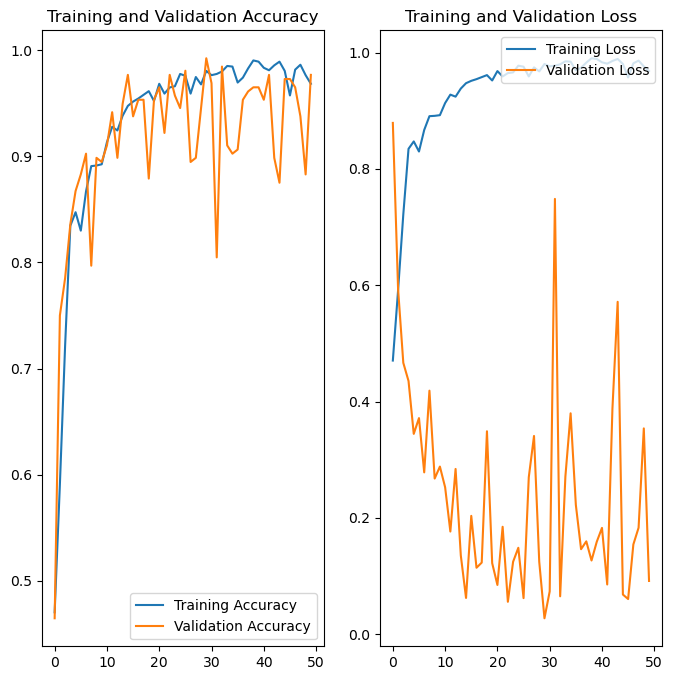

In [30]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label = 'Validation Accuracy')

plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 200ms/step
predicted label: Potato___Late_blight


2025-01-08 16:58:15.924929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


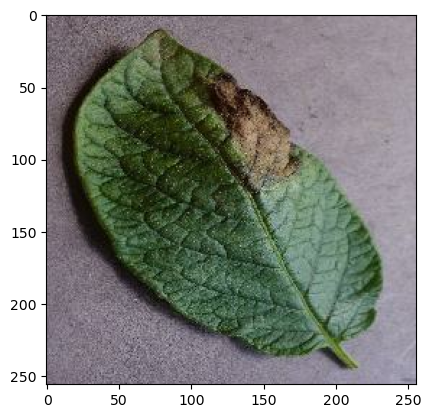

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [32]:
def predict(model, img):
    # Convert the image to a NumPy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # Expand dimensions to match the input shape required by the model
    img_array = tf.expand_dims(img_array, 0)

    # Perform prediction
    predictions = model.predict(img_array)
    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence


1/1 [==============================] - 0s 13ms/step


2025-01-08 16:58:16.187821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 13ms/step


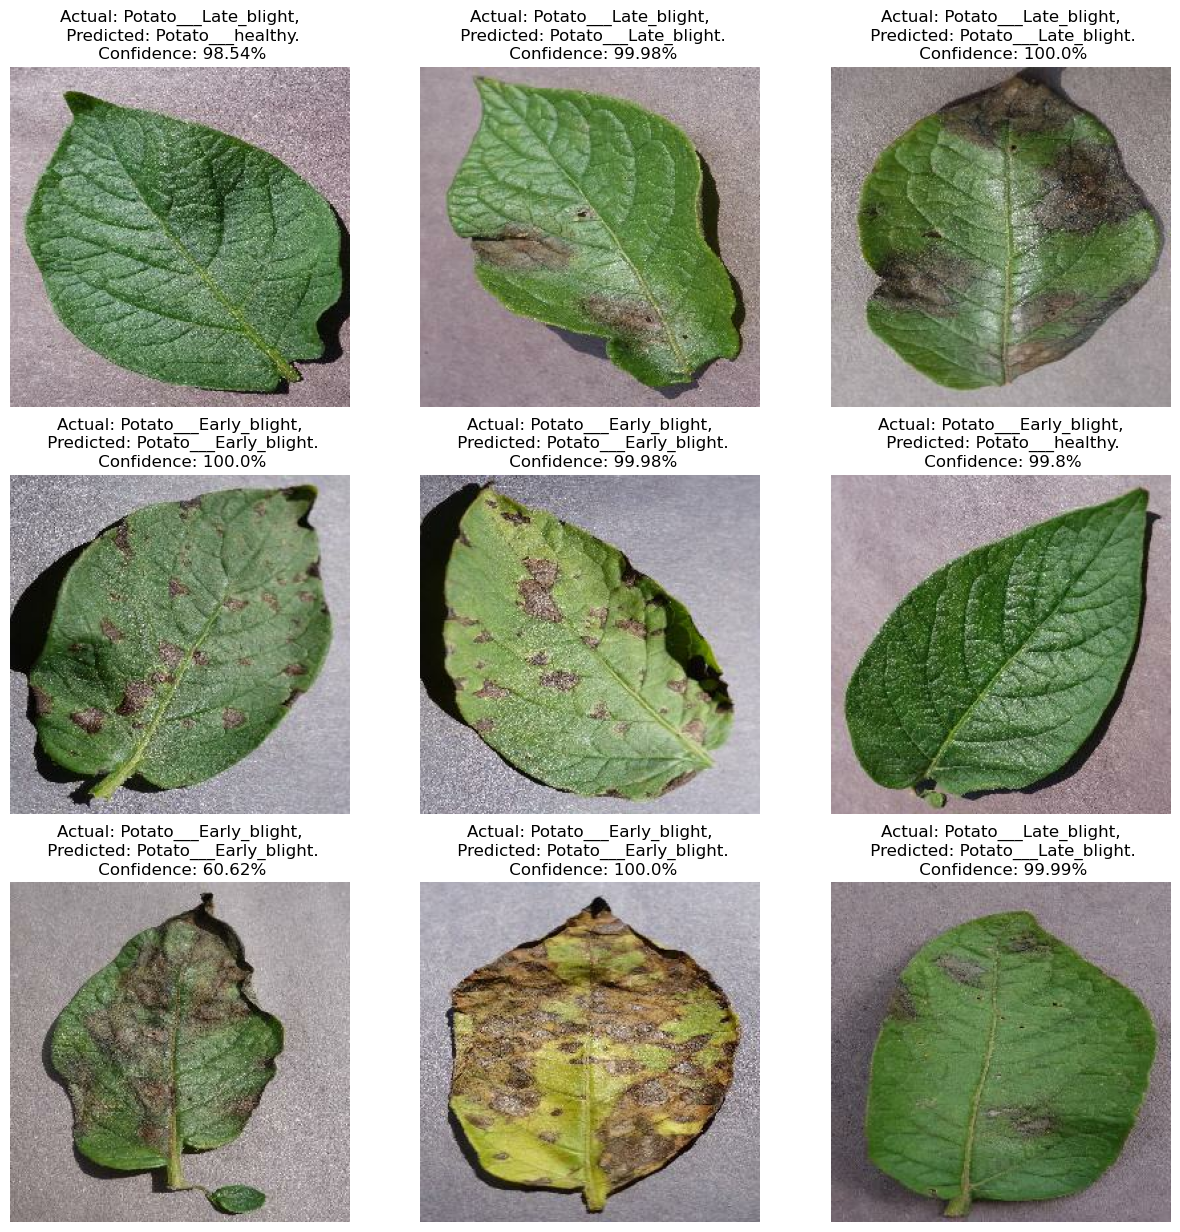

In [33]:
plt.figure(figsize = (15,15))
for images, lables in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_name[label_batch[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%") 
        plt.axis('off')
                   

In [34]:
import os
version = 1
save_directory = f"saved_models/{version}"
while os.path.exists(save_directory):
    version += 1
    save_directory = f"saved_models/{version}"
os.makedirs(save_directory)
model.save(save_directory)
print(f"Model saved in: {save_directory}")





INFO:tensorflow:Assets written to: saved_models/13/assets


INFO:tensorflow:Assets written to: saved_models/13/assets


Model saved in: saved_models/13


In [35]:
model.save('saved_models/my_model.keras')

